Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 18 TIFF files in Nuclei folder.
Found 18 TIFF files in Membrane folder.
Found 18 TIFF files in Golgi folder.
Found 18 TIFF files in Cell folder.
Found 18 complete samples with at least nuclei and cell data.
Sample ID: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast
  nuclei: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_Nuclei_mask.tif
  membrane: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_membrane_mask.tif
  golgi: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_Golgi_golgi_labels.tif
  cell: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_cell_mask.tif
Loaded nuclei image: shape (1024, 1024)
Loaded membrane image: shape (1024, 1024)
Loaded golgi image: shape (1024, 1024)
Loaded cell image: shape (1024, 1024)


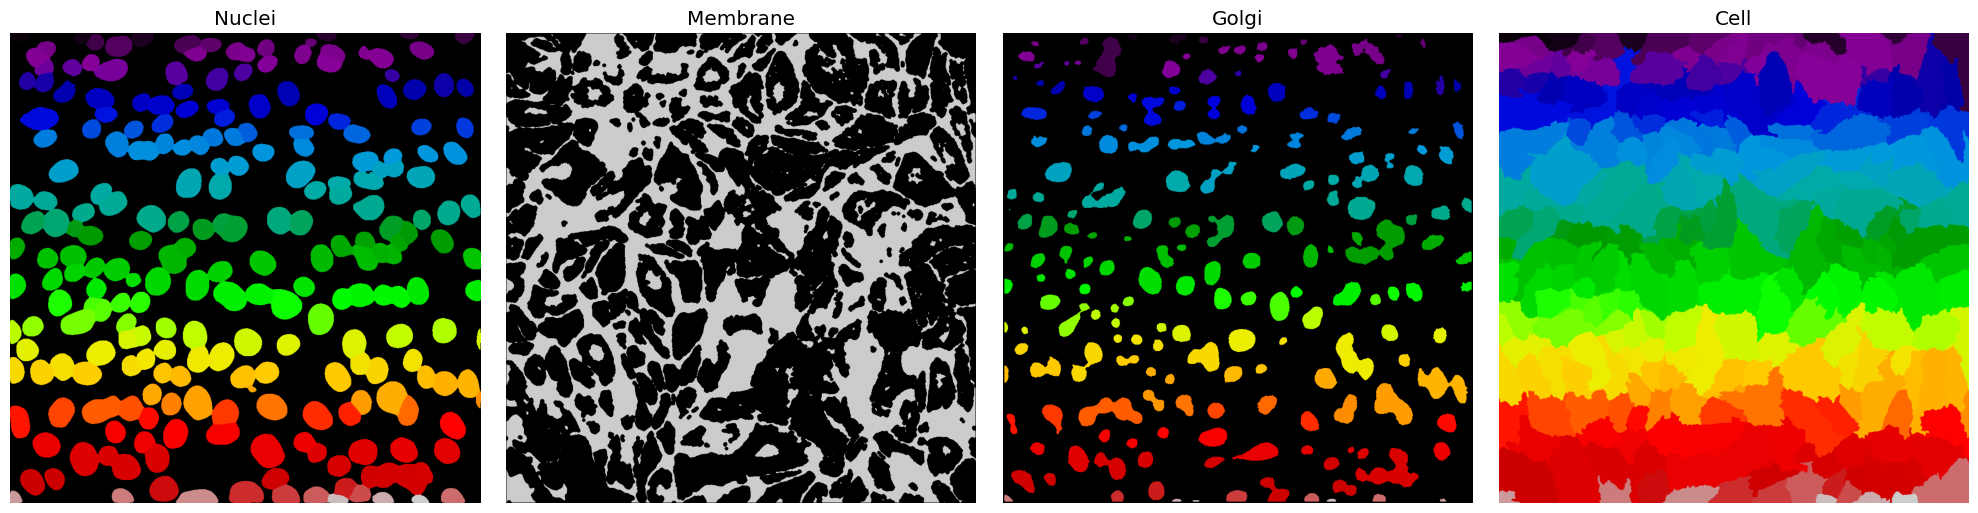


=== Processing sample: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast ===
Loaded nuclei image: shape (1024, 1024)
Loaded membrane image: shape (1024, 1024)
Loaded golgi image: shape (1024, 1024)
Loaded cell image: shape (1024, 1024)
Membrane data available - additional processing could be done here

Cells by flow region:
  upstream: 90 cells (37.3%)
  downstream: 77 cells (32.0%)
  middle: 74 cells (30.7%)
Saved cells data to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/cells.csv
Saved nuclei data to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/nuclei.csv
Saved golgi data to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/golgi.csv


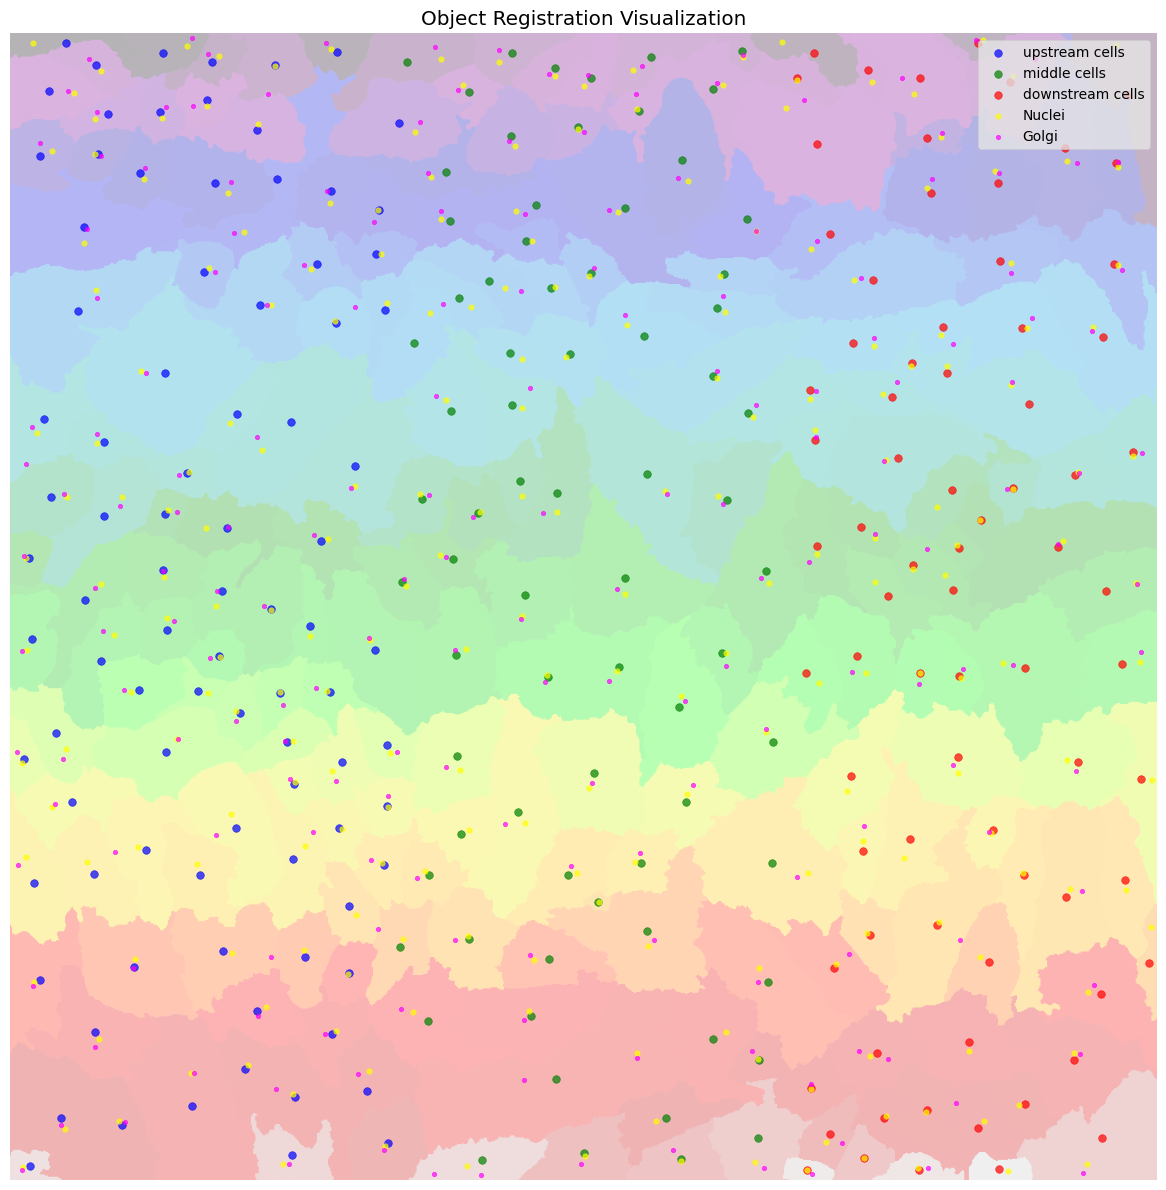

Completed processing for sample denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast


'\nfor sample_id in complete_samples:\n    process_sample(sample_id, file_dict, output_dir)\n    print(f"Completed processing for sample {sample_id}")\n'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, measure
from scipy import ndimage
import tifffile
from pathlib import Path
import seaborn as sns

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
# Adjust these paths based on your specific Drive organization
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data (the minimal requirement)
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Find matching files
file_dict, complete_samples = find_matching_files(base_dir)

# Display the first complete sample as an example
if complete_samples:
    sample_id = complete_samples[0]
    print(f"Sample ID: {sample_id}")
    for component, filepath in file_dict[sample_id].items():
        print(f"  {component}: {os.path.basename(filepath)}")
else:
    print("No complete samples found.")

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            images[component] = io.imread(filepath)
            print(f"Loaded {component} image: shape {images[component].shape}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Load images for the first complete sample
if complete_samples:
    sample_id = complete_samples[0]
    sample_images = load_sample_images(sample_id, file_dict)

    # Visualize the loaded images
    fig, axes = plt.subplots(1, len(sample_images), figsize=(5*len(sample_images), 5))

    if len(sample_images) > 1:
        for i, (component, img) in enumerate(sample_images.items()):
            axes[i].imshow(img, cmap='nipy_spectral')
            axes[i].set_title(f"{component.capitalize()}")
            axes[i].axis('off')
    else:
        component, img = next(iter(sample_images.items()))
        axes.imshow(img, cmap='nipy_spectral')
        axes.set_title(f"{component.capitalize()}")
        axes.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No complete samples to visualize.")

# Function to register objects across channels
def register_objects(images):
    """
    Create relationships between objects in different channels:
    - Assign unique IDs to each cell, nucleus, and Golgi object
    - Map which nucleus belongs to which cell
    - Map which Golgi belongs to which cell
    - Calculate centroids and basic properties
    """
    registration = {
        'cells': [],
        'nuclei': [],
        'golgi': []
    }

    # Register cells first (they're our primary objects)
    if 'cell' in images:
        cell_labels = images['cell']
        cell_props = measure.regionprops(cell_labels)

        for cell_idx, cell_prop in enumerate(cell_props):
            cell_id = cell_prop.label
            centroid_y, centroid_x = cell_prop.centroid

            cell_info = {
                'cell_id': cell_id,
                'centroid_x': centroid_x,
                'centroid_y': centroid_y,
                'area': cell_prop.area,
                'perimeter': cell_prop.perimeter,
                'eccentricity': cell_prop.eccentricity,
                'orientation': np.degrees(cell_prop.orientation) % 180,
                'major_axis_length': cell_prop.major_axis_length,
                'minor_axis_length': cell_prop.minor_axis_length,
                'nuclei_ids': [],
                'golgi_ids': []
            }
            registration['cells'].append(cell_info)

    # Register nuclei and map to cells
    if 'nuclei' in images and 'cell' in images:
        nuclei_labels = images['nuclei']
        nuclei_props = measure.regionprops(nuclei_labels)

        for nucleus_idx, nucleus_prop in enumerate(nuclei_props):
            nucleus_id = nucleus_prop.label
            centroid_y, centroid_x = nucleus_prop.centroid

            # Find which cell this nucleus belongs to
            cell_id = None
            if 0 <= int(centroid_y) < cell_labels.shape[0] and 0 <= int(centroid_x) < cell_labels.shape[1]:
                cell_id = cell_labels[int(centroid_y), int(centroid_x)]

            nucleus_info = {
                'nucleus_id': nucleus_id,
                'cell_id': cell_id,
                'centroid_x': centroid_x,
                'centroid_y': centroid_y,
                'area': nucleus_prop.area,
                'eccentricity': nucleus_prop.eccentricity,
                'orientation': np.degrees(nucleus_prop.orientation) % 180
            }
            registration['nuclei'].append(nucleus_info)

            # Add nucleus to the corresponding cell
            if cell_id:
                for cell in registration['cells']:
                    if cell['cell_id'] == cell_id:
                        cell['nuclei_ids'].append(nucleus_id)

    # Register Golgi and map to cells (if 'golgi' is available)
    if 'golgi' in images and 'cell' in images:
        golgi_labels = images['golgi']
        golgi_props = measure.regionprops(golgi_labels)

        for golgi_idx, golgi_prop in enumerate(golgi_props):
            golgi_id = golgi_prop.label
            centroid_y, centroid_x = golgi_prop.centroid

            # Find which cell this Golgi belongs to
            cell_id = None
            if 0 <= int(centroid_y) < cell_labels.shape[0] and 0 <= int(centroid_x) < cell_labels.shape[1]:
                cell_id = cell_labels[int(centroid_y), int(centroid_x)]

            golgi_info = {
                'golgi_id': golgi_id,
                'cell_id': cell_id,
                'centroid_x': centroid_x,
                'centroid_y': centroid_y,
                'area': golgi_prop.area
            }
            registration['golgi'].append(golgi_info)

            # Add Golgi to the corresponding cell
            if cell_id:
                for cell in registration['cells']:
                    if cell['cell_id'] == cell_id:
                        cell['golgi_ids'].append(golgi_id)

    # Process membrane data if available
    if 'membrane' in images and 'cell' in images:
        # For membrane, we can calculate distance from nucleus to membrane
        # or other metrics as needed
        print("Membrane data available - additional processing could be done here")

    # Create DataFrames from the collected information
    df_cells = pd.DataFrame(registration['cells']) if registration['cells'] else pd.DataFrame()
    df_nuclei = pd.DataFrame(registration['nuclei']) if registration['nuclei'] else pd.DataFrame()
    df_golgi = pd.DataFrame(registration['golgi']) if registration['golgi'] else pd.DataFrame()

    return {
        'cells': df_cells,
        'nuclei': df_nuclei,
        'golgi': df_golgi
    }

# Add position-based region assignments (assuming flow is left to right)
def assign_flow_regions(df_cells):
    """Divide cells into upstream, middle, and downstream regions based on x position"""
    if df_cells.empty:
        return df_cells

    x_min, x_max = df_cells['centroid_x'].min(), df_cells['centroid_x'].max()
    third = (x_max - x_min) / 3

    def get_region(x):
        if x < x_min + third:
            return 'upstream'
        elif x < x_min + 2*third:
            return 'middle'
        else:
            return 'downstream'

    df_cells['region'] = df_cells['centroid_x'].apply(get_region)

    # Print summary of cells in each region
    region_counts = df_cells['region'].value_counts()
    print("\nCells by flow region:")
    for region, count in region_counts.items():
        print(f"  {region}: {count} cells ({count/len(df_cells)*100:.1f}%)")

    return df_cells

# Function to process a complete pipeline for a sample
def process_sample(sample_id, file_dict, output_dir):
    print(f"\n=== Processing sample: {sample_id} ===")

    # 1. Load images
    sample_images = load_sample_images(sample_id, file_dict)
    if not sample_images:
        print(f"Failed to load images for sample {sample_id}")
        return None

    # 2. Register objects
    registration_results = register_objects(sample_images)

    # 3. Assign flow regions to cells
    if 'cells' in registration_results and not registration_results['cells'].empty:
        registration_results['cells'] = assign_flow_regions(registration_results['cells'])

    # 4. Create sample-specific output directory
    sample_dir = os.path.join(output_dir, f"sample_{sample_id}")
    os.makedirs(sample_dir, exist_ok=True)

    # 5. Save registration results
    for component, df in registration_results.items():
        if not df.empty:
            output_file = os.path.join(sample_dir, f"{component}.csv")
            df.to_csv(output_file, index=False)
            print(f"Saved {component} data to {output_file}")

    # 6. Visualize object relationships (optional)
    visualize_registration(sample_images, registration_results, sample_dir)

    return registration_results

# Function to visualize object relationships
def visualize_registration(sample_images, registration_results, output_dir=None):
    """Create visualization showing registered objects across channels"""
    # Create a combined visualization
    plt.figure(figsize=(15, 12))

    # Base layer: cell segmentation
    if 'cell' in sample_images:
        plt.imshow(sample_images['cell'], cmap='nipy_spectral', alpha=0.3)

    # Plot cell centroids
    if 'cells' in registration_results and not registration_results['cells'].empty:
        df_cells = registration_results['cells']

        # Color by region if available
        if 'region' in df_cells.columns:
            region_colors = {'upstream': 'blue', 'middle': 'green', 'downstream': 'red'}
            for region, color in region_colors.items():
                subset = df_cells[df_cells['region'] == region]
                plt.scatter(subset['centroid_x'], subset['centroid_y'],
                           color=color, s=30, alpha=0.7, label=f"{region} cells")
        else:
            plt.scatter(df_cells['centroid_x'], df_cells['centroid_y'],
                       color='blue', s=30, alpha=0.7, label='Cells')

    # Plot nucleus centroids
    if 'nuclei' in registration_results and not registration_results['nuclei'].empty:
        df_nuclei = registration_results['nuclei']
        plt.scatter(df_nuclei['centroid_x'], df_nuclei['centroid_y'],
                   color='yellow', s=15, alpha=0.7, label='Nuclei')

    # Plot Golgi centroids
    if 'golgi' in registration_results and not registration_results['golgi'].empty:
        df_golgi = registration_results['golgi']
        plt.scatter(df_golgi['centroid_x'], df_golgi['centroid_y'],
                   color='magenta', s=10, alpha=0.7, label='Golgi')

    plt.title(f'Object Registration Visualization')
    plt.legend(loc='upper right')
    plt.axis('off')
    plt.tight_layout()

    # Save the figure if output directory is provided
    if output_dir:
        plt.savefig(os.path.join(output_dir, "object_registration.png"), dpi=300)

    plt.show()

# Run the pipeline for the first complete sample
if complete_samples:
    sample_id = complete_samples[0]
    registration_results = process_sample(sample_id, file_dict, output_dir)
    print(f"Completed processing for sample {sample_id}")
else:
    print("No complete samples found to process.")

# To process all complete samples, uncomment the following loop:
"""
for sample_id in complete_samples:
    process_sample(sample_id, file_dict, output_dir)
    print(f"Completed processing for sample {sample_id}")
"""

In [2]:
# Import necessary libraries (same as your existing code)
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, measure
from scipy import ndimage
import tifffile
from pathlib import Path
import seaborn as sns

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure (using the paths from your code)
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Use the same extract_sample_id, find_matching_files, and load_sample_images functions from your code
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

def find_matching_files(base_dir):
    # Define component folders to look in
    component_folders = ['Nuclei', 'Membrane', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data (the minimal requirement)
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            images[component] = io.imread(filepath)
            print(f"Loaded {component} image: shape {images[component].shape}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Find matching files
file_dict, complete_samples = find_matching_files(base_dir)

# Display the first complete sample as an example
if complete_samples:
    sample_id = complete_samples[0]
    print(f"Sample ID: {sample_id}")
    for component, filepath in file_dict[sample_id].items():
        print(f"  {component}: {os.path.basename(filepath)}")
else:
    print("No complete samples found.")

# Load images for the first complete sample
if complete_samples:
    sample_id = complete_samples[0]
    sample_images = load_sample_images(sample_id, file_dict)
else:
    print("No complete samples to visualize.")

# Function to create and display membrane masks
def create_and_display_membrane_masks(sample_images):
    """
    Create and display membrane masks with areas of nuclei and/or golgi set to 0
    """
    if 'membrane' not in sample_images or 'nuclei' not in sample_images or 'golgi' not in sample_images:
        print("Missing required images (membrane, nuclei, or golgi)")
        return

    # Convert all images to binary if they're not already
    membrane_binary = sample_images['membrane'] > 0
    nuclei_binary = sample_images['nuclei'] > 0
    golgi_binary = sample_images['golgi'] > 0

    # Create masked versions
    membrane_without_nuclei = membrane_binary.copy()
    membrane_without_nuclei[nuclei_binary] = 0

    membrane_without_golgi = membrane_binary.copy()
    membrane_without_golgi[golgi_binary] = 0

    membrane_without_both = membrane_binary.copy()
    membrane_without_both[nuclei_binary | golgi_binary] = 0

    # Display the results
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Original membrane
    axes[0, 0].imshow(membrane_binary, cmap='gray')
    axes[0, 0].set_title('Original Membrane')
    axes[0, 0].axis('off')

    # Membrane without nuclei
    axes[0, 1].imshow(membrane_without_nuclei, cmap='gray')
    axes[0, 1].set_title('Membrane (without Nuclei)')
    axes[0, 1].axis('off')

    # Membrane without golgi
    axes[1, 0].imshow(membrane_without_golgi, cmap='gray')
    axes[1, 0].set_title('Membrane (without Golgi)')
    axes[1, 0].axis('off')

    # Membrane without both
    axes[1, 1].imshow(membrane_without_both, cmap='gray')
    axes[1, 1].set_title('Membrane (without Nuclei & Golgi)')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Also create a color overlay image
    rgb_overlay = np.zeros((membrane_binary.shape[0], membrane_binary.shape[1], 3), dtype=np.float32)

    # Assign channels: Red=membrane, Green=golgi, Blue=nuclei
    rgb_overlay[..., 0] = membrane_binary  # Red channel
    rgb_overlay[..., 1] = golgi_binary     # Green channel
    rgb_overlay[..., 2] = nuclei_binary    # Blue channel

    plt.figure(figsize=(12, 12))
    plt.imshow(rgb_overlay)
    plt.title('RGB Overlay: Membrane (Red), Golgi (Green), Nuclei (Blue)')
    plt.axis('off')
    plt.show()

    return {
        'original': membrane_binary,
        'without_nuclei': membrane_without_nuclei,
        'without_golgi': membrane_without_golgi,
        'without_both': membrane_without_both,
        'rgb_overlay': rgb_overlay
    }

# Function to calculate percentages of membrane overlap
def calculate_membrane_overlaps(masks):
    """Calculate the percentage of membrane pixels that overlap with nuclei and golgi"""
    original_membrane_pixels = np.sum(masks['original'])

    # Calculate pixels lost when removing nuclei
    nuclei_overlap_pixels = original_membrane_pixels - np.sum(masks['without_nuclei'])
    nuclei_overlap_percent = (nuclei_overlap_pixels / original_membrane_pixels) * 100

    # Calculate pixels lost when removing golgi
    golgi_overlap_pixels = original_membrane_pixels - np.sum(masks['without_golgi'])
    golgi_overlap_percent = (golgi_overlap_pixels / original_membrane_pixels) * 100

    # Calculate pixels lost when removing both
    both_overlap_pixels = original_membrane_pixels - np.sum(masks['without_both'])
    both_overlap_percent = (both_overlap_pixels / original_membrane_pixels) * 100

    print(f"\nMembrane Overlap Statistics:")
    print(f"Total membrane pixels: {original_membrane_pixels}")
    print(f"Membrane overlapping with nuclei: {nuclei_overlap_pixels} pixels ({nuclei_overlap_percent:.2f}%)")
    print(f"Membrane overlapping with golgi: {golgi_overlap_pixels} pixels ({golgi_overlap_percent:.2f}%)")
    print(f"Membrane overlapping with either nuclei or golgi: {both_overlap_pixels} pixels ({both_overlap_percent:.2f}%)")

    # Create a bar chart of overlaps
    categories = ['Nuclei Overlap', 'Golgi Overlap', 'Either Overlap']
    percentages = [nuclei_overlap_percent, golgi_overlap_percent, both_overlap_percent]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, percentages, color=['blue', 'green', 'purple'])

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom')

    plt.title('Percentage of Membrane Pixels Overlapping with Other Structures')
    plt.ylabel('Percentage of Membrane Pixels')
    plt.ylim(0, max(percentages) + 5)  # Add some space above the highest bar
    plt.show()

# Run the membrane masking analysis if we have a complete sample
if complete_samples and 'membrane' in sample_images and 'nuclei' in sample_images and 'golgi' in sample_images:
    print(f"\n=== Creating membrane masks for sample: {sample_id} ===")
    membrane_masks = create_and_display_membrane_masks(sample_images)

    # Calculate and display overlap statistics
    calculate_membrane_overlaps(membrane_masks)
else:
    print("Cannot create membrane masks: missing required components (membrane, nuclei, or golgi)")

KeyboardInterrupt: 

In [3]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define explicit file paths for just one example
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"

# Example file paths - replace these with the exact filenames from your first sample
# You can copy these from the output of your previous code that printed the sample filenames
nuclei_file = os.path.join(base_dir, "Nuclei", "denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_Nuclei_mask.tif")
membrane_file = os.path.join(base_dir, "Membrane", "denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_membrane_mask.tif")
golgi_file = os.path.join(base_dir, "Golgi", "denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_Golgi_golgi_labels.tif")
cell_file = os.path.join(base_dir, "Cell", "denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_cell_mask.tif")

# Function to load a single image and handle errors
def load_image(file_path):
    if os.path.exists(file_path):
        img = io.imread(file_path)
        print(f"Loaded image: {os.path.basename(file_path)}, shape: {img.shape}")
        return img
    else:
        print(f"Warning: File not found - {file_path}")
        return None

# Load the specific images for this example
print("Loading images for single example...")
nuclei_img = load_image(nuclei_file)
membrane_img = load_image(membrane_file)
golgi_img = load_image(golgi_file)
cell_img = load_image(cell_file)

# Check if we have all necessary images
if nuclei_img is None or membrane_img is None or golgi_img is None:
    print("Missing required images. Please check the file paths.")
else:
    # Create membrane masks where pixels are set to 0 where nuclei/golgi are present
    print("\nCreating membrane masks...")

    # Convert to binary if not already
    membrane_binary = membrane_img > 0
    nuclei_binary = nuclei_img > 0
    golgi_binary = golgi_img > 0

    # Create the masks
    membrane_without_nuclei = membrane_binary.copy()
    membrane_without_nuclei[nuclei_binary] = 0

    membrane_without_golgi = membrane_binary.copy()
    membrane_without_golgi[golgi_binary] = 0

    membrane_without_both = membrane_binary.copy()
    membrane_without_both[nuclei_binary | golgi_binary] = 0

    # Display the results
    print("Displaying membrane masks...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Original membrane
    axes[0, 0].imshow(membrane_binary, cmap='gray')
    axes[0, 0].set_title('Original Membrane', fontsize=14)
    axes[0, 0].axis('off')

    # Membrane without nuclei
    axes[0, 1].imshow(membrane_without_nuclei, cmap='gray')
    axes[0, 1].set_title('Membrane (without Nuclei)', fontsize=14)
    axes[0, 1].axis('off')

    # Membrane without golgi
    axes[1, 0].imshow(membrane_without_golgi, cmap='gray')
    axes[1, 0].set_title('Membrane (without Golgi)', fontsize=14)
    axes[1, 0].axis('off')

    # Membrane without both
    axes[1, 1].imshow(membrane_without_both, cmap='gray')
    axes[1, 1].set_title('Membrane (without Nuclei & Golgi)', fontsize=14)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate and display statistics
    total_membrane_pixels = np.sum(membrane_binary)
    nuclei_overlap_pixels = np.sum(membrane_binary & nuclei_binary)
    golgi_overlap_pixels = np.sum(membrane_binary & golgi_binary)
    both_overlap_pixels = np.sum(membrane_binary & (nuclei_binary | golgi_binary))

    print("\nMembrane Overlap Statistics:")
    print(f"Total membrane pixels: {total_membrane_pixels}")
    print(f"Membrane overlapping with nuclei: {nuclei_overlap_pixels} pixels ({nuclei_overlap_pixels/total_membrane_pixels*100:.2f}%)")
    print(f"Membrane overlapping with golgi: {golgi_overlap_pixels} pixels ({golgi_overlap_pixels/total_membrane_pixels*100:.2f}%)")
    print(f"Membrane overlapping with either nuclei or golgi: {both_overlap_pixels} pixels ({both_overlap_pixels/total_membrane_pixels*100:.2f}%)")

    # Create a color overlay image
    print("\nCreating color overlay...")
    rgb_overlay = np.zeros((membrane_binary.shape[0], membrane_binary.shape[1], 3), dtype=np.float32)

    # Assign channels: Red=membrane, Green=golgi, Blue=nuclei
    rgb_overlay[..., 0] = membrane_binary  # Red channel
    rgb_overlay[..., 1] = golgi_binary     # Green channel
    rgb_overlay[..., 2] = nuclei_binary    # Blue channel

    plt.figure(figsize=(12, 12))
    plt.imshow(rgb_overlay)
    plt.title('RGB Overlay: Membrane (Red), Golgi (Green), Nuclei (Blue)', fontsize=16)
    plt.axis('off')
    plt.show()

    # Show RGB channels separately for better understanding
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(membrane_binary, cmap='Reds')
    axes[0].set_title('Membrane (Red Channel)', fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(golgi_binary, cmap='Greens')
    axes[1].set_title('Golgi (Green Channel)', fontsize=14)
    axes[1].axis('off')

    axes[2].imshow(nuclei_binary, cmap='Blues')
    axes[2].set_title('Nuclei (Blue Channel)', fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 18 TIFF files in Nuclei folder.
Found 18 TIFF files in Membrane folder.
Found 18 TIFF files in Golgi folder.
Found 18 complete samples with membrane, nuclei, and golgi data.

Processing 18 samples...

Sample 1/18: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast

Processing sample: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast
  Loaded membrane image: shape (1024, 1024)
  Loaded nuclei image: shape (1024, 1024)
  Loaded golgi image: shape (1024, 1024)
  Saved adjusted membrane to: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Membrane_Adjusted/denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_membrane_mask_adjusted.tif

Sample 2/18: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq002_contrast

Processing sample: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq002_contrast
  Loaded membrane image: shape (1024, 1024)
  L

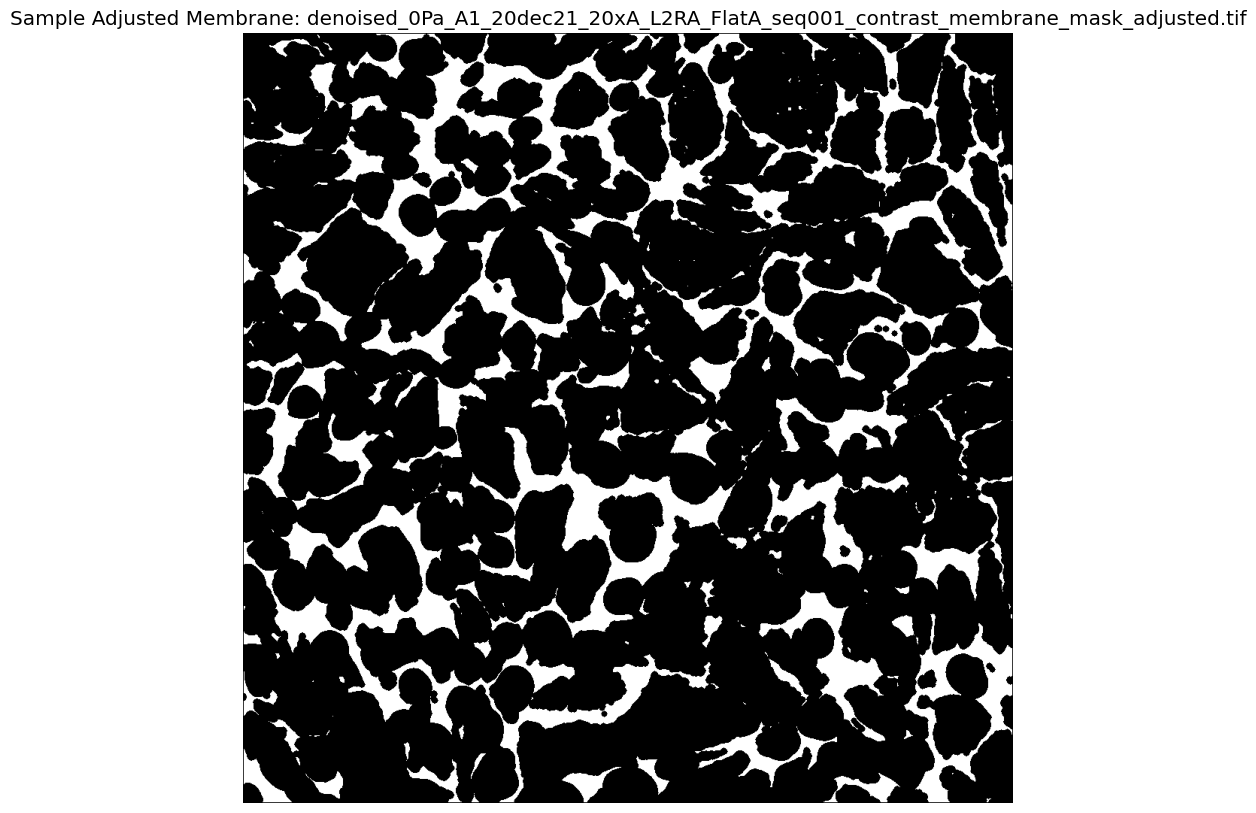

Displayed sample adjusted membrane image: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_membrane_mask_adjusted.tif


In [4]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, measure
from scipy import ndimage
import tifffile
from pathlib import Path
import seaborn as sns

# Set up paths
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Membrane_Adjusted"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in
    component_folders = ['Nuclei', 'Membrane', 'Golgi']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have all required components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have membrane, nuclei, and golgi data
        if 'membrane' in components and 'nuclei' in components and 'golgi' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with membrane, nuclei, and golgi data.")

    return file_dict, complete_samples

# Function to create adjusted membrane image (removing nuclei and golgi areas)
def create_adjusted_membrane(membrane_img, nuclei_img, golgi_img):
    """
    Create membrane image with pixels set to 0 where nuclei or golgi are present
    """
    # Convert to binary if not already
    membrane_binary = membrane_img > 0
    nuclei_binary = nuclei_img > 0
    golgi_binary = golgi_img > 0

    # Create the mask where membrane does not overlap with nuclei or golgi
    membrane_without_both = membrane_binary.copy()
    membrane_without_both[nuclei_binary | golgi_binary] = 0

    # Convert back to the original data type of membrane_img
    if membrane_img.dtype == bool:
        return membrane_without_both
    else:
        return membrane_without_both.astype(membrane_img.dtype) * (membrane_img.max() or 1)

# Function to process a single sample
def process_sample(sample_id, file_dict, output_dir):
    print(f"\nProcessing sample: {sample_id}")

    # Load images
    try:
        membrane_img = io.imread(file_dict[sample_id]['membrane'])
        nuclei_img = io.imread(file_dict[sample_id]['nuclei'])
        golgi_img = io.imread(file_dict[sample_id]['golgi'])

        print(f"  Loaded membrane image: shape {membrane_img.shape}")
        print(f"  Loaded nuclei image: shape {nuclei_img.shape}")
        print(f"  Loaded golgi image: shape {golgi_img.shape}")
    except Exception as e:
        print(f"  Error loading images for sample {sample_id}: {e}")
        return False

    # Create adjusted membrane image
    adjusted_membrane = create_adjusted_membrane(membrane_img, nuclei_img, golgi_img)

    # Create output filename, keeping the original filename pattern but adding "_adjusted"
    original_filename = os.path.basename(file_dict[sample_id]['membrane'])
    adjusted_filename = original_filename.replace('.tif', '_adjusted.tif')
    output_path = os.path.join(output_dir, adjusted_filename)

    # Save the adjusted membrane image
    try:
        tifffile.imwrite(output_path, adjusted_membrane)
        print(f"  Saved adjusted membrane to: {output_path}")
        return True
    except Exception as e:
        print(f"  Error saving adjusted membrane for sample {sample_id}: {e}")
        return False

# Find matching files
file_dict, complete_samples = find_matching_files(base_dir)

# Process all samples with complete data
successful_count = 0
failed_count = 0

print(f"\nProcessing {len(complete_samples)} samples...")

for i, sample_id in enumerate(complete_samples):
    print(f"\nSample {i+1}/{len(complete_samples)}: {sample_id}")
    result = process_sample(sample_id, file_dict, output_dir)
    if result:
        successful_count += 1
    else:
        failed_count += 1

print(f"\nProcessing complete!")
print(f"Successfully processed: {successful_count} samples")
print(f"Failed: {failed_count} samples")
print(f"Output directory: {output_dir}")

# Display a sample of the adjusted images for verification
if successful_count > 0:
    # Get a list of the adjusted membrane files
    adjusted_files = [f for f in os.listdir(output_dir) if f.endswith('_adjusted.tif')]

    if adjusted_files:
        # Display the first adjusted membrane image as an example
        sample_file = os.path.join(output_dir, adjusted_files[0])
        sample_img = io.imread(sample_file)

        plt.figure(figsize=(10, 10))
        plt.imshow(sample_img, cmap='gray')
        plt.title(f'Sample Adjusted Membrane: {adjusted_files[0]}')
        plt.axis('off')
        plt.show()

        print(f"Displayed sample adjusted membrane image: {adjusted_files[0]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 18 TIFF files in Nuclei folder.
Found 18 TIFF files in Membrane_Adjusted folder.
Found 18 TIFF files in Golgi folder.
Found 18 TIFF files in Cell folder.
Found 18 complete samples with nuclei, membrane, and cell data.
Processing sample denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast

=== Processing membrane metrics for sample: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast ===
Loaded nuclei image: shape (1024, 1024)
Loaded membrane image: shape (1024, 1024)
Loaded golgi image: shape (1024, 1024)
Loaded cell image: shape (1024, 1024)
Number of separate membrane segments: 9582

Tortuosity Analysis:
Number of analyzed segments: 143
Mean tortuosity: 1.292
Median tortuosity: 1.215
Min tortuosity: 1.053
Max tortuosity: 2.109
Standard deviation: 0.219
Saved skeleton to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A

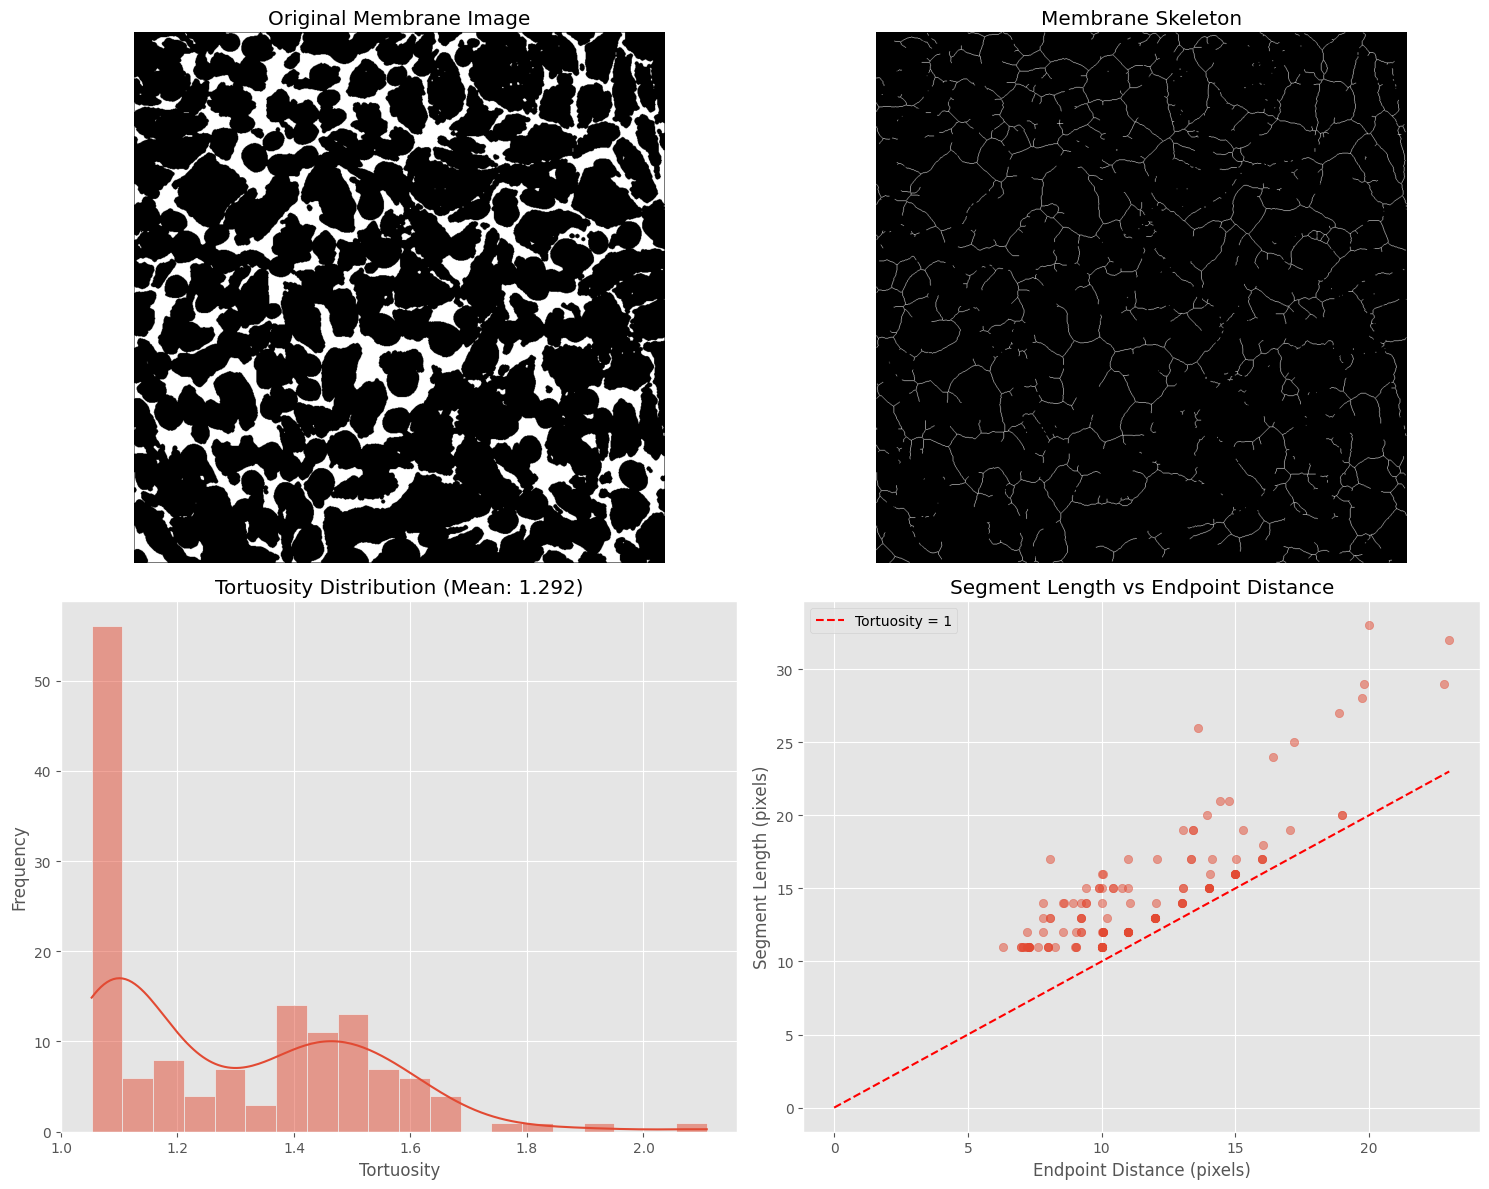


=== Analyzing membrane by region for sample: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast ===
Loaded nuclei image: shape (1024, 1024)
Loaded membrane image: shape (1024, 1024)
Loaded golgi image: shape (1024, 1024)
Loaded cell image: shape (1024, 1024)
Number of separate membrane segments: 3173

Upstream Region Tortuosity:
Number of analyzed segments: 49
Mean tortuosity: 1.268
Number of separate membrane segments: 3077

Middle Region Tortuosity:
Number of analyzed segments: 41
Mean tortuosity: 1.280
Number of separate membrane segments: 3344

Downstream Region Tortuosity:
Number of analyzed segments: 53
Mean tortuosity: 1.323
Saved region visualization to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/membrane_tortuosity_by_region.png


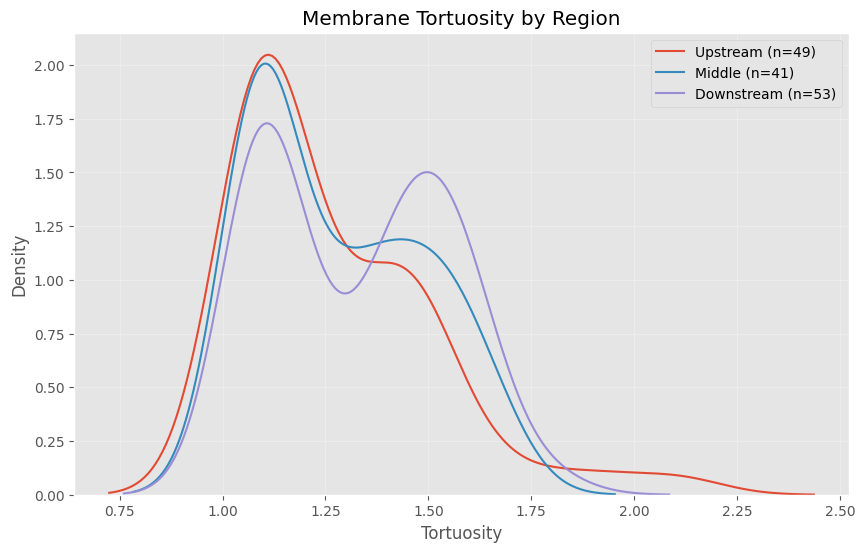

Saved region summary to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/membrane_region_summary.csv
Completed processing for sample denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, measure
from skimage.morphology import thin
from skimage.measure import regionprops
from scipy import ndimage
from scipy.ndimage import label
import tifffile
from pathlib import Path
import seaborn as sns

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    # Note: Using Membrane_Adjusted instead of Membrane as requested
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei, membrane and cell data
        if 'nuclei' in components and 'cell' in components and 'membrane' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with nuclei, membrane, and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            images[component] = io.imread(filepath)
            print(f"Loaded {component} image: shape {images[component].shape}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Function to calculate membrane tortuosity
def calculate_tortuosity(membrane_image, min_length=10):
    """
    Calculate tortuosity for membrane segments

    Parameters:
    membrane_image: Binary image of membrane
    min_length: Minimum length to consider (to avoid very short segments)

    Returns:
    Dictionary with tortuosity values and statistics
    """
    # Ensure binary
    binary_membrane = membrane_image > 0

    # Create skeleton
    skeleton = thin(binary_membrane)

    # Label the skeletonized segments
    labeled_skeleton, num_segments = label(skeleton)
    print(f"Number of separate membrane segments: {num_segments}")

    # Calculate properties for each segment
    props = regionprops(labeled_skeleton)

    # Calculate tortuosity for each segment
    tortuosity_values = []
    segment_lengths = []
    segment_distances = []

    for prop in props:
        # Get actual path length (number of pixels in the segment)
        actual_length = prop.area  # for skeleton, area equals length

        # Get endpoint distance (Euclidean distance between furthest points)
        coords = prop.coords
        if len(coords) > min_length:  # only consider segments longer than min_length
            distances = np.sqrt(np.sum((coords[:, None, :] - coords[None, :, :]) ** 2, axis=2))
            endpoint_distance = np.max(distances)

            segment_lengths.append(actual_length)
            segment_distances.append(endpoint_distance)

            # Calculate tortuosity (ratio of actual length to endpoint distance)
            if endpoint_distance > 0:
                tortuosity = actual_length / endpoint_distance
                tortuosity_values.append(tortuosity)

    # Calculate statistics
    stats = {
        'num_segments': len(tortuosity_values),
        'mean_tortuosity': np.mean(tortuosity_values) if tortuosity_values else 0,
        'median_tortuosity': np.median(tortuosity_values) if tortuosity_values else 0,
        'min_tortuosity': np.min(tortuosity_values) if tortuosity_values else 0,
        'max_tortuosity': np.max(tortuosity_values) if tortuosity_values else 0,
        'std_tortuosity': np.std(tortuosity_values) if tortuosity_values else 0,
        'tortuosity_values': tortuosity_values,
        'segment_lengths': segment_lengths,
        'segment_distances': segment_distances,
        'skeleton': skeleton
    }

    return stats

# Function to visualize tortuosity results
def visualize_tortuosity(membrane_image, stats, output_path=None):
    """Create visualizations for membrane tortuosity analysis"""

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original membrane image
    axes[0, 0].imshow(membrane_image, cmap='gray')
    axes[0, 0].set_title("Original Membrane Image")
    axes[0, 0].axis('off')

    # 2. Skeleton visualization
    axes[0, 1].imshow(stats['skeleton'], cmap='gray')
    axes[0, 1].set_title("Membrane Skeleton")
    axes[0, 1].axis('off')

    # 3. Histogram of tortuosity values
    if stats['tortuosity_values']:
        sns.histplot(stats['tortuosity_values'], bins=20, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title(f"Tortuosity Distribution (Mean: {stats['mean_tortuosity']:.3f})")
        axes[1, 0].set_xlabel("Tortuosity")
        axes[1, 0].set_ylabel("Frequency")
    else:
        axes[1, 0].text(0.5, 0.5, "No tortuosity data available",
                      horizontalalignment='center', verticalalignment='center')

    # 4. Scatter plot of segment length vs endpoint distance
    if stats['segment_lengths'] and stats['segment_distances']:
        axes[1, 1].scatter(stats['segment_distances'], stats['segment_lengths'], alpha=0.5)
        axes[1, 1].plot([0, max(stats['segment_distances'])], [0, max(stats['segment_distances'])],
                       'r--', label='Tortuosity = 1')
        axes[1, 1].set_title("Segment Length vs Endpoint Distance")
        axes[1, 1].set_xlabel("Endpoint Distance (pixels)")
        axes[1, 1].set_ylabel("Segment Length (pixels)")
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, "No segment data available",
                      horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

# Function to process membrane metrics for a sample
def process_membrane_metrics(sample_id, file_dict, output_dir):
    """Process membrane metrics for a given sample"""
    print(f"\n=== Processing membrane metrics for sample: {sample_id} ===")

    # Load images
    sample_images = load_sample_images(sample_id, file_dict)
    if not sample_images or 'membrane' not in sample_images:
        print(f"Failed to load membrane image for sample {sample_id}")
        return None

    # Create sample-specific output directory
    sample_dir = os.path.join(output_dir, f"sample_{sample_id}")
    os.makedirs(sample_dir, exist_ok=True)

    # Calculate tortuosity
    membrane_stats = calculate_tortuosity(sample_images['membrane'])

    # Print statistics
    print(f"\nTortuosity Analysis:")
    print(f"Number of analyzed segments: {membrane_stats['num_segments']}")
    print(f"Mean tortuosity: {membrane_stats['mean_tortuosity']:.3f}")
    print(f"Median tortuosity: {membrane_stats['median_tortuosity']:.3f}")
    print(f"Min tortuosity: {membrane_stats['min_tortuosity']:.3f}")
    print(f"Max tortuosity: {membrane_stats['max_tortuosity']:.3f}")
    print(f"Standard deviation: {membrane_stats['std_tortuosity']:.3f}")

    # Save outputs
    # Save skeleton
    skeleton_output = os.path.join(sample_dir, "membrane_skeleton.tif")
    tifffile.imwrite(skeleton_output, membrane_stats['skeleton'].astype(np.uint8) * 255)
    print(f"Saved skeleton to {skeleton_output}")

    # Save tortuosity values
    tortuosity_output = os.path.join(sample_dir, "membrane_tortuosity_values.csv")
    pd.DataFrame({
        'tortuosity': membrane_stats['tortuosity_values'],
        'segment_length': membrane_stats['segment_lengths'],
        'endpoint_distance': membrane_stats['segment_distances']
    }).to_csv(tortuosity_output, index=False)
    print(f"Saved tortuosity values to {tortuosity_output}")

    # Save summary statistics
    stats_output = os.path.join(sample_dir, "membrane_stats_summary.csv")
    pd.DataFrame({
        'metric': ['num_segments', 'mean_tortuosity', 'median_tortuosity',
                   'min_tortuosity', 'max_tortuosity', 'std_tortuosity'],
        'value': [membrane_stats['num_segments'], membrane_stats['mean_tortuosity'],
                 membrane_stats['median_tortuosity'], membrane_stats['min_tortuosity'],
                 membrane_stats['max_tortuosity'], membrane_stats['std_tortuosity']]
    }).to_csv(stats_output, index=False)
    print(f"Saved summary statistics to {stats_output}")

    # Create visualization
    vis_output = os.path.join(sample_dir, "membrane_tortuosity_visualization.png")
    visualize_tortuosity(sample_images['membrane'], membrane_stats, vis_output)

    return membrane_stats

# Add position-based region assignments for membranes
def analyze_membrane_by_region(sample_id, file_dict, membrane_stats, output_dir):
    """Analyze membrane properties by region (upstream, middle, downstream)"""
    print(f"\n=== Analyzing membrane by region for sample: {sample_id} ===")

    # Load images
    sample_images = load_sample_images(sample_id, file_dict)
    if not sample_images or 'membrane' not in sample_images or 'cell' not in sample_images:
        print("Missing required images for region analysis")
        return None

    # Get image dimensions
    height, width = sample_images['membrane'].shape

    # Define regions (divide image into thirds along x-axis)
    third_width = width // 3

    # Create region masks
    regions = {
        'upstream': np.zeros(sample_images['membrane'].shape, dtype=bool),
        'middle': np.zeros(sample_images['membrane'].shape, dtype=bool),
        'downstream': np.zeros(sample_images['membrane'].shape, dtype=bool)
    }

    regions['upstream'][:, :third_width] = True
    regions['middle'][:, third_width:2*third_width] = True
    regions['downstream'][:, 2*third_width:] = True

    # Analyze membrane in each region
    region_stats = {}

    for region_name, region_mask in regions.items():
        # Apply region mask to membrane skeleton
        region_membrane = np.logical_and(membrane_stats['skeleton'], region_mask)

        # Calculate tortuosity for this region
        region_tortuosity = calculate_tortuosity(region_membrane)
        region_stats[region_name] = region_tortuosity

        print(f"\n{region_name.capitalize()} Region Tortuosity:")
        print(f"Number of analyzed segments: {region_tortuosity['num_segments']}")
        print(f"Mean tortuosity: {region_tortuosity['mean_tortuosity']:.3f}")

    # Create sample-specific output directory
    sample_dir = os.path.join(output_dir, f"sample_{sample_id}")

    # Create visualization comparing regions
    plt.figure(figsize=(10, 6))

    # Plot tortuosity distribution by region
    for region_name, stats in region_stats.items():
        if stats['tortuosity_values']:
            sns.kdeplot(stats['tortuosity_values'], label=f"{region_name.capitalize()} (n={stats['num_segments']})")

    plt.title(f"Membrane Tortuosity by Region")
    plt.xlabel("Tortuosity")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save figure
    region_vis_output = os.path.join(sample_dir, "membrane_tortuosity_by_region.png")
    plt.savefig(region_vis_output, dpi=300)
    print(f"Saved region visualization to {region_vis_output}")

    plt.show()

    # Create summary table for regions
    region_summary = {
        'region': [],
        'num_segments': [],
        'mean_tortuosity': [],
        'median_tortuosity': [],
        'min_tortuosity': [],
        'max_tortuosity': [],
        'std_tortuosity': []
    }

    for region_name, stats in region_stats.items():
        region_summary['region'].append(region_name)
        region_summary['num_segments'].append(stats['num_segments'])
        region_summary['mean_tortuosity'].append(stats['mean_tortuosity'])
        region_summary['median_tortuosity'].append(stats['median_tortuosity'])
        region_summary['min_tortuosity'].append(stats['min_tortuosity'])
        region_summary['max_tortuosity'].append(stats['max_tortuosity'])
        region_summary['std_tortuosity'].append(stats['std_tortuosity'])

    # Save region summary
    region_summary_df = pd.DataFrame(region_summary)
    region_summary_output = os.path.join(sample_dir, "membrane_region_summary.csv")
    region_summary_df.to_csv(region_summary_output, index=False)
    print(f"Saved region summary to {region_summary_output}")

    return region_stats

# Main function to run the pipeline
def main():
    # Find matching files
    file_dict, complete_samples = find_matching_files(base_dir)

    if not complete_samples:
        print("No complete samples found. Exiting.")
        return

    # Process the first sample
    sample_id = complete_samples[0]
    print(f"Processing sample {sample_id}")

    membrane_stats = process_membrane_metrics(sample_id, file_dict, output_dir)

    if membrane_stats:
        region_stats = analyze_membrane_by_region(sample_id, file_dict, membrane_stats, output_dir)
        print(f"Completed processing for sample {sample_id}")

    # To process all samples, uncomment the following code
    """
    for sample_id in complete_samples:
        print(f"\nProcessing sample {sample_id}")
        membrane_stats = process_membrane_metrics(sample_id, file_dict, output_dir)

        if membrane_stats:
            region_stats = analyze_membrane_by_region(sample_id, file_dict, membrane_stats, output_dir)
            print(f"Completed processing for sample {sample_id}")
    """

# Run the main function
if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 18 TIFF files in Nuclei folder.
Found 18 TIFF files in Membrane_Adjusted folder.
Found 18 TIFF files in Golgi folder.
Found 18 TIFF files in Cell folder.
Found 18 complete samples with at least nuclei and cell data.
Processing sample denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast

=== Processing cell shape analysis for sample: denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast ===
Loaded nuclei image: shape (1024, 1024), dtype: uint32
Loaded membrane image: shape (1024, 1024), dtype: uint8
Loaded golgi image: shape (1024, 1024), dtype: uint32
Loaded cell image: shape (1024, 1024), dtype: uint32

Cell image info: dtype=uint32, min=0, max=241
Nucleus image info: dtype=uint32, min=0, max=241
Cell image: dtype=uint32, min=0, max=241

Shape Analysis Results:
Total cells analyzed: 241

Shape distribution:
  elongated: 11 cells (4.6%)
  heptagona

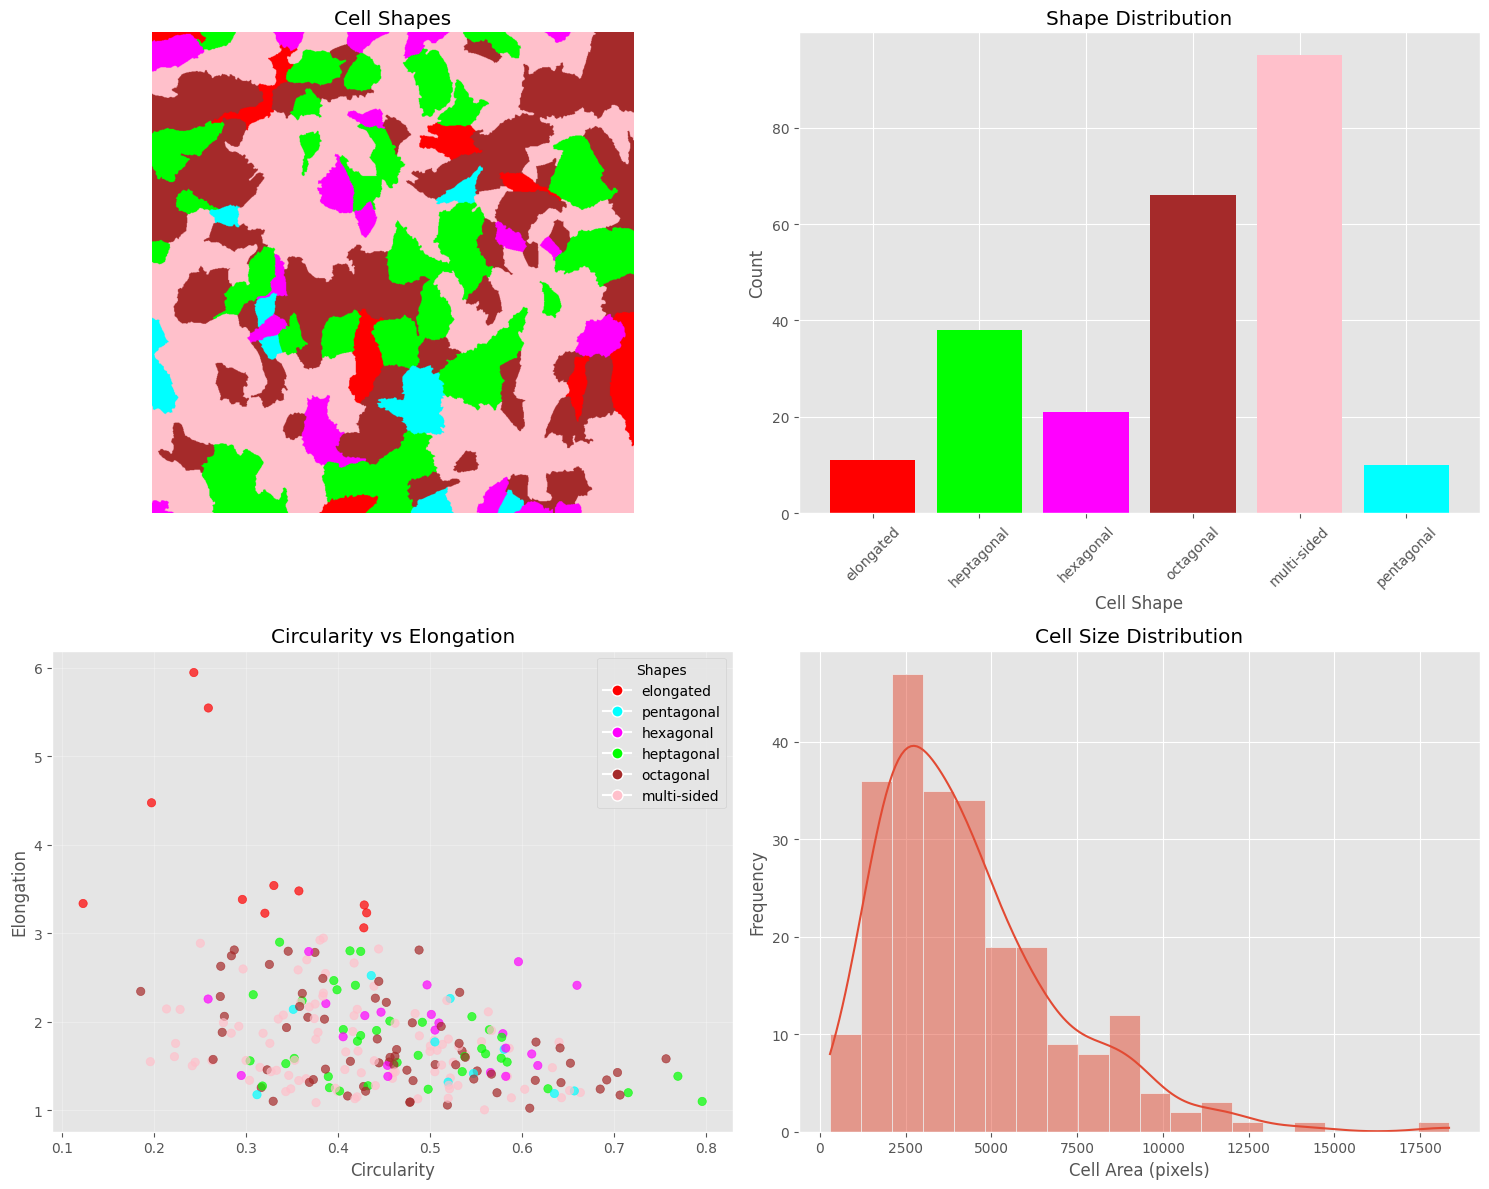

Saved orientation rose diagram to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/cell_shape_visualization_orientation_rose.png


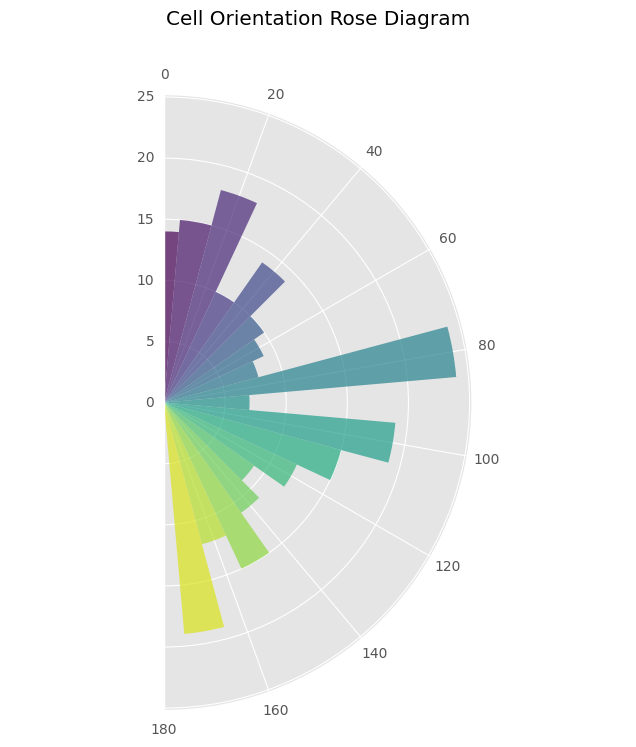

Saved cell examples to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/cell_shape_visualization_examples.png


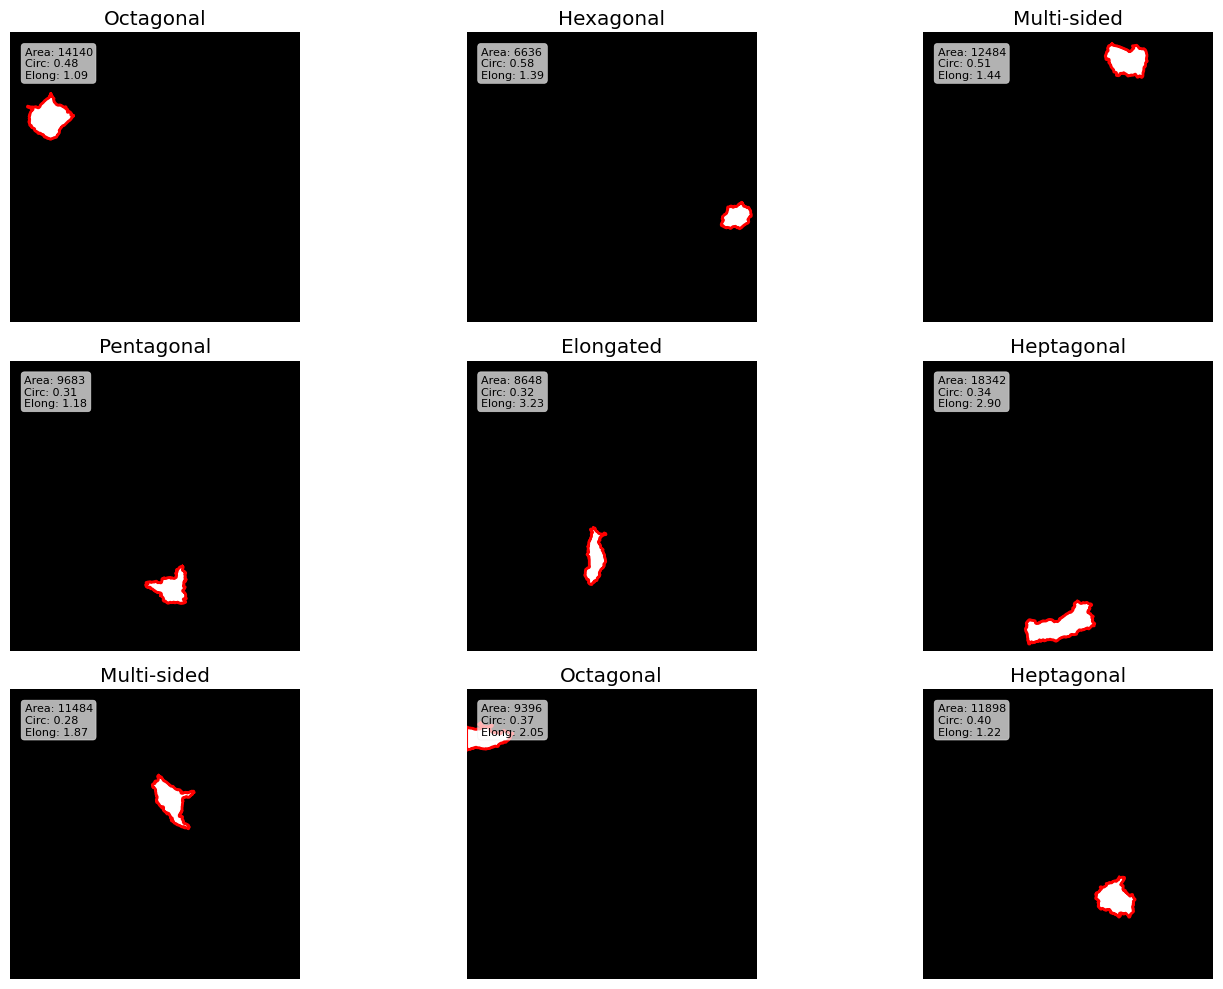

Saved orientation analysis to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/cell_orientation_analysis.png


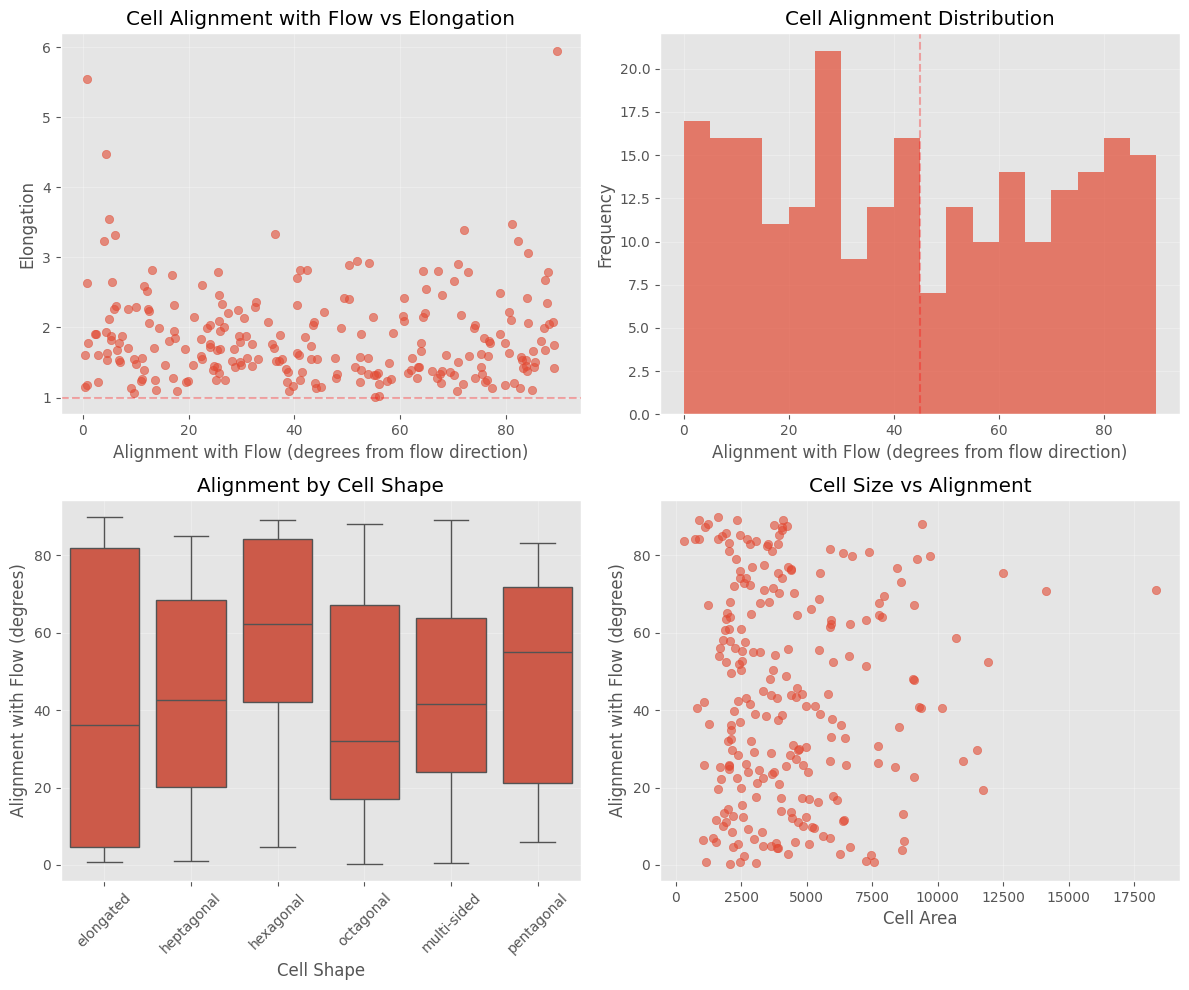


Cell Alignment Statistics:
Mean alignment with flow: 43.79°
Median alignment with flow: 41.52°
Aligned cells (within 30° of flow): 38.6%
Perpendicular cells (within 30° of perpendicular): 34.0%
Saved detailed metrics to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/cell_shape_metrics.csv
Saved summary statistics to /content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/sample_denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast/cell_shape_summary.json
Completed cell shape analysis for sample denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast


In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure, segmentation, feature
from scipy import ndimage
from collections import Counter
import tifffile
from pathlib import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            # Read image and ensure it's an integer type
            img = io.imread(filepath)

            # Convert boolean images to uint8
            if img.dtype == bool:
                img = img.astype(np.uint8)

            images[component] = img
            print(f"Loaded {component} image: shape {images[component].shape}, dtype: {images[component].dtype}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Enhanced function to analyze cell shapes with additional metrics
def analyze_cell_shapes(cell_image, nucleus_image=None):
    """
    Analyze cell shapes with enhanced metrics and morphological features.

    Parameters:
    cell_image: Label image of cells
    nucleus_image: Optional label image of nuclei for nuclear positioning analysis

    Returns:
    Dictionary with shape analysis results
    """
    # Ensure we have integer type image for regionprops
    if not np.issubdtype(cell_image.dtype, np.integer):
        print(f"Warning: cell_image is not integer type (dtype: {cell_image.dtype}). Converting...")
        cell_image = cell_image.astype(np.int32)

    # Debug info
    print(f"Cell image: dtype={cell_image.dtype}, min={np.min(cell_image)}, max={np.max(cell_image)}")

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        print("Cell image appears to be binary. Labeling regions...")
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)
        print(f"Found {num_regions} regions after labeling")

    cell_props = measure.regionprops(cell_image)

    # Prepare arrays for storing metrics
    cell_metrics = []
    cell_shapes = []
    cell_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation = np.degrees(cell_prop.orientation) % 180
        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Additional shape metrics
        # Circularity (1 for perfect circle, less as shape becomes less circular)
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

        # Solidity (ratio of area to convex hull area)
        solidity = cell_prop.solidity

        # Convexity (ratio of convex hull perimeter to perimeter)
        convex_image = cell_prop.convex_image
        convex_perimeter = measure.perimeter(convex_image)
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        # Rectangularity (ratio of area to bounding box area)
        min_row, min_col, max_row, max_col = cell_prop.bbox
        bbox_area = (max_row - min_row) * (max_col - min_col)
        rectangularity = area / bbox_area if bbox_area > 0 else 0

        # Elongation (major axis / minor axis)
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Compactness (another measure of circularity)
        compactness = np.sqrt(4 * area / np.pi) / major_axis_length if major_axis_length > 0 else 0

        # Approximation of the contour for shape classification
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        vertices = len(approx)

        # Shape classification based on vertices and metrics
        shape = classify_shape(vertices, circularity, elongation, rectangularity)
        cell_shapes.append(shape)

        # Check for nuclear position if nucleus image is provided
        nuclear_position = None
        nucleus_distance = None
        if nucleus_image is not None:
            nuclear_position, nucleus_distance = measure_nuclear_position(
                cell_image, nucleus_image, cell_id, centroid_x, centroid_y, major_axis_length
            )

        # Store all metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation': orientation,
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'convexity': convexity,
            'rectangularity': rectangularity,
            'elongation': elongation,
            'compactness': compactness,
            'vertices': vertices,
            'shape': shape
        }

        # Add nuclear metrics if available
        if nuclear_position is not None:
            metrics['nuclear_position'] = nuclear_position
            metrics['nucleus_distance'] = nucleus_distance

        cell_metrics.append(metrics)

    # Create summary statistics
    shape_distribution = Counter(cell_shapes)
    total_cells = len(cell_shapes)

    # Calculate averages and distributions of metrics
    avg_metrics = {}
    std_metrics = {}

    if cell_metrics:
        metrics_df = pd.DataFrame(cell_metrics)
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            avg_metrics[col] = metrics_df[col].mean()
            std_metrics[col] = metrics_df[col].std()

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'total_cells': total_cells,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'cell_contours': cell_contours
    }

    return results

# Helper function to classify cell shape
def classify_shape(vertices, circularity, elongation, rectangularity):
    """Classify cell shape based on geometric properties"""

    # First check circularity for round cells
    if circularity > 0.85:
        return "circular"

    # Check elongation for elongated cells
    if elongation > 3.0:
        return "elongated"

    # Check vertices for polygonal shapes
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        # Distinguish between rectangle and square
        if 0.85 < rectangularity < 1.15 and 0.85 < elongation < 1.15:
            return "square"
        else:
            return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8:
        return "multi-sided"

    # Default for irregular shapes
    return "irregular"

# Function to measure nuclear positioning within the cell
def measure_nuclear_position(cell_image, nucleus_image, cell_id, cell_x, cell_y, major_axis):
    """
    Determine the position of the nucleus within the cell.
    Returns a position category and distance metric.
    """
    # Create mask for the current cell
    cell_mask = cell_image == cell_id

    # Find nuclei that overlap with this cell
    nucleus_in_cell = np.unique(nucleus_image[cell_mask])
    # Remove background (0)
    nucleus_in_cell = nucleus_in_cell[nucleus_in_cell > 0]

    if len(nucleus_in_cell) == 0:
        return None, None

    # Use the largest nucleus if multiple are present
    if len(nucleus_in_cell) > 1:
        nucleus_sizes = [(n, np.sum(nucleus_image == n)) for n in nucleus_in_cell]
        nucleus_id = max(nucleus_sizes, key=lambda x: x[1])[0]
    else:
        nucleus_id = nucleus_in_cell[0]

    # Create a mask for just this nucleus and use it with regionprops
    nucleus_mask = (nucleus_image == nucleus_id).astype(np.uint8)
    nucleus_props = measure.regionprops(nucleus_mask)

    if not nucleus_props:
        return None, None

    nucleus_y, nucleus_x = nucleus_props[0].centroid

    # Calculate distance from nucleus to cell centroid
    distance = np.sqrt((nucleus_x - cell_x)**2 + (nucleus_y - cell_y)**2)

    # Normalize by cell size (major axis)
    normalized_distance = distance / (major_axis / 2) if major_axis > 0 else 0

    # Categorize position
    if normalized_distance < 0.2:
        position = "central"
    elif normalized_distance < 0.6:
        position = "intermediate"
    else:
        position = "peripheral"

    return position, normalized_distance

# Function to create shape visualizations
def visualize_cell_shapes(cell_image, shape_results, output_path=None):
    """Create visualizations for cell shape analysis"""

    # Create a colormap for different shapes
    shape_colors = {
        "circular": "blue",
        "elongated": "red",
        "triangular": "green",
        "square": "purple",
        "rectangular": "orange",
        "pentagonal": "cyan",
        "hexagonal": "magenta",
        "heptagonal": "lime",
        "octagonal": "brown",
        "multi-sided": "pink",
        "irregular": "gray"
    }

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original cell image with colored shapes
    colored_cells = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    for metrics in shape_results['all_metrics']:
        shape = metrics['shape']
        mask = cell_image == metrics['cell_id']

        # Get RGB color for this shape
        color_name = shape_colors.get(shape, "gray")
        color = np.array(plt.cm.colors.to_rgb(color_name)) * 255

        # Apply color to the mask
        for i in range(3):
            colored_cells[mask, i] = color[i]

    axes[0, 0].imshow(colored_cells)
    axes[0, 0].set_title("Cell Shapes")
    axes[0, 0].axis('off')

    # 2. Shape distribution
    shapes = list(shape_results['shape_distribution'].keys())
    counts = list(shape_results['shape_distribution'].values())
    colors = [shape_colors.get(shape, "gray") for shape in shapes]

    axes[0, 1].bar(shapes, counts, color=colors)
    axes[0, 1].set_title("Shape Distribution")
    axes[0, 1].set_xlabel("Cell Shape")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Circularity vs Elongation scatter plot
    if shape_results['all_metrics']:
        df = pd.DataFrame(shape_results['all_metrics'])
        scatter = axes[1, 0].scatter(
            df['circularity'],
            df['elongation'],
            c=[plt.cm.colors.to_rgba(shape_colors.get(shape, "gray")) for shape in df['shape']],
            alpha=0.7
        )

        axes[1, 0].set_title("Circularity vs Elongation")
        axes[1, 0].set_xlabel("Circularity")
        axes[1, 0].set_ylabel("Elongation")
        axes[1, 0].grid(True, alpha=0.3)

        # Add legend for shapes
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=shape_colors[shape], markersize=8, label=shape)
                  for shape in shape_colors if shape in df['shape'].values]
        axes[1, 0].legend(handles=handles, title="Shapes", loc='upper right')

    # 4. Cell size distribution
    if shape_results['all_metrics']:
        sns.histplot(df['area'], bins=20, kde=True, ax=axes[1, 1])
        axes[1, 1].set_title("Cell Size Distribution")
        axes[1, 1].set_xlabel("Cell Area (pixels)")
        axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

    # Additional visualization: Orientation rose plot
    if shape_results['all_metrics']:
        plt.figure(figsize=(8, 8))
        # Convert orientation to radians for the rose plot
        orientations = np.array([metrics['orientation'] for metrics in shape_results['all_metrics']])
        orientations_rad = np.radians(orientations)

        ax = plt.subplot(111, projection='polar')
        bins = np.linspace(0, np.pi, 19)  # 18 bins for 0-180 degrees

        # Create histogram
        hist, bin_edges = np.histogram(orientations_rad, bins=bins)

        # Plot rose diagram
        width = np.pi / 18
        bars = ax.bar(bin_edges[:-1], hist, width=width, bottom=0.0)

        # Color bars based on frequency
        for i, bar in enumerate(bars):
            bar.set_facecolor(plt.cm.viridis(i/len(bars)))
            bar.set_alpha(0.7)

        ax.set_theta_zero_location("N")  # Set 0 degrees at the top
        ax.set_theta_direction(-1)  # Go clockwise
        ax.set_thetamin(0)
        ax.set_thetamax(180)
        ax.set_title("Cell Orientation Rose Diagram", y=1.1)

        # Custom labels for degrees instead of radians
        ax.set_thetagrids(np.arange(0, 181, 20), np.arange(0, 181, 20))

        if output_path:
            orientation_output = output_path.replace('.png', '_orientation_rose.png')
            plt.savefig(orientation_output, dpi=300)
            print(f"Saved orientation rose diagram to {orientation_output}")

        plt.show()

    # Draw some example cells with their contours
    if shape_results['cell_contours'] and shape_results['all_metrics']:
        plt.figure(figsize=(15, 10))

        # Select up to 9 cells of different shapes to display
        unique_shapes = set(metrics['shape'] for metrics in shape_results['all_metrics'])
        examples = []

        for shape in unique_shapes:
            # Find cells with this shape
            matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                             if metrics['shape'] == shape]

            if matching_cells:
                # Pick the largest cell with this shape
                largest_idx = max(matching_cells,
                                 key=lambda i: shape_results['all_metrics'][i]['area'])
                examples.append((largest_idx, shape))

            # Limit to 9 examples
            if len(examples) >= 9:
                break

        # If we have less than 9 shapes, add more examples of common shapes
        if len(examples) < 9:
            common_shapes = sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True)

            for shape, _ in common_shapes:
                if len(examples) >= 9:
                    break

                # Check if we already have this shape
                if shape in [s for _, s in examples]:
                    # Find all cells with this shape
                    matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                                     if metrics['shape'] == shape]

                    # Filter out cells we've already selected
                    matching_cells = [i for i in matching_cells
                                     if i not in [idx for idx, _ in examples]]

                    if matching_cells:
                        # Sort by area and take the largest remaining
                        sorted_cells = sorted(matching_cells,
                                             key=lambda i: shape_results['all_metrics'][i]['area'],
                                             reverse=True)
                        examples.append((sorted_cells[0], shape))

        # Create subplots for each example
        n_examples = len(examples)
        rows = (n_examples + 2) // 3  # Ceiling division

        for i, (idx, shape) in enumerate(examples):
            ax = plt.subplot(rows, 3, i+1)

            # Get cell information
            cell_id = shape_results['all_metrics'][idx]['cell_id']
            contour = shape_results['cell_contours'][idx]

            # Create a mask for this cell
            mask = (cell_image == cell_id).astype(np.uint8) * 255

            # Display the mask
            ax.imshow(mask, cmap='gray')

            # Draw contour
            contour_reshaped = contour.reshape(-1, 2)
            ax.plot(contour_reshaped[:, 0], contour_reshaped[:, 1], 'r-', linewidth=2)

            # Add cell metrics
            metrics = shape_results['all_metrics'][idx]
            ax.set_title(f"{shape.capitalize()}")
            ax.text(0.05, 0.95, f"Area: {metrics['area']:.0f}\nCirc: {metrics['circularity']:.2f}\nElong: {metrics['elongation']:.2f}",
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            ax.axis('off')

        plt.tight_layout()

        if output_path:
            examples_output = output_path.replace('.png', '_examples.png')
            plt.savefig(examples_output, dpi=300)
            print(f"Saved cell examples to {examples_output}")

        plt.show()

# Function to analyze cell orientation with respect to flow direction
def analyze_cell_orientation(shape_results, output_path=None):
    """Analyze how cell orientation relates to assumed flow direction (left to right)"""

    if not shape_results['all_metrics']:
        print("No cell metrics available for orientation analysis")
        return

    # Create DataFrame from metrics
    df = pd.DataFrame(shape_results['all_metrics'])

    # Calculate orientation relative to flow (0 degrees is aligned with flow)
    # In image coordinates, 0/180 degrees is horizontal (aligned with flow)
    # and 90 degrees is vertical (perpendicular to flow)
    df['flow_alignment'] = np.minimum(df['orientation'], 180 - df['orientation'])

    # 0 means perfectly aligned with flow, 90 means perpendicular

    # Create visualization
    plt.figure(figsize=(12, 10))

    # 1. Plot orientation vs elongation
    plt.subplot(2, 2, 1)
    plt.scatter(df['flow_alignment'], df['elongation'], alpha=0.6)
    plt.title("Cell Alignment with Flow vs Elongation")
    plt.xlabel("Alignment with Flow (degrees from flow direction)")
    plt.ylabel("Elongation")
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)  # Line at elongation = 1
    plt.grid(True, alpha=0.3)

    # 2. Histogram of orientations
    plt.subplot(2, 2, 2)
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees
    plt.hist(df['flow_alignment'], bins=bins, alpha=0.7)
    plt.title("Cell Alignment Distribution")
    plt.xlabel("Alignment with Flow (degrees from flow direction)")
    plt.ylabel("Frequency")
    plt.axvline(x=45, color='r', linestyle='--', alpha=0.3)  # Line at 45 degrees
    plt.grid(True, alpha=0.3)

    # 3. Orientation by shape
    plt.subplot(2, 2, 3)
    sns.boxplot(x='shape', y='flow_alignment', data=df)
    plt.title("Alignment by Cell Shape")
    plt.xlabel("Cell Shape")
    plt.ylabel("Alignment with Flow (degrees)")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 4. Orientation by cell size
    plt.subplot(2, 2, 4)
    plt.scatter(df['area'], df['flow_alignment'], alpha=0.6)
    plt.title("Cell Size vs Alignment")
    plt.xlabel("Cell Area")
    plt.ylabel("Alignment with Flow (degrees)")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved orientation analysis to {output_path}")

    plt.show()

    # Calculate and return alignment statistics
    alignment_stats = {
        'mean_alignment': df['flow_alignment'].mean(),
        'median_alignment': df['flow_alignment'].median(),
        'std_alignment': df['flow_alignment'].std(),
        'aligned_fraction': np.mean(df['flow_alignment'] < 30),  # Fraction within 30° of flow
        'perpendicular_fraction': np.mean(df['flow_alignment'] > 60)  # Fraction within 30° of perpendicular
    }

    print("\nCell Alignment Statistics:")
    print(f"Mean alignment with flow: {alignment_stats['mean_alignment']:.2f}°")
    print(f"Median alignment with flow: {alignment_stats['median_alignment']:.2f}°")
    print(f"Aligned cells (within 30° of flow): {alignment_stats['aligned_fraction']*100:.1f}%")
    print(f"Perpendicular cells (within 30° of perpendicular): {alignment_stats['perpendicular_fraction']*100:.1f}%")

    return alignment_stats

# Function to process cell shape analysis for a sample
def process_cell_shape_analysis(sample_id, file_dict, output_dir):
    """Process cell shape analysis for a given sample"""
    print(f"\n=== Processing cell shape analysis for sample: {sample_id} ===")

    # Load images
    sample_images = load_sample_images(sample_id, file_dict)
    if not sample_images or 'cell' not in sample_images:
        print(f"Failed to load cell image for sample {sample_id}")
        return None

    # Create sample-specific output directory
    sample_dir = os.path.join(output_dir, f"sample_{sample_id}")
    os.makedirs(sample_dir, exist_ok=True)

    # Check if we have nucleus image for additional analysis
    nucleus_image = sample_images.get('nuclei', None)

    # Debug info about images
    print(f"\nCell image info: dtype={sample_images['cell'].dtype}, min={np.min(sample_images['cell'])}, max={np.max(sample_images['cell'])}")
    if nucleus_image is not None:
        print(f"Nucleus image info: dtype={nucleus_image.dtype}, min={np.min(nucleus_image)}, max={np.max(nucleus_image)}")

    # Ensure cell image is properly labeled
    cell_img = sample_images['cell']

    # Analyze cell shapes
    try:
        shape_results = analyze_cell_shapes(cell_img, nucleus_image)

        # Print basic statistics
        print(f"\nShape Analysis Results:")
        print(f"Total cells analyzed: {shape_results['total_cells']}")
        print("\nShape distribution:")
        for shape, count in shape_results['shape_distribution'].items():
            percentage = (count / shape_results['total_cells']) * 100 if shape_results['total_cells'] > 0 else 0
            print(f"  {shape}: {count} cells ({percentage:.1f}%)")

        print("\nAverage metrics:")
        for metric, value in shape_results['avg_metrics'].items():
            if metric not in ['cell_id', 'centroid_x', 'centroid_y', 'vertices']:
                print(f"  {metric}: {value:.3f}")

        # Create visualizations
        vis_output = os.path.join(sample_dir, "cell_shape_visualization.png")
        visualize_cell_shapes(cell_img, shape_results, vis_output)

        # Analyze cell orientation with respect to flow
        orientation_output = os.path.join(sample_dir, "cell_orientation_analysis.png")
        alignment_stats = analyze_cell_orientation(shape_results, orientation_output)

        # Save detailed metrics to CSV
        metrics_output = os.path.join(sample_dir, "cell_shape_metrics.csv")
        pd.DataFrame(shape_results['all_metrics']).to_csv(metrics_output, index=False)
        print(f"Saved detailed metrics to {metrics_output}")

        # Save summary statistics
        summary_stats = {
            'total_cells': shape_results['total_cells'],
            'shape_distribution': dict(shape_results['shape_distribution']),
            'avg_metrics': shape_results['avg_metrics'],
            'std_metrics': shape_results['std_metrics']
        }

        if alignment_stats:
            summary_stats['alignment_stats'] = alignment_stats

        summary_output = os.path.join(sample_dir, "cell_shape_summary.json")
        with open(summary_output, 'w') as f:
            import json
            json.dump(summary_stats, f, indent=2, default=str)
        print(f"Saved summary statistics to {summary_output}")

        return shape_results

    except Exception as e:
        print(f"Error during shape analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main function to run the pipeline
def main():
    # Find matching files
    file_dict, complete_samples = find_matching_files(base_dir)

    if not complete_samples:
        print("No complete samples found. Exiting.")
        return

    # Process the first sample
    sample_id = complete_samples[0]
    print(f"Processing sample {sample_id}")

    shape_results = process_cell_shape_analysis(sample_id, file_dict, output_dir)

    print(f"Completed cell shape analysis for sample {sample_id}")

    # To process all samples, uncomment the following code
    """
    for sample_id in complete_samples:
        print(f"\nProcessing sample {sample_id}")
        shape_results = process_cell_shape_analysis(sample_id, file_dict, output_dir)
        print(f"Completed cell shape analysis for sample {sample_id}")
    """

# Run the main function
if __name__ == "__main__":
    main()

In [15]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure, segmentation, feature, morphology
from scipy import ndimage
from collections import Counter
import tifffile
from pathlib import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            # Read image and ensure it's an integer type
            img = io.imread(filepath)

            # Convert boolean images to uint8
            if img.dtype == bool:
                img = img.astype(np.uint8)

            images[component] = img
            print(f"Loaded {component} image: shape {images[component].shape}, dtype: {images[component].dtype}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Function to preprocess cell masks to simplify shapes
def preprocess_cell_mask(mask, smooth_iterations=2, remove_small_objects=True):
    """
    Preprocess cell masks to simplify shapes by removing small protrusions and holes
    """
    # Apply morphological closing to fill small holes
    closed_mask = morphology.binary_closing(mask > 0)

    # Apply morphological opening to remove small protrusions
    opened_mask = morphology.binary_opening(closed_mask)

    # Optionally apply smoothing iterations
    smoothed_mask = opened_mask.copy()
    if smooth_iterations > 0:
        # Apply binary dilation and erosion to smooth boundaries
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_dilation(smoothed_mask)
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_erosion(smoothed_mask)

    # Remove small objects if requested
    if remove_small_objects:
        smoothed_mask = morphology.remove_small_objects(smoothed_mask, min_size=100)

    return smoothed_mask.astype(np.uint8)

# Function to cleanly extract a single cell contour
def extract_clean_contour(cell_mask, cell_id, smoothing=True):
    """
    Extract a clean, simplified contour for a single cell,
    removing small protrusions and simplifying the shape
    """
    # Extract the single cell mask
    mask = (cell_mask == cell_id).astype(np.uint8)

    # Preprocess the mask to simplify shape
    clean_mask = preprocess_cell_mask(mask, smooth_iterations=1)

    # Find contours of the cleaned mask
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Get the largest contour (in case there are multiple after cleaning)
    contour = max(contours, key=cv2.contourArea)

    # Optionally smooth the contour
    if smoothing:
        epsilon = 0.005 * cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, epsilon, True)

    return contour

# Enhanced function to analyze cell shapes with additional metrics
def analyze_cell_shapes(cell_image, nucleus_image=None):
    """
    Analyze cell shapes with enhanced metrics and morphological features.

    Parameters:
    cell_image: Label image of cells
    nucleus_image: Optional label image of nuclei for nuclear positioning analysis

    Returns:
    Dictionary with shape analysis results
    """
    # Ensure we have integer type image for regionprops
    if not np.issubdtype(cell_image.dtype, np.integer):
        print(f"Warning: cell_image is not integer type (dtype: {cell_image.dtype}). Converting...")
        cell_image = cell_image.astype(np.int32)

    # Debug info
    print(f"Cell image: dtype={cell_image.dtype}, min={np.min(cell_image)}, max={np.max(cell_image)}")

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        print("Cell image appears to be binary. Labeling regions...")
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)
        print(f"Found {num_regions} regions after labeling")

    cell_props = measure.regionprops(cell_image)

    # Prepare arrays for storing metrics
    cell_metrics = []
    cell_shapes = []
    cell_contours = []
    clean_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Generate a cleaned, simplified contour for shape analysis
        clean_contour = extract_clean_contour(cell_image, cell_id)
        if clean_contour is None:
            clean_contour = contour  # Fall back to original if cleaning fails
        clean_contours.append(clean_contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation_rad = cell_prop.orientation  # in radians

        # Convert to 0-90 degrees (for horizontal vs vertical alignment)
        # 0 degrees means perfectly horizontal, 90 degrees means perfectly vertical
        orientation_deg = np.degrees(orientation_rad) % 180
        if orientation_deg > 90:
            orientation_deg = 180 - orientation_deg

        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Additional shape metrics
        # Circularity (1 for perfect circle, less as shape becomes less circular)
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

        # Solidity (ratio of area to convex hull area)
        solidity = cell_prop.solidity

        # Convexity (ratio of convex hull perimeter to perimeter)
        convex_image = cell_prop.convex_image
        convex_perimeter = measure.perimeter(convex_image)
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        # Rectangularity (ratio of area to bounding box area)
        min_row, min_col, max_row, max_col = cell_prop.bbox
        bbox_area = (max_row - min_row) * (max_col - min_col)
        rectangularity = area / bbox_area if bbox_area > 0 else 0

        # Elongation (major axis / minor axis)
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Compactness (another measure of circularity)
        compactness = np.sqrt(4 * area / np.pi) / major_axis_length if major_axis_length > 0 else 0

        # Approximation of the contour for shape classification - use the clean contour
        peri = cv2.arcLength(clean_contour, True)
        approx = cv2.approxPolyDP(clean_contour, 0.02 * peri, True)
        vertices = len(approx)

        # Shape classification based on vertices and metrics
        shape = classify_shape(vertices, circularity, elongation, rectangularity, solidity)
        cell_shapes.append(shape)

        # Check for nuclear position if nucleus image is provided
        nuclear_position = None
        nucleus_distance = None
        if nucleus_image is not None:
            nuclear_position, nucleus_distance = measure_nuclear_position(
                cell_image, nucleus_image, cell_id, centroid_x, centroid_y, major_axis_length
            )

        # Calculate the horizontal/vertical alignment
        # 0 means perfectly horizontal, 1 means perfectly vertical
        horizontal_vertical_ratio = orientation_deg / 90.0

        # Store all metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation_rad': orientation_rad,
            'orientation_deg': orientation_deg,
            'horizontal_vertical_ratio': horizontal_vertical_ratio,  # 0=horizontal, 1=vertical
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'convexity': convexity,
            'rectangularity': rectangularity,
            'elongation': elongation,
            'compactness': compactness,
            'vertices': vertices,
            'shape': shape
        }

        # Add nuclear metrics if available
        if nuclear_position is not None:
            metrics['nuclear_position'] = nuclear_position
            metrics['nucleus_distance'] = nucleus_distance

        cell_metrics.append(metrics)

    # Create summary statistics
    shape_distribution = Counter(cell_shapes)
    total_cells = len(cell_shapes)

    # Calculate averages and distributions of metrics
    avg_metrics = {}
    std_metrics = {}

    if cell_metrics:
        metrics_df = pd.DataFrame(cell_metrics)
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            avg_metrics[col] = metrics_df[col].mean()
            std_metrics[col] = metrics_df[col].std()

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'total_cells': total_cells,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'cell_contours': cell_contours,
        'clean_contours': clean_contours
    }

    return results

# Improved function to classify cell shape using simplified contours
def classify_shape(vertices, circularity, elongation, rectangularity, solidity):
    """Classify cell shape based on geometric properties using a more robust approach"""

    # First check high elongation - this is a strong indicator
    if elongation > 2.5:
        return "elongated"

    # Check circularity for round cells
    if circularity > 0.8:
        return "circular"

    # Check solidity - helps identify irregular shapes with concavities
    if solidity < 0.85:
        return "irregular"

    # For high-solidity shapes, use vertices for classification
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        # Distinguish between rectangle and square
        if 0.85 < rectangularity and elongation < 1.2:
            return "square"
        else:
            return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8 and vertices <= 12:
        return "multi-sided"

    # Default for shapes with many vertices or that don't fit other categories
    if elongation > 1.5:
        return "elongated"
    elif circularity > 0.6:
        return "rounded"
    else:
        return "irregular"

# Function to measure nuclear positioning within the cell
def measure_nuclear_position(cell_image, nucleus_image, cell_id, cell_x, cell_y, major_axis):
    """
    Determine the position of the nucleus within the cell.
    Returns a position category and distance metric.
    """
    # Create mask for the current cell
    cell_mask = cell_image == cell_id

    # Find nuclei that overlap with this cell
    nucleus_in_cell = np.unique(nucleus_image[cell_mask])
    # Remove background (0)
    nucleus_in_cell = nucleus_in_cell[nucleus_in_cell > 0]

    if len(nucleus_in_cell) == 0:
        return None, None

    # Use the largest nucleus if multiple are present
    if len(nucleus_in_cell) > 1:
        nucleus_sizes = [(n, np.sum(nucleus_image == n)) for n in nucleus_in_cell]
        nucleus_id = max(nucleus_sizes, key=lambda x: x[1])[0]
    else:
        nucleus_id = nucleus_in_cell[0]

    # Create a mask for just this nucleus and use it with regionprops
    nucleus_mask = (nucleus_image == nucleus_id).astype(np.uint8)
    nucleus_props = measure.regionprops(nucleus_mask)

    if not nucleus_props:
        return None, None

    nucleus_y, nucleus_x = nucleus_props[0].centroid

    # Calculate distance from nucleus to cell centroid
    distance = np.sqrt((nucleus_x - cell_x)**2 + (nucleus_y - cell_y)**2)

    # Normalize by cell size (major axis)
    normalized_distance = distance / (major_axis / 2) if major_axis > 0 else 0

    # Categorize position
    if normalized_distance < 0.2:
        position = "central"
    elif normalized_distance < 0.6:
        position = "intermediate"
    else:
        position = "peripheral"

    return position, normalized_distance

# Function to create shape visualizations with improved contours
def visualize_cell_shapes(cell_image, shape_results, output_path=None):
    """Create visualizations for cell shape analysis using cleaned contours"""

    # Create a colormap for different shapes
    shape_colors = {
        "circular": "blue",
        "elongated": "red",
        "triangular": "green",
        "square": "purple",
        "rectangular": "orange",
        "pentagonal": "cyan",
        "hexagonal": "magenta",
        "heptagonal": "lime",
        "octagonal": "brown",
        "multi-sided": "pink",
        "irregular": "gray",
        "rounded": "skyblue"
    }

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original cell image with colored shapes
    colored_cells = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    for metrics in shape_results['all_metrics']:
        shape = metrics['shape']
        mask = cell_image == metrics['cell_id']

        # Get RGB color for this shape
        color_name = shape_colors.get(shape, "gray")
        color = np.array(plt.cm.colors.to_rgb(color_name)) * 255

        # Apply color to the mask
        for i in range(3):
            colored_cells[mask, i] = color[i]

    axes[0, 0].imshow(colored_cells)
    axes[0, 0].set_title("Cell Shapes")
    axes[0, 0].axis('off')

    # 2. Shape distribution
    shapes = list(shape_results['shape_distribution'].keys())
    counts = list(shape_results['shape_distribution'].values())
    colors = [shape_colors.get(shape, "gray") for shape in shapes]

    # Sort shapes by count
    shape_count_pairs = sorted(zip(shapes, counts, colors), key=lambda x: x[1], reverse=True)
    if shape_count_pairs:
        shapes, counts, colors = zip(*shape_count_pairs)
    else:
        shapes, counts, colors = [], [], []

    axes[0, 1].bar(shapes, counts, color=colors)
    axes[0, 1].set_title("Shape Distribution")
    axes[0, 1].set_xlabel("Cell Shape")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Horizontal vs Vertical orientation histogram
    if shape_results['all_metrics']:
        df = pd.DataFrame(shape_results['all_metrics'])

        # Use orientation_deg directly (0=horizontal, 90=vertical)
        sns.histplot(df['orientation_deg'], bins=18, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title("Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)")
        axes[1, 0].set_xlabel("Orientation (degrees)")
        axes[1, 0].set_ylabel("Frequency")
        axes[1, 0].axvline(x=45, color='r', linestyle='--', alpha=0.5, label="45° threshold")
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # 4. Horizontal-Vertical Ratio vs Elongation
    if shape_results['all_metrics']:
        scatter = axes[1, 1].scatter(
            df['elongation'],
            df['horizontal_vertical_ratio'],
            c=[plt.cm.colors.to_rgba(shape_colors.get(shape, "gray")) for shape in df['shape']],
            alpha=0.7
        )

        axes[1, 1].set_title("Elongation vs Orientation")
        axes[1, 1].set_xlabel("Elongation (major/minor axis)")
        axes[1, 1].set_ylabel("Orientation (0=Horizontal, 1=Vertical)")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="45° threshold")

        # Add legend for shapes
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=shape_colors[shape], markersize=8, label=shape)
                  for shape in shape_colors if shape in df['shape'].values]
        axes[1, 1].legend(handles=handles, title="Shapes", loc='upper right')

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

    # Additional visualization: Horizontal vs Vertical orientations
    if shape_results['all_metrics']:
        plt.figure(figsize=(12, 6))

        # Create bins representing 0-90 degrees (0=horizontal, 90=vertical)
        orientations = np.array([metrics['orientation_deg'] for metrics in shape_results['all_metrics']])

        # Calculate horizontal vs vertical percentages
        horizontal_cells = np.sum(orientations < 45) / len(orientations) * 100
        vertical_cells = 100 - horizontal_cells

        # Create bar chart
        plt.bar(['Horizontal\n(0-45°)', 'Vertical\n(45-90°)'],
                [horizontal_cells, vertical_cells],
                color=['cornflowerblue', 'indianred'])

        plt.title("Horizontal vs. Vertical Cell Orientation")
        plt.ylabel("Percentage of Cells")
        plt.ylim(0, 100)

        # Add percentage labels
        plt.text(0, horizontal_cells + 2, f"{horizontal_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')
        plt.text(1, vertical_cells + 2, f"{vertical_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)

        if output_path:
            horiz_vert_output = output_path.replace('.png', '_horiz_vert.png')
            plt.savefig(horiz_vert_output, dpi=300)
            print(f"Saved horizontal-vertical analysis to {horiz_vert_output}")

        plt.show()

    # Draw example cells with their contours (using cleaned contours)
    if shape_results['clean_contours'] and shape_results['all_metrics']:
        plt.figure(figsize=(15, 10))

        # Select up to 9 cells of different shapes to display
        unique_shapes = set(metrics['shape'] for metrics in shape_results['all_metrics'])
        examples = []

        for shape in unique_shapes:
            # Find cells with this shape
            matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                             if metrics['shape'] == shape]

            if matching_cells:
                # Pick the largest cell with this shape
                largest_idx = max(matching_cells,
                                 key=lambda i: shape_results['all_metrics'][i]['area'])
                examples.append((largest_idx, shape))

            # Limit to 9 examples
            if len(examples) >= 9:
                break

        # If we have less than 9 shapes, add more examples of common shapes
        if len(examples) < 9:
            common_shapes = sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True)

            for shape, _ in common_shapes:
                if len(examples) >= 9:
                    break

                # Check if we already have this shape
                if shape in [s for _, s in examples]:
                    # Find all cells with this shape
                    matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                                     if metrics['shape'] == shape]

                    # Filter out cells we've already selected
                    matching_cells = [i for i in matching_cells
                                     if i not in [idx for idx, _ in examples]]

                    if matching_cells:
                        # Sort by area and take the largest remaining
                        sorted_cells = sorted(matching_cells,
                                             key=lambda i: shape_results['all_metrics'][i]['area'],
                                             reverse=True)
                        examples.append((sorted_cells[0], shape))

        # Create subplots for each example
        n_examples = len(examples)
        rows = (n_examples + 2) // 3  # Ceiling division

        for i, (idx, shape) in enumerate(examples):
            ax = plt.subplot(rows, 3, i+1)

            # Get cell information
            cell_id = shape_results['all_metrics'][idx]['cell_id']
            clean_contour = shape_results['clean_contours'][idx]

            # Create a mask for this cell
            mask = (cell_image == cell_id).astype(np.uint8) * 255

            # Display the mask
            ax.imshow(mask, cmap='gray')

            # Draw contour
            contour_reshaped = clean_contour.reshape(-1, 2)
            ax.plot(contour_reshaped[:, 0], contour_reshaped[:, 1], 'r-', linewidth=2)

            # Add cell metrics
            metrics = shape_results['all_metrics'][idx]
            orientation_text = "H" if metrics['orientation_deg'] < 45 else "V"
            ax.set_title(f"{shape.capitalize()} ({orientation_text})")

            # Format metrics text
            metrics_text = f"Area: {metrics['area']:.0f}\n"
            metrics_text += f"Circ: {metrics['circularity']:.2f}\n"
            metrics_text += f"Elong: {metrics['elongation']:.2f}\n"
            metrics_text += f"Orient: {metrics['orientation_deg']:.1f}°"

            ax.text(0.05, 0.95, metrics_text,
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            ax.axis('off')

        plt.tight_layout()

        if output_path:
            examples_output = output_path.replace('.png', '_examples.png')
            plt.savefig(examples_output, dpi=300)
            print(f"Saved cell examples to {examples_output}")

        plt.show()

# Function to analyze cell orientation with focus on horizontal vs vertical alignment
def analyze_cell_orientation(shape_results, output_path=None):
    """
    Analyze how cell orientation relates to horizontal/vertical alignment
    (0° = horizontal/flow direction, 90° = vertical/perpendicular to flow)
    """

    if not shape_results['all_metrics']:
        print("No cell metrics available for orientation analysis")
        return

    # Create DataFrame from metrics
    df = pd.DataFrame(shape_results['all_metrics'])

    # Create visualization
    plt.figure(figsize=(12, 10))

    # 1. Horizontal-Vertical orientation distribution
    plt.subplot(2, 2, 1)
    # Create a normalized histogram
    orientation_degrees = df['orientation_deg'].values
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    plt.hist(orientation_degrees, bins=bins, alpha=0.7, density=True,
             color='cornflowerblue', edgecolor='black')
    plt.title("Cell Orientation Distribution")
    plt.xlabel("Orientation (0° = Horizontal, 90° = Vertical)")
    plt.ylabel("Density")
    plt.axvline(x=45, color='r', linestyle='--', alpha=0.3,
               label="45° threshold")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Orientation by shape
    plt.subplot(2, 2, 2)
    sns.boxplot(x='shape', y='orientation_deg', data=df)
    plt.title("Orientation by Cell Shape")
    plt.xlabel("Cell Shape")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # 4. Elongation vs orientation
    plt.subplot(2, 2, 4)
    plt.scatter(df['elongation'], df['orientation_deg'], alpha=0.6, c=df['circularity'], cmap='viridis')
    plt.colorbar(label='Circularity')
    plt.title("Elongation vs Orientation")
    plt.xlabel("Elongation (major/minor axis)")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved orientation analysis to {output_path}")

    plt.show()

    # Create a specific horizontal vs vertical analysis with percentages
    plt.figure(figsize=(10, 6))

    # Calculate percentages
    horizontal_cells = np.sum(df['orientation_deg'] < 30)
    aligned_cells = np.sum((df['orientation_deg'] >= 30) & (df['orientation_deg'] < 60))
    vertical_cells = np.sum(df['orientation_deg'] >= 60)

    total_cells = len(df)
    horizontal_pct = horizontal_cells / total_cells * 100
    aligned_pct = aligned_cells / total_cells * 100
    vertical_pct = vertical_cells / total_cells * 100

    # Create the bar chart
    categories = ['Horizontal\n(0-30°)', 'Intermediate\n(30-60°)', 'Vertical\n(60-90°)']
    values = [horizontal_pct, aligned_pct, vertical_pct]
    colors = ['cornflowerblue', 'lightgreen', 'indianred']

    bars = plt.bar(categories, values, color=colors)

    # Add percentage labels
    for bar, pct in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

    plt.title("Cell Orientation Distribution")
    plt.ylabel("Percentage of Cells")
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    if output_path:
        orientation_output = output_path.replace('.png', '_categories.png')
        plt.savefig(orientation_output, dpi=300)
        print(f"Saved orientation categories to {orientation_output}")

    plt.show()

    # Calculate and return orientation statistics
    orientation_stats = {
        'mean_orientation': df['orientation_deg'].mean(),
        'median_orientation': df['orientation_deg'].median(),
        'std_orientation': df['orientation_deg'].std(),
        'horizontal_pct': horizontal_pct,  # 0-30°
        'intermediate_pct': aligned_pct,   # 30-60°
        'vertical_pct': vertical_pct       # 60-90°
    }

    print("\nCell Orientation Statistics:")
    print(f"Mean orientation: {orientation_stats['mean_orientation']:.2f}°")
    print(f"Median orientation: {orientation_stats['median_orientation']:.2f}°")
    print(f"Horizontal cells (0-30°): {orientation_stats['horizontal_pct']:.1f}%")
    print(f"Intermediate cells (30-60°): {orientation_stats['intermediate_pct']:.1f}%")
    print(f"Vertical cells (60-90°): {orientation_stats['vertical_pct']:.1f}%")

    return orientation_stats)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. Orientation by cell size
    plt.subplot(2, 2, 3)
    plt.scatter(df['area'], df['orientation_deg'], alpha=0.6)
    plt.title("Cell Size vs Orientation")
    plt.xlabel("Cell Area")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3

SyntaxError: incomplete input (<ipython-input-15-2623c0710cb1>, line 790)

In [17]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure, segmentation, feature, morphology
from scipy import ndimage
from collections import Counter
import tifffile
from pathlib import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            # Read image and ensure it's an integer type
            img = io.imread(filepath)

            # Convert boolean images to uint8
            if img.dtype == bool:
                img = img.astype(np.uint8)

            images[component] = img
            print(f"Loaded {component} image: shape {images[component].shape}, dtype: {images[component].dtype}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Function to preprocess cell masks to simplify shapes
def preprocess_cell_mask(mask, smooth_iterations=2, remove_small_objects=True):
    """
    Preprocess cell masks to simplify shapes by removing small protrusions and holes
    """
    # Apply morphological closing to fill small holes
    closed_mask = morphology.binary_closing(mask > 0)

    # Apply morphological opening to remove small protrusions
    opened_mask = morphology.binary_opening(closed_mask)

    # Optionally apply smoothing iterations
    smoothed_mask = opened_mask.copy()
    if smooth_iterations > 0:
        # Apply binary dilation and erosion to smooth boundaries
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_dilation(smoothed_mask)
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_erosion(smoothed_mask)

    # Remove small objects if requested
    if remove_small_objects:
        smoothed_mask = morphology.remove_small_objects(smoothed_mask, min_size=100)

    return smoothed_mask.astype(np.uint8)

# Function to cleanly extract a single cell contour
def extract_clean_contour(cell_mask, cell_id, smoothing=True):
    """
    Extract a clean, simplified contour for a single cell,
    removing small protrusions and simplifying the shape
    """
    # Extract the single cell mask
    mask = (cell_mask == cell_id).astype(np.uint8)

    # Preprocess the mask to simplify shape
    clean_mask = preprocess_cell_mask(mask, smooth_iterations=1)

    # Find contours of the cleaned mask
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Get the largest contour (in case there are multiple after cleaning)
    contour = max(contours, key=cv2.contourArea)

    # Optionally smooth the contour
    if smoothing:
        epsilon = 0.005 * cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, epsilon, True)

    return contour

# Enhanced function to analyze cell shapes with additional metrics
def analyze_cell_shapes(cell_image, nucleus_image=None):
    """
    Analyze cell shapes with enhanced metrics and morphological features.

    Parameters:
    cell_image: Label image of cells
    nucleus_image: Optional label image of nuclei for nuclear positioning analysis

    Returns:
    Dictionary with shape analysis results
    """
    # Ensure we have integer type image for regionprops
    if not np.issubdtype(cell_image.dtype, np.integer):
        print(f"Warning: cell_image is not integer type (dtype: {cell_image.dtype}). Converting...")
        cell_image = cell_image.astype(np.int32)

    # Debug info
    print(f"Cell image: dtype={cell_image.dtype}, min={np.min(cell_image)}, max={np.max(cell_image)}")

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        print("Cell image appears to be binary. Labeling regions...")
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)
        print(f"Found {num_regions} regions after labeling")

    cell_props = measure.regionprops(cell_image)

    # Prepare arrays for storing metrics
    cell_metrics = []
    cell_shapes = []
    cell_contours = []
    clean_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Generate a cleaned, simplified contour for shape analysis
        clean_contour = extract_clean_contour(cell_image, cell_id)
        if clean_contour is None:
            clean_contour = contour  # Fall back to original if cleaning fails
        clean_contours.append(clean_contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation_rad = cell_prop.orientation  # in radians

        # Convert to 0-90 degrees (for horizontal vs vertical alignment)
        # 0 degrees means perfectly horizontal, 90 degrees means perfectly vertical
        orientation_deg = np.degrees(orientation_rad) % 180
        if orientation_deg > 90:
            orientation_deg = 180 - orientation_deg

        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Additional shape metrics
        # Circularity (1 for perfect circle, less as shape becomes less circular)
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

        # Solidity (ratio of area to convex hull area)
        solidity = cell_prop.solidity

        # Convexity (ratio of convex hull perimeter to perimeter)
        convex_image = cell_prop.convex_image
        convex_perimeter = measure.perimeter(convex_image)
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        # Rectangularity (ratio of area to bounding box area)
        min_row, min_col, max_row, max_col = cell_prop.bbox
        bbox_area = (max_row - min_row) * (max_col - min_col)
        rectangularity = area / bbox_area if bbox_area > 0 else 0

        # Elongation (major axis / minor axis)
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Compactness (another measure of circularity)
        compactness = np.sqrt(4 * area / np.pi) / major_axis_length if major_axis_length > 0 else 0

        # Approximation of the contour for shape classification - use the clean contour
        peri = cv2.arcLength(clean_contour, True)
        approx = cv2.approxPolyDP(clean_contour, 0.02 * peri, True)
        vertices = len(approx)

        # Shape classification based on vertices and metrics
        shape = classify_shape(vertices, circularity, elongation, rectangularity, solidity)
        cell_shapes.append(shape)

        # Check for nuclear position if nucleus image is provided
        nuclear_position = None
        nucleus_distance = None
        if nucleus_image is not None:
            nuclear_position, nucleus_distance = measure_nuclear_position(
                cell_image, nucleus_image, cell_id, centroid_x, centroid_y, major_axis_length
            )

        # Calculate the horizontal/vertical alignment
        # 0 means perfectly horizontal, 1 means perfectly vertical
        horizontal_vertical_ratio = orientation_deg / 90.0

        # Store all metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation_rad': orientation_rad,
            'orientation_deg': orientation_deg,
            'horizontal_vertical_ratio': horizontal_vertical_ratio,  # 0=horizontal, 1=vertical
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'convexity': convexity,
            'rectangularity': rectangularity,
            'elongation': elongation,
            'compactness': compactness,
            'vertices': vertices,
            'shape': shape
        }

        # Add nuclear metrics if available
        if nuclear_position is not None:
            metrics['nuclear_position'] = nuclear_position
            metrics['nucleus_distance'] = nucleus_distance

        cell_metrics.append(metrics)

    # Create summary statistics
    shape_distribution = Counter(cell_shapes)
    total_cells = len(cell_shapes)

    # Calculate averages and distributions of metrics
    avg_metrics = {}
    std_metrics = {}

    if cell_metrics:
        metrics_df = pd.DataFrame(cell_metrics)
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            avg_metrics[col] = metrics_df[col].mean()
            std_metrics[col] = metrics_df[col].std()

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'total_cells': total_cells,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'cell_contours': cell_contours,
        'clean_contours': clean_contours
    }

    return results

# Improved function to classify cell shape using simplified contours
def classify_shape(vertices, circularity, elongation, rectangularity, solidity):
    """Classify cell shape based on geometric properties using a more robust approach"""

    # First check high elongation - this is a strong indicator
    if elongation > 2.5:
        return "elongated"

    # Check circularity for round cells
    if circularity > 0.8:
        return "circular"

    # Check solidity - helps identify irregular shapes with concavities
    if solidity < 0.85:
        return "irregular"

    # For high-solidity shapes, use vertices for classification
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        # Distinguish between rectangle and square
        if 0.85 < rectangularity and elongation < 1.2:
            return "square"
        else:
            return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8 and vertices <= 12:
        return "multi-sided"

    # Default for shapes with many vertices or that don't fit other categories
    if elongation > 1.5:
        return "elongated"
    elif circularity > 0.6:
        return "rounded"
    else:
        return "irregular"

# Function to measure nuclear positioning within the cell
def measure_nuclear_position(cell_image, nucleus_image, cell_id, cell_x, cell_y, major_axis):
    """
    Determine the position of the nucleus within the cell.
    Returns a position category and distance metric.
    """
    # Create mask for the current cell
    cell_mask = cell_image == cell_id

    # Find nuclei that overlap with this cell
    nucleus_in_cell = np.unique(nucleus_image[cell_mask])
    # Remove background (0)
    nucleus_in_cell = nucleus_in_cell[nucleus_in_cell > 0]

    if len(nucleus_in_cell) == 0:
        return None, None

    # Use the largest nucleus if multiple are present
    if len(nucleus_in_cell) > 1:
        nucleus_sizes = [(n, np.sum(nucleus_image == n)) for n in nucleus_in_cell]
        nucleus_id = max(nucleus_sizes, key=lambda x: x[1])[0]
    else:
        nucleus_id = nucleus_in_cell[0]

    # Create a mask for just this nucleus and use it with regionprops
    nucleus_mask = (nucleus_image == nucleus_id).astype(np.uint8)
    nucleus_props = measure.regionprops(nucleus_mask)

    if not nucleus_props:
        return None, None

    nucleus_y, nucleus_x = nucleus_props[0].centroid

    # Calculate distance from nucleus to cell centroid
    distance = np.sqrt((nucleus_x - cell_x)**2 + (nucleus_y - cell_y)**2)

    # Normalize by cell size (major axis)
    normalized_distance = distance / (major_axis / 2) if major_axis > 0 else 0

    # Categorize position
    if normalized_distance < 0.2:
        position = "central"
    elif normalized_distance < 0.6:
        position = "intermediate"
    else:
        position = "peripheral"

    return position, normalized_distance

# Function to create shape visualizations with improved contours
def visualize_cell_shapes(cell_image, shape_results, output_path=None):
    """Create visualizations for cell shape analysis using cleaned contours"""

    # Create a colormap for different shapes
    shape_colors = {
        "circular": "blue",
        "elongated": "red",
        "triangular": "green",
        "square": "purple",
        "rectangular": "orange",
        "pentagonal": "cyan",
        "hexagonal": "magenta",
        "heptagonal": "lime",
        "octagonal": "brown",
        "multi-sided": "pink",
        "irregular": "gray",
        "rounded": "skyblue"
    }

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original cell image with colored shapes
    colored_cells = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    for metrics in shape_results['all_metrics']:
        shape = metrics['shape']
        mask = cell_image == metrics['cell_id']

        # Get RGB color for this shape
        color_name = shape_colors.get(shape, "gray")
        color = np.array(plt.cm.colors.to_rgb(color_name)) * 255

        # Apply color to the mask
        for i in range(3):
            colored_cells[mask, i] = color[i]

    axes[0, 0].imshow(colored_cells)
    axes[0, 0].set_title("Cell Shapes")
    axes[0, 0].axis('off')

    # 2. Shape distribution
    shapes = list(shape_results['shape_distribution'].keys())
    counts = list(shape_results['shape_distribution'].values())
    colors = [shape_colors.get(shape, "gray") for shape in shapes]

    # Sort shapes by count
    shape_count_pairs = sorted(zip(shapes, counts, colors), key=lambda x: x[1], reverse=True)
    if shape_count_pairs:
        shapes, counts, colors = zip(*shape_count_pairs)
    else:
        shapes, counts, colors = [], [], []

    axes[0, 1].bar(shapes, counts, color=colors)
    axes[0, 1].set_title("Shape Distribution")
    axes[0, 1].set_xlabel("Cell Shape")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Horizontal vs Vertical orientation histogram
    if shape_results['all_metrics']:
        df = pd.DataFrame(shape_results['all_metrics'])

        # Use orientation_deg directly (0=horizontal, 90=vertical)
        sns.histplot(df['orientation_deg'], bins=18, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title("Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)")
        axes[1, 0].set_xlabel("Orientation (degrees)")
        axes[1, 0].set_ylabel("Frequency")
        axes[1, 0].axvline(x=45, color='r', linestyle='--', alpha=0.5, label="45° threshold")
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # 4. Horizontal-Vertical Ratio vs Elongation
    if shape_results['all_metrics']:
        scatter = axes[1, 1].scatter(
            df['elongation'],
            df['horizontal_vertical_ratio'],
            c=[plt.cm.colors.to_rgba(shape_colors.get(shape, "gray")) for shape in df['shape']],
            alpha=0.7
        )

        axes[1, 1].set_title("Elongation vs Orientation")
        axes[1, 1].set_xlabel("Elongation (major/minor axis)")
        axes[1, 1].set_ylabel("Orientation (0=Horizontal, 1=Vertical)")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="45° threshold")

        # Add legend for shapes
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=shape_colors[shape], markersize=8, label=shape)
                  for shape in shape_colors if shape in df['shape'].values]
        axes[1, 1].legend(handles=handles, title="Shapes", loc='upper right')

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

    # Additional visualization: Horizontal vs Vertical orientations
    if shape_results['all_metrics']:
        plt.figure(figsize=(12, 6))

        # Create bins representing 0-90 degrees (0=horizontal, 90=vertical)
        orientations = np.array([metrics['orientation_deg'] for metrics in shape_results['all_metrics']])

        # Calculate horizontal vs vertical percentages
        horizontal_cells = np.sum(orientations < 45) / len(orientations) * 100
        vertical_cells = 100 - horizontal_cells

        # Create bar chart
        plt.bar(['Horizontal\n(0-45°)', 'Vertical\n(45-90°)'],
                [horizontal_cells, vertical_cells],
                color=['cornflowerblue', 'indianred'])

        plt.title("Horizontal vs. Vertical Cell Orientation")
        plt.ylabel("Percentage of Cells")
        plt.ylim(0, 100)

        # Add percentage labels
        plt.text(0, horizontal_cells + 2, f"{horizontal_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')
        plt.text(1, vertical_cells + 2, f"{vertical_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)

        if output_path:
            horiz_vert_output = output_path.replace('.png', '_horiz_vert.png')
            plt.savefig(horiz_vert_output, dpi=300)
            print(f"Saved horizontal-vertical analysis to {horiz_vert_output}")

        plt.show()

    # Draw example cells with their contours (using cleaned contours)
    if shape_results['clean_contours'] and shape_results['all_metrics']:
        plt.figure(figsize=(15, 10))

        # Select up to 9 cells of different shapes to display
        unique_shapes = set(metrics['shape'] for metrics in shape_results['all_metrics'])
        examples = []

        for shape in unique_shapes:
            # Find cells with this shape
            matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                             if metrics['shape'] == shape]

            if matching_cells:
                # Pick the largest cell with this shape
                largest_idx = max(matching_cells,
                                 key=lambda i: shape_results['all_metrics'][i]['area'])
                examples.append((largest_idx, shape))

            # Limit to 9 examples
            if len(examples) >= 9:
                break

        # If we have less than 9 shapes, add more examples of common shapes
        if len(examples) < 9:
            common_shapes = sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True)

            for shape, _ in common_shapes:
                if len(examples) >= 9:
                    break

                # Check if we already have this shape
                if shape in [s for _, s in examples]:
                    # Find all cells with this shape
                    matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                                     if metrics['shape'] == shape]

                    # Filter out cells we've already selected
                    matching_cells = [i for i in matching_cells
                                     if i not in [idx for idx, _ in examples]]

                    if matching_cells:
                        # Sort by area and take the largest remaining
                        sorted_cells = sorted(matching_cells,
                                             key=lambda i: shape_results['all_metrics'][i]['area'],
                                             reverse=True)
                        examples.append((sorted_cells[0], shape))

        # Create subplots for each example
        n_examples = len(examples)
        rows = (n_examples + 2) // 3  # Ceiling division

        for i, (idx, shape) in enumerate(examples):
            ax = plt.subplot(rows, 3, i+1)

            # Get cell information
            cell_id = shape_results['all_metrics'][idx]['cell_id']
            clean_contour = shape_results['clean_contours'][idx]

            # Create a mask for this cell
            mask = (cell_image == cell_id).astype(np.uint8) * 255

            # Display the mask
            ax.imshow(mask, cmap='gray')

            # Draw contour
            contour_reshaped = clean_contour.reshape(-1, 2)
            ax.plot(contour_reshaped[:, 0], contour_reshaped[:, 1], 'r-', linewidth=2)

            # Add cell metrics
            metrics = shape_results['all_metrics'][idx]
            orientation_text = "H" if metrics['orientation_deg'] < 45 else "V"
            ax.set_title(f"{shape.capitalize()} ({orientation_text})")

            # Format metrics text
            metrics_text = f"Area: {metrics['area']:.0f}\n"
            metrics_text += f"Circ: {metrics['circularity']:.2f}\n"
            metrics_text += f"Elong: {metrics['elongation']:.2f}\n"
            metrics_text += f"Orient: {metrics['orientation_deg']:.1f}°"

            ax.text(0.05, 0.95, metrics_text,
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            ax.axis('off')

        plt.tight_layout()

        if output_path:
            examples_output = output_path.replace('.png', '_examples.png')
            plt.savefig(examples_output, dpi=300)
            print(f"Saved cell examples to {examples_output}")

        plt.show()

# Function to analyze cell orientation with focus on horizontal vs vertical alignment
def analyze_cell_orientation(shape_results, output_path=None):
    """
    Analyze how cell orientation relates to horizontal/vertical alignment
    (0° = horizontal/flow direction, 90° = vertical/perpendicular to flow)
    """

    if not shape_results['all_metrics']:
        print("No cell metrics available for orientation analysis")
        return

    # Create DataFrame from metrics
    df = pd.DataFrame(shape_results['all_metrics'])

    # Create visualization
    plt.figure(figsize=(12, 10))

    # 1. Horizontal-Vertical orientation distribution
    plt.subplot(2, 2, 1)
    # Create a normalized histogram
    orientation_degrees = df['orientation_deg'].values
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    plt.hist(orientation_degrees, bins=bins, alpha=0.7, density=True,
             color='cornflowerblue', edgecolor='black')
    plt.title("Cell Orientation Distribution")
    plt.xlabel("Orientation (0° = Horizontal, 90° = Vertical)")
    plt.ylabel("Density")
    plt.axvline(x=45, color='r', linestyle='--', alpha=0.3,
               label="45° threshold")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Orientation by shape
    plt.subplot(2, 2, 2)
    sns.boxplot(x='shape', y='orientation_deg', data=df)
    plt.title("Orientation by Cell Shape")
    plt.xlabel("Cell Shape")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # 4. Elongation vs orientation
    plt.subplot(2, 2, 4)
    plt.scatter(df['elongation'], df['orientation_deg'], alpha=0.6, c=df['circularity'], cmap='viridis')
    plt.colorbar(label='Circularity')
    plt.title("Elongation vs Orientation")
    plt.xlabel("Elongation (major/minor axis)")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved orientation analysis to {output_path}")

    plt.show()

    # Create a specific horizontal vs vertical analysis with percentages
    plt.figure(figsize=(10, 6))

    # Calculate percentages
    horizontal_cells = np.sum(df['orientation_deg'] < 30)
    aligned_cells = np.sum((df['orientation_deg'] >= 30) & (df['orientation_deg'] < 60))
    vertical_cells = np.sum(df['orientation_deg'] >= 60)

    total_cells = len(df)
    horizontal_pct = horizontal_cells / total_cells * 100
    aligned_pct = aligned_cells / total_cells * 100
    vertical_pct = vertical_cells / total_cells * 100

    # Create the bar chart
    categories = ['Horizontal\n(0-30°)', 'Intermediate\n(30-60°)', 'Vertical\n(60-90°)']
    values = [horizontal_pct, aligned_pct, vertical_pct]
    colors = ['cornflowerblue', 'lightgreen', 'indianred']

    bars = plt.bar(categories, values, color=colors)

    # Add percentage labels
    for bar, pct in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

    plt.title("Cell Orientation Distribution")
    plt.ylabel("Percentage of Cells")
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    if output_path:
        orientation_output = output_path.replace('.png', '_categories.png')
        plt.savefig(orientation_output, dpi=300)
        print(f"Saved orientation categories to {orientation_output}")

    plt.show()

    # Calculate and return orientation statistics
    orientation_stats = {
        'mean_orientation': df['orientation_deg'].mean(),
        'median_orientation': df['orientation_deg'].median(),
        'std_orientation': df['orientation_deg'].std(),
        'horizontal_pct': horizontal_pct,  # 0-30°
        'intermediate_pct': aligned_pct,   # 30-60°
        'vertical_pct': vertical_pct       # 60-90°
    }

    print("\nCell Orientation Statistics:")
    print(f"Mean orientation: {orientation_stats['mean_orientation']:.2f}°")
    print(f"Median orientation: {orientation_stats['median_orientation']:.2f}°")
    print(f"Horizontal cells (0-30°): {orientation_stats['horizontal_pct']:.1f}%")
    print(f"Intermediate cells (30-60°): {orientation_stats['intermediate_pct']:.1f}%")
    print(f"Vertical cells (60-90°): {orientation_stats['vertical_pct']:.1f}%")

    return orientation_stats
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. Orientation by cell size
    plt.subplot(2, 2, 3)
    plt.scatter(df['area'], df['orientation_deg'], alpha=0.6)
    plt.title("Cell Size vs Orientation")
    plt.xlabel("Cell Area")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3

SyntaxError: incomplete input (<ipython-input-17-2623c0710cb1>, line 790)

In [23]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure, segmentation, feature, morphology
from scipy import ndimage
from collections import Counter
import tifffile
from pathlib import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            # Read image and ensure it's an integer type
            img = io.imread(filepath)

            # Convert boolean images to uint8
            if img.dtype == bool:
                img = img.astype(np.uint8)

            images[component] = img
            print(f"Loaded {component} image: shape {images[component].shape}, dtype: {images[component].dtype}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Function to preprocess cell masks to simplify shapes
def preprocess_cell_mask(mask, smooth_iterations=2, remove_small_objects=True):
    """
    Preprocess cell masks to simplify shapes by removing small protrusions and holes
    """
    # Apply morphological closing to fill small holes
    closed_mask = morphology.binary_closing(mask > 0)

    # Apply morphological opening to remove small protrusions
    opened_mask = morphology.binary_opening(closed_mask)

    # Optionally apply smoothing iterations
    smoothed_mask = opened_mask.copy()
    if smooth_iterations > 0:
        # Apply binary dilation and erosion to smooth boundaries
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_dilation(smoothed_mask)
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_erosion(smoothed_mask)

    # Remove small objects if requested
    if remove_small_objects:
        smoothed_mask = morphology.remove_small_objects(smoothed_mask, min_size=100)

    return smoothed_mask.astype(np.uint8)

# Function to cleanly extract a single cell contour
def extract_clean_contour(cell_mask, cell_id, smoothing=True):
    """
    Extract a clean, simplified contour for a single cell,
    removing small protrusions and simplifying the shape
    """
    # Extract the single cell mask
    mask = (cell_mask == cell_id).astype(np.uint8)

    # Preprocess the mask to simplify shape
    clean_mask = preprocess_cell_mask(mask, smooth_iterations=1)

    # Find contours of the cleaned mask
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Get the largest contour (in case there are multiple after cleaning)
    contour = max(contours, key=cv2.contourArea)

    # Optionally smooth the contour
    if smoothing:
        epsilon = 0.005 * cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, epsilon, True)

    return contour

# Enhanced function to analyze cell shapes with additional metrics
def analyze_cell_shapes(cell_image, nucleus_image=None):
    """
    Analyze cell shapes with enhanced metrics and morphological features.

    Parameters:
    cell_image: Label image of cells
    nucleus_image: Optional label image of nuclei for nuclear positioning analysis

    Returns:
    Dictionary with shape analysis results
    """
    # Ensure we have integer type image for regionprops
    if not np.issubdtype(cell_image.dtype, np.integer):
        print(f"Warning: cell_image is not integer type (dtype: {cell_image.dtype}). Converting...")
        cell_image = cell_image.astype(np.int32)

    # Debug info
    print(f"Cell image: dtype={cell_image.dtype}, min={np.min(cell_image)}, max={np.max(cell_image)}")

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        print("Cell image appears to be binary. Labeling regions...")
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)
        print(f"Found {num_regions} regions after labeling")

    cell_props = measure.regionprops(cell_image)

    # Prepare arrays for storing metrics
    cell_metrics = []
    cell_shapes = []
    cell_contours = []
    clean_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Generate a cleaned, simplified contour for shape analysis
        clean_contour = extract_clean_contour(cell_image, cell_id)
        if clean_contour is None:
            clean_contour = contour  # Fall back to original if cleaning fails
        clean_contours.append(clean_contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation_rad = cell_prop.orientation  # in radians

        # Convert to 0-90 degrees (for horizontal vs vertical alignment)
        # 0 degrees means perfectly horizontal, 90 degrees means perfectly vertical
        orientation_deg = np.degrees(orientation_rad) % 180
        if orientation_deg > 90:
            orientation_deg = 180 - orientation_deg

        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Additional shape metrics
        # Circularity (1 for perfect circle, less as shape becomes less circular)
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

        # Solidity (ratio of area to convex hull area)
        solidity = cell_prop.solidity

        # Convexity (ratio of convex hull perimeter to perimeter)
        convex_image = cell_prop.convex_image
        convex_perimeter = measure.perimeter(convex_image)
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        # Rectangularity (ratio of area to bounding box area)
        min_row, min_col, max_row, max_col = cell_prop.bbox
        bbox_area = (max_row - min_row) * (max_col - min_col)
        rectangularity = area / bbox_area if bbox_area > 0 else 0

        # Elongation (major axis / minor axis)
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Compactness (another measure of circularity)
        compactness = np.sqrt(4 * area / np.pi) / major_axis_length if major_axis_length > 0 else 0

        # Approximation of the contour for shape classification - use the clean contour
        peri = cv2.arcLength(clean_contour, True)
        approx = cv2.approxPolyDP(clean_contour, 0.02 * peri, True)
        vertices = len(approx)

        # Shape classification based on vertices and metrics
        shape = classify_shape(vertices, circularity, elongation, rectangularity, solidity)
        cell_shapes.append(shape)

        # Check for nuclear position if nucleus image is provided
        nuclear_position = None
        nucleus_distance = None
        if nucleus_image is not None:
            nuclear_position, nucleus_distance = measure_nuclear_position(
                cell_image, nucleus_image, cell_id, centroid_x, centroid_y, major_axis_length
            )

        # Calculate the horizontal/vertical alignment
        # 0 means perfectly horizontal, 1 means perfectly vertical
        horizontal_vertical_ratio = orientation_deg / 90.0

        # Store all metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation_rad': orientation_rad,
            'orientation_deg': orientation_deg,
            'horizontal_vertical_ratio': horizontal_vertical_ratio,  # 0=horizontal, 1=vertical
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'convexity': convexity,
            'rectangularity': rectangularity,
            'elongation': elongation,
            'compactness': compactness,
            'vertices': vertices,
            'shape': shape
        }

        # Add nuclear metrics if available
        if nuclear_position is not None:
            metrics['nuclear_position'] = nuclear_position
            metrics['nucleus_distance'] = nucleus_distance

        cell_metrics.append(metrics)

    # Create summary statistics
    shape_distribution = Counter(cell_shapes)
    total_cells = len(cell_shapes)

    # Calculate averages and distributions of metrics
    avg_metrics = {}
    std_metrics = {}

    if cell_metrics:
        metrics_df = pd.DataFrame(cell_metrics)
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            avg_metrics[col] = metrics_df[col].mean()
            std_metrics[col] = metrics_df[col].std()

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'total_cells': total_cells,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'cell_contours': cell_contours,
        'clean_contours': clean_contours
    }

    return results

# Improved function to classify cell shape using simplified contours
def classify_shape(vertices, circularity, elongation, rectangularity, solidity):
    """Classify cell shape based on geometric properties using a more robust approach"""

    # First check high elongation - this is a strong indicator
    if elongation > 2.5:
        return "elongated"

    # Check circularity for round cells
    if circularity > 0.8:
        return "circular"

    # Check solidity - helps identify irregular shapes with concavities
    if solidity < 0.85:
        return "irregular"

    # For high-solidity shapes, use vertices for classification
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        # Distinguish between rectangle and square
        if 0.85 < rectangularity and elongation < 1.2:
            return "square"
        else:
            return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8 and vertices <= 12:
        return "multi-sided"

    # Default for shapes with many vertices or that don't fit other categories
    if elongation > 1.5:
        return "elongated"
    elif circularity > 0.6:
        return "rounded"
    else:
        return "irregular"

# Function to measure nuclear positioning within the cell
def measure_nuclear_position(cell_image, nucleus_image, cell_id, cell_x, cell_y, major_axis):
    """
    Determine the position of the nucleus within the cell.
    Returns a position category and distance metric.
    """
    # Create mask for the current cell
    cell_mask = cell_image == cell_id

    # Find nuclei that overlap with this cell
    nucleus_in_cell = np.unique(nucleus_image[cell_mask])
    # Remove background (0)
    nucleus_in_cell = nucleus_in_cell[nucleus_in_cell > 0]

    if len(nucleus_in_cell) == 0:
        return None, None

    # Use the largest nucleus if multiple are present
    if len(nucleus_in_cell) > 1:
        nucleus_sizes = [(n, np.sum(nucleus_image == n)) for n in nucleus_in_cell]
        nucleus_id = max(nucleus_sizes, key=lambda x: x[1])[0]
    else:
        nucleus_id = nucleus_in_cell[0]

    # Create a mask for just this nucleus and use it with regionprops
    nucleus_mask = (nucleus_image == nucleus_id).astype(np.uint8)
    nucleus_props = measure.regionprops(nucleus_mask)

    if not nucleus_props:
        return None, None

    nucleus_y, nucleus_x = nucleus_props[0].centroid

    # Calculate distance from nucleus to cell centroid
    distance = np.sqrt((nucleus_x - cell_x)**2 + (nucleus_y - cell_y)**2)

    # Normalize by cell size (major axis)
    normalized_distance = distance / (major_axis / 2) if major_axis > 0 else 0

    # Categorize position
    if normalized_distance < 0.2:
        position = "central"
    elif normalized_distance < 0.6:
        position = "intermediate"
    else:
        position = "peripheral"

    return position, normalized_distance

# Function to create shape visualizations with improved contours
def visualize_cell_shapes(cell_image, shape_results, output_path=None):
    """Create visualizations for cell shape analysis using cleaned contours"""

    # Create a colormap for different shapes
    shape_colors = {
        "circular": "blue",
        "elongated": "red",
        "triangular": "green",
        "square": "purple",
        "rectangular": "orange",
        "pentagonal": "cyan",
        "hexagonal": "magenta",
        "heptagonal": "lime",
        "octagonal": "brown",
        "multi-sided": "pink",
        "irregular": "gray",
        "rounded": "skyblue"
    }

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original cell image with colored shapes
    colored_cells = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    for metrics in shape_results['all_metrics']:
        shape = metrics['shape']
        mask = cell_image == metrics['cell_id']

        # Get RGB color for this shape
        color_name = shape_colors.get(shape, "gray")
        color = np.array(plt.cm.colors.to_rgb(color_name)) * 255

        # Apply color to the mask
        for i in range(3):
            colored_cells[mask, i] = color[i]

    axes[0, 0].imshow(colored_cells)
    axes[0, 0].set_title("Cell Shapes")
    axes[0, 0].axis('off')

    # 2. Shape distribution
    shapes = list(shape_results['shape_distribution'].keys())
    counts = list(shape_results['shape_distribution'].values())
    colors = [shape_colors.get(shape, "gray") for shape in shapes]

    # Sort shapes by count
    shape_count_pairs = sorted(zip(shapes, counts, colors), key=lambda x: x[1], reverse=True)
    if shape_count_pairs:
        shapes, counts, colors = zip(*shape_count_pairs)
    else:
        shapes, counts, colors = [], [], []

    axes[0, 1].bar(shapes, counts, color=colors)
    axes[0, 1].set_title("Shape Distribution")
    axes[0, 1].set_xlabel("Cell Shape")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Horizontal vs Vertical orientation histogram
    if shape_results['all_metrics']:
        df = pd.DataFrame(shape_results['all_metrics'])

        # Use orientation_deg directly (0=horizontal, 90=vertical)
        sns.histplot(df['orientation_deg'], bins=18, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title("Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)")
        axes[1, 0].set_xlabel("Orientation (degrees)")
        axes[1, 0].set_ylabel("Frequency")
        axes[1, 0].axvline(x=45, color='r', linestyle='--', alpha=0.5, label="45° threshold")
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # 4. Horizontal-Vertical Ratio vs Elongation
    if shape_results['all_metrics']:
        scatter = axes[1, 1].scatter(
            df['elongation'],
            df['horizontal_vertical_ratio'],
            c=[plt.cm.colors.to_rgba(shape_colors.get(shape, "gray")) for shape in df['shape']],
            alpha=0.7
        )

        axes[1, 1].set_title("Elongation vs Orientation")
        axes[1, 1].set_xlabel("Elongation (major/minor axis)")
        axes[1, 1].set_ylabel("Orientation (0=Horizontal, 1=Vertical)")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="45° threshold")

        # Add legend for shapes
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=shape_colors[shape], markersize=8, label=shape)
                  for shape in shape_colors if shape in df['shape'].values]
        axes[1, 1].legend(handles=handles, title="Shapes", loc='upper right')

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

    # Additional visualization: Horizontal vs Vertical orientations
    if shape_results['all_metrics']:
        plt.figure(figsize=(12, 6))

        # Create bins representing 0-90 degrees (0=horizontal, 90=vertical)
        orientations = np.array([metrics['orientation_deg'] for metrics in shape_results['all_metrics']])

        # Calculate horizontal vs vertical percentages
        horizontal_cells = np.sum(orientations < 45) / len(orientations) * 100
        vertical_cells = 100 - horizontal_cells

        # Create bar chart
        plt.bar(['Horizontal\n(0-45°)', 'Vertical\n(45-90°)'],
                [horizontal_cells, vertical_cells],
                color=['cornflowerblue', 'indianred'])

        plt.title("Horizontal vs. Vertical Cell Orientation")
        plt.ylabel("Percentage of Cells")
        plt.ylim(0, 100)

        # Add percentage labels
        plt.text(0, horizontal_cells + 2, f"{horizontal_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')
        plt.text(1, vertical_cells + 2, f"{vertical_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)

        if output_path:
            horiz_vert_output = output_path.replace('.png', '_horiz_vert.png')
            plt.savefig(horiz_vert_output, dpi=300)
            print(f"Saved horizontal-vertical analysis to {horiz_vert_output}")

        plt.show()

    # Draw example cells with their contours (using cleaned contours)
    if shape_results['clean_contours'] and shape_results['all_metrics']:
        plt.figure(figsize=(15, 10))

        # Select up to 9 cells of different shapes to display
        unique_shapes = set(metrics['shape'] for metrics in shape_results['all_metrics'])
        examples = []

        for shape in unique_shapes:
            # Find cells with this shape
            matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                             if metrics['shape'] == shape]

            if matching_cells:
                # Pick the largest cell with this shape
                largest_idx = max(matching_cells,
                                 key=lambda i: shape_results['all_metrics'][i]['area'])
                examples.append((largest_idx, shape))

            # Limit to 9 examples
            if len(examples) >= 9:
                break

        # If we have less than 9 shapes, add more examples of common shapes
        if len(examples) < 9:
            common_shapes = sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True)

            for shape, _ in common_shapes:
                if len(examples) >= 9:
                    break

                # Check if we already have this shape
                if shape in [s for _, s in examples]:
                    # Find all cells with this shape
                    matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                                     if metrics['shape'] == shape]

                    # Filter out cells we've already selected
                    matching_cells = [i for i in matching_cells
                                     if i not in [idx for idx, _ in examples]]

                    if matching_cells:
                        # Sort by area and take the largest remaining
                        sorted_cells = sorted(matching_cells,
                                             key=lambda i: shape_results['all_metrics'][i]['area'],
                                             reverse=True)
                        examples.append((sorted_cells[0], shape))

        # Create subplots for each example
        n_examples = len(examples)
        rows = (n_examples + 2) // 3  # Ceiling division

        for i, (idx, shape) in enumerate(examples):
            ax = plt.subplot(rows, 3, i+1)

            # Get cell information
            cell_id = shape_results['all_metrics'][idx]['cell_id']
            clean_contour = shape_results['clean_contours'][idx]

            # Create a mask for this cell
            mask = (cell_image == cell_id).astype(np.uint8) * 255

            # Display the mask
            ax.imshow(mask, cmap='gray')

            # Draw contour
            contour_reshaped = clean_contour.reshape(-1, 2)
            ax.plot(contour_reshaped[:, 0], contour_reshaped[:, 1], 'r-', linewidth=2)

            # Add cell metrics
            metrics = shape_results['all_metrics'][idx]
            orientation_text = "H" if metrics['orientation_deg'] < 45 else "V"
            ax.set_title(f"{shape.capitalize()} ({orientation_text})")

            # Format metrics text
            metrics_text = f"Area: {metrics['area']:.0f}\n"
            metrics_text += f"Circ: {metrics['circularity']:.2f}\n"
            metrics_text += f"Elong: {metrics['elongation']:.2f}\n"
            metrics_text += f"Orient: {metrics['orientation_deg']:.1f}°"

            ax.text(0.05, 0.95, metrics_text,
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            ax.axis('off')

        plt.tight_layout()

        if output_path:
            examples_output = output_path.replace('.png', '_examples.png')
            plt.savefig(examples_output, dpi=300)
            print(f"Saved cell examples to {examples_output}")

        plt.show()

# Function to analyze cell orientation with focus on horizontal vs vertical alignment
def analyze_cell_orientation(shape_results, output_path=None):
    """
    Analyze how cell orientation relates to horizontal/vertical alignment
    (0° = horizontal/flow direction, 90° = vertical/perpendicular to flow)
    """

    if not shape_results['all_metrics']:
        print("No cell metrics available for orientation analysis")
        return

    # Create DataFrame from metrics
    df = pd.DataFrame(shape_results['all_metrics'])

    # Create visualization
    plt.figure(figsize=(12, 10))

    # 1. Horizontal-Vertical orientation distribution
    plt.subplot(2, 2, 1)
    # Create a normalized histogram
    orientation_degrees = df['orientation_deg'].values
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    plt.hist(orientation_degrees, bins=bins, alpha=0.7, density=True,
             color='cornflowerblue', edgecolor='black')
    plt.title("Cell Orientation Distribution")
    plt.xlabel("Orientation (0° = Horizontal, 90° = Vertical)")
    plt.ylabel("Density")
    plt.axvline(x=45, color='r', linestyle='--', alpha=0.3,
               label="45° threshold")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Orientation by shape
    plt.subplot(2, 2, 2)
    sns.boxplot(x='shape', y='orientation_deg', data=df)
    plt.title("Orientation by Cell Shape")
    plt.xlabel("Cell Shape")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # 4. Elongation vs orientation
    plt.subplot(2, 2, 4)
    plt.scatter(df['elongation'], df['orientation_deg'], alpha=0.6, c=df['circularity'], cmap='viridis')
    plt.colorbar(label='Circularity')
    plt.title("Elongation vs Orientation")
    plt.xlabel("Elongation (major/minor axis)")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved orientation analysis to {output_path}")

    plt.show()

    # Create a specific horizontal vs vertical analysis with percentages
    plt.figure(figsize=(10, 6))

    # Calculate percentages
    horizontal_cells = np.sum(df['orientation_deg'] < 30)
    aligned_cells = np.sum((df['orientation_deg'] >= 30) & (df['orientation_deg'] < 60))
    vertical_cells = np.sum(df['orientation_deg'] >= 60)

    total_cells = len(df)
    horizontal_pct = horizontal_cells / total_cells * 100
    aligned_pct = aligned_cells / total_cells * 100
    vertical_pct = vertical_cells / total_cells * 100

    # Create the bar chart
    categories = ['Horizontal\n(0-30°)', 'Intermediate\n(30-60°)', 'Vertical\n(60-90°)']
    values = [horizontal_pct, aligned_pct, vertical_pct]
    colors = ['cornflowerblue', 'lightgreen', 'indianred']

    bars = plt.bar(categories, values, color=colors)

    # Add percentage labels
    for bar, pct in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

    plt.title("Cell Orientation Distribution")
    plt.ylabel("Percentage of Cells")
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    if output_path:
        orientation_output = output_path.replace('.png', '_categories.png')
        plt.savefig(orientation_output, dpi=300)
        print(f"Saved orientation categories to {orientation_output}")

    plt.show()

    # Calculate and return orientation statistics
    orientation_stats = {
        'mean_orientation': df['orientation_deg'].mean(),
        'median_orientation': df['orientation_deg'].median(),
        'std_orientation': df['orientation_deg'].std(),
        'horizontal_pct': horizontal_pct,  # 0-30°
        'intermediate_pct': aligned_pct,   # 30-60°
        'vertical_pct': vertical_pct       # 60-90°
    }

    print("\nCell Orientation Statistics:")
    print(f"Mean orientation: {orientation_stats['mean_orientation']:.2f}°")
    print(f"Median orientation: {orientation_stats['median_orientation']:.2f}°")
    print(f"Horizontal cells (0-30°): {orientation_stats['horizontal_pct']:.1f}%")
    print(f"Intermediate cells (30-60°): {orientation_stats['intermediate_pct']:.1f}%")
    print(f"Vertical cells (60-90°): {orientation_stats['vertical_pct']:.1f}%")

    return orientation_stats
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. Orientation by cell size
    plt.subplot(2, 2, 3)
    plt.scatter(df['area'], df['orientation_deg'], alpha=0.6)
    plt.title("Cell Size vs Orientation")
    plt.xlabel("Cell Area")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure, segmentation, feature, morphology
from scipy import ndimage
from collections import Counter
import tifffile
from pathlib import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            # Read image and ensure it's an integer type
            img = io.imread(filepath)

            # Convert boolean images to uint8
            if img.dtype == bool:
                img = img.astype(np.uint8)

            images[component] = img
            print(f"Loaded {component} image: shape {images[component].shape}, dtype: {images[component].dtype}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Function to preprocess cell masks to simplify shapes
def preprocess_cell_mask(mask, smooth_iterations=2, remove_small_objects=True):
    """
    Preprocess cell masks to simplify shapes by removing small protrusions and holes
    """
    # Apply morphological closing to fill small holes
    closed_mask = morphology.binary_closing(mask > 0)

    # Apply morphological opening to remove small protrusions
    opened_mask = morphology.binary_opening(closed_mask)

    # Optionally apply smoothing iterations
    smoothed_mask = opened_mask.copy()
    if smooth_iterations > 0:
        # Apply binary dilation and erosion to smooth boundaries
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_dilation(smoothed_mask)
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_erosion(smoothed_mask)

    # Remove small objects if requested
    if remove_small_objects:
        smoothed_mask = morphology.remove_small_objects(smoothed_mask, min_size=100)

    return smoothed_mask.astype(np.uint8)

# Function to cleanly extract a single cell contour
def extract_clean_contour(cell_mask, cell_id, smoothing=True):
    """
    Extract a clean, simplified contour for a single cell,
    removing small protrusions and simplifying the shape
    """
    # Extract the single cell mask
    mask = (cell_mask == cell_id).astype(np.uint8)

    # Preprocess the mask to simplify shape
    clean_mask = preprocess_cell_mask(mask, smooth_iterations=1)

    # Find contours of the cleaned mask
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Get the largest contour (in case there are multiple after cleaning)
    contour = max(contours, key=cv2.contourArea)

    # Optionally smooth the contour
    if smoothing:
        epsilon = 0.005 * cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, epsilon, True)

    return contour

# Enhanced function to analyze cell shapes with additional metrics
def analyze_cell_shapes(cell_image, nucleus_image=None):
    """
    Analyze cell shapes with enhanced metrics and morphological features.

    Parameters:
    cell_image: Label image of cells
    nucleus_image: Optional label image of nuclei for nuclear positioning analysis

    Returns:
    Dictionary with shape analysis results
    """
    # Ensure we have integer type image for regionprops
    if not np.issubdtype(cell_image.dtype, np.integer):
        print(f"Warning: cell_image is not integer type (dtype: {cell_image.dtype}). Converting...")
        cell_image = cell_image.astype(np.int32)

    # Debug info
    print(f"Cell image: dtype={cell_image.dtype}, min={np.min(cell_image)}, max={np.max(cell_image)}")

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        print("Cell image appears to be binary. Labeling regions...")
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)
        print(f"Found {num_regions} regions after labeling")

    cell_props = measure.regionprops(cell_image)

    # Prepare arrays for storing metrics
    cell_metrics = []
    cell_shapes = []
    cell_contours = []
    clean_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Generate a cleaned, simplified contour for shape analysis
        clean_contour = extract_clean_contour(cell_image, cell_id)
        if clean_contour is None:
            clean_contour = contour  # Fall back to original if cleaning fails
        clean_contours.append(clean_contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation_rad = cell_prop.orientation  # in radians

        # Convert to 0-90 degrees (for horizontal vs vertical alignment)
        # 0 degrees means perfectly horizontal, 90 degrees means perfectly vertical
        orientation_deg = np.degrees(orientation_rad) % 180
        if orientation_deg > 90:
            orientation_deg = 180 - orientation_deg

        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Additional shape metrics
        # Circularity (1 for perfect circle, less as shape becomes less circular)
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

        # Solidity (ratio of area to convex hull area)
        solidity = cell_prop.solidity

        # Convexity (ratio of convex hull perimeter to perimeter)
        convex_image = cell_prop.convex_image
        convex_perimeter = measure.perimeter(convex_image)
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        # Rectangularity (ratio of area to bounding box area)
        min_row, min_col, max_row, max_col = cell_prop.bbox
        bbox_area = (max_row - min_row) * (max_col - min_col)
        rectangularity = area / bbox_area if bbox_area > 0 else 0

        # Elongation (major axis / minor axis)
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Compactness (another measure of circularity)
        compactness = np.sqrt(4 * area / np.pi) / major_axis_length if major_axis_length > 0 else 0

        # Approximation of the contour for shape classification - use the clean contour
        peri = cv2.arcLength(clean_contour, True)
        approx = cv2.approxPolyDP(clean_contour, 0.02 * peri, True)
        vertices = len(approx)

        # Shape classification based on vertices and metrics
        shape = classify_shape(vertices, circularity, elongation, rectangularity, solidity)
        cell_shapes.append(shape)

        # Check for nuclear position if nucleus image is provided
        nuclear_position = None
        nucleus_distance = None
        if nucleus_image is not None:
            nuclear_position, nucleus_distance = measure_nuclear_position(
                cell_image, nucleus_image, cell_id, centroid_x, centroid_y, major_axis_length
            )

        # Calculate the horizontal/vertical alignment
        # 0 means perfectly horizontal, 1 means perfectly vertical
        horizontal_vertical_ratio = orientation_deg / 90.0

        # Store all metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation_rad': orientation_rad,
            'orientation_deg': orientation_deg,
            'horizontal_vertical_ratio': horizontal_vertical_ratio,  # 0=horizontal, 1=vertical
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'convexity': convexity,
            'rectangularity': rectangularity,
            'elongation': elongation,
            'compactness': compactness,
            'vertices': vertices,
            'shape': shape
        }

        # Add nuclear metrics if available
        if nuclear_position is not None:
            metrics['nuclear_position'] = nuclear_position
            metrics['nucleus_distance'] = nucleus_distance

        cell_metrics.append(metrics)

    # Create summary statistics
    shape_distribution = Counter(cell_shapes)
    total_cells = len(cell_shapes)

    # Calculate averages and distributions of metrics
    avg_metrics = {}
    std_metrics = {}

    if cell_metrics:
        metrics_df = pd.DataFrame(cell_metrics)
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            avg_metrics[col] = metrics_df[col].mean()
            std_metrics[col] = metrics_df[col].std()

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'total_cells': total_cells,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'cell_contours': cell_contours,
        'clean_contours': clean_contours
    }

    return results

# Improved function to classify cell shape using simplified contours
def classify_shape(vertices, circularity, elongation, rectangularity, solidity):
    """Classify cell shape based on geometric properties using a more robust approach"""

    # First check high elongation - this is a strong indicator
    if elongation > 2.5:
        return "elongated"

    # Check circularity for round cells
    if circularity > 0.8:
        return "circular"

    # Check solidity - helps identify irregular shapes with concavities
    if solidity < 0.85:
        return "irregular"

    # For high-solidity shapes, use vertices for classification
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        # Distinguish between rectangle and square
        if 0.85 < rectangularity and elongation < 1.2:
            return "square"
        else:
            return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8 and vertices <= 12:
        return "multi-sided"

    # Default for shapes with many vertices or that don't fit other categories
    if elongation > 1.5:
        return "elongated"
    elif circularity > 0.6:
        return "rounded"
    else:
        return "irregular"

# Function to measure nuclear positioning within the cell
def measure_nuclear_position(cell_image, nucleus_image, cell_id, cell_x, cell_y, major_axis):
    """
    Determine the position of the nucleus within the cell.
    Returns a position category and distance metric.
    """
    # Create mask for the current cell
    cell_mask = cell_image == cell_id

    # Find nuclei that overlap with this cell
    nucleus_in_cell = np.unique(nucleus_image[cell_mask])
    # Remove background (0)
    nucleus_in_cell = nucleus_in_cell[nucleus_in_cell > 0]

    if len(nucleus_in_cell) == 0:
        return None, None

    # Use the largest nucleus if multiple are present
    if len(nucleus_in_cell) > 1:
        nucleus_sizes = [(n, np.sum(nucleus_image == n)) for n in nucleus_in_cell]
        nucleus_id = max(nucleus_sizes, key=lambda x: x[1])[0]
    else:
        nucleus_id = nucleus_in_cell[0]

    # Create a mask for just this nucleus and use it with regionprops
    nucleus_mask = (nucleus_image == nucleus_id).astype(np.uint8)
    nucleus_props = measure.regionprops(nucleus_mask)

    if not nucleus_props:
        return None, None

    nucleus_y, nucleus_x = nucleus_props[0].centroid

    # Calculate distance from nucleus to cell centroid
    distance = np.sqrt((nucleus_x - cell_x)**2 + (nucleus_y - cell_y)**2)

    # Normalize by cell size (major axis)
    normalized_distance = distance / (major_axis / 2) if major_axis > 0 else 0

    # Categorize position
    if normalized_distance < 0.2:
        position = "central"
    elif normalized_distance < 0.6:
        position = "intermediate"
    else:
        position = "peripheral"

    return position, normalized_distance

# Function to create shape visualizations with improved contours
def visualize_cell_shapes(cell_image, shape_results, output_path=None):
    """Create visualizations for cell shape analysis using cleaned contours"""

    # Create a colormap for different shapes
    shape_colors = {
        "circular": "blue",
        "elongated": "red",
        "triangular": "green",
        "square": "purple",
        "rectangular": "orange",
        "pentagonal": "cyan",
        "hexagonal": "magenta",
        "heptagonal": "lime",
        "octagonal": "brown",
        "multi-sided": "pink",
        "irregular": "gray",
        "rounded": "skyblue"
    }

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original cell image with colored shapes
    colored_cells = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    for metrics in shape_results['all_metrics']:
        shape = metrics['shape']
        mask = cell_image == metrics['cell_id']

        # Get RGB color for this shape
        color_name = shape_colors.get(shape, "gray")
        color = np.array(plt.cm.colors.to_rgb(color_name)) * 255

        # Apply color to the mask
        for i in range(3):
            colored_cells[mask, i] = color[i]

    axes[0, 0].imshow(colored_cells)
    axes[0, 0].set_title("Cell Shapes")
    axes[0, 0].axis('off')

    # 2. Shape distribution
    shapes = list(shape_results['shape_distribution'].keys())
    counts = list(shape_results['shape_distribution'].values())
    colors = [shape_colors.get(shape, "gray") for shape in shapes]

    # Sort shapes by count
    shape_count_pairs = sorted(zip(shapes, counts, colors), key=lambda x: x[1], reverse=True)
    if shape_count_pairs:
        shapes, counts, colors = zip(*shape_count_pairs)
    else:
        shapes, counts, colors = [], [], []

    axes[0, 1].bar(shapes, counts, color=colors)
    axes[0, 1].set_title("Shape Distribution")
    axes[0, 1].set_xlabel("Cell Shape")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Horizontal vs Vertical orientation histogram
    if shape_results['all_metrics']:
        df = pd.DataFrame(shape_results['all_metrics'])

        # Use orientation_deg directly (0=horizontal, 90=vertical)
        sns.histplot(df['orientation_deg'], bins=18, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title("Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)")
        axes[1, 0].set_xlabel("Orientation (degrees)")
        axes[1, 0].set_ylabel("Frequency")
        axes[1, 0].axvline(x=45, color='r', linestyle='--', alpha=0.5, label="45° threshold")
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # 4. Horizontal-Vertical Ratio vs Elongation
    if shape_results['all_metrics']:
        scatter = axes[1, 1].scatter(
            df['elongation'],
            df['horizontal_vertical_ratio'],
            c=[plt.cm.colors.to_rgba(shape_colors.get(shape, "gray")) for shape in df['shape']],
            alpha=0.7
        )

        axes[1, 1].set_title("Elongation vs Orientation")
        axes[1, 1].set_xlabel("Elongation (major/minor axis)")
        axes[1, 1].set_ylabel("Orientation (0=Horizontal, 1=Vertical)")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="45° threshold")

        # Add legend for shapes
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=shape_colors[shape], markersize=8, label=shape)
                  for shape in shape_colors if shape in df['shape'].values]
        axes[1, 1].legend(handles=handles, title="Shapes", loc='upper right')

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

    # Additional visualization: Horizontal vs Vertical orientations
    if shape_results['all_metrics']:
        plt.figure(figsize=(12, 6))

        # Create bins representing 0-90 degrees (0=horizontal, 90=vertical)
        orientations = np.array([metrics['orientation_deg'] for metrics in shape_results['all_metrics']])

        # Calculate horizontal vs vertical percentages
        horizontal_cells = np.sum(orientations < 45) / len(orientations) * 100
        vertical_cells = 100 - horizontal_cells

        # Create bar chart
        plt.bar(['Horizontal\n(0-45°)', 'Vertical\n(45-90°)'],
                [horizontal_cells, vertical_cells],
                color=['cornflowerblue', 'indianred'])

        plt.title("Horizontal vs. Vertical Cell Orientation")
        plt.ylabel("Percentage of Cells")
        plt.ylim(0, 100)

        # Add percentage labels
        plt.text(0, horizontal_cells + 2, f"{horizontal_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')
        plt.text(1, vertical_cells + 2, f"{vertical_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)

        if output_path:
            horiz_vert_output = output_path.replace('.png', '_horiz_vert.png')
            plt.savefig(horiz_vert_output, dpi=300)
            print(f"Saved horizontal-vertical analysis to {horiz_vert_output}")

        plt.show()

    # Draw example cells with their contours (using cleaned contours)
    if shape_results['clean_contours'] and shape_results['all_metrics']:
        plt.figure(figsize=(15, 10))

        # Select up to 9 cells of different shapes to display
        unique_shapes = set(metrics['shape'] for metrics in shape_results['all_metrics'])
        examples = []

        for shape in unique_shapes:
            # Find cells with this shape
            matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                             if metrics['shape'] == shape]

            if matching_cells:
                # Pick the largest cell with this shape
                largest_idx = max(matching_cells,
                                 key=lambda i: shape_results['all_metrics'][i]['area'])
                examples.append((largest_idx, shape))

            # Limit to 9 examples
            if len(examples) >= 9:
                break

        # If we have less than 9 shapes, add more examples of common shapes
        if len(examples) < 9:
            common_shapes = sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True)

            for shape, _ in common_shapes:
                if len(examples) >= 9:
                    break

                # Check if we already have this shape
                if shape in [s for _, s in examples]:
                    # Find all cells with this shape
                    matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                                     if metrics['shape'] == shape]

                    # Filter out cells we've already selected
                    matching_cells = [i for i in matching_cells
                                     if i not in [idx for idx, _ in examples]]

                    if matching_cells:
                        # Sort by area and take the largest remaining
                        sorted_cells = sorted(matching_cells,
                                             key=lambda i: shape_results['all_metrics'][i]['area'],
                                             reverse=True)
                        examples.append((sorted_cells[0], shape))

        # Create subplots for each example
        n_examples = len(examples)
        rows = (n_examples + 2) // 3  # Ceiling division

        for i, (idx, shape) in enumerate(examples):
            ax = plt.subplot(rows, 3, i+1)

            # Get cell information
            cell_id = shape_results['all_metrics'][idx]['cell_id']
            clean_contour = shape_results['clean_contours'][idx]

            # Create a mask for this cell
            mask = (cell_image == cell_id).astype(np.uint8) * 255

            # Display the mask
            ax.imshow(mask, cmap='gray')

            # Draw contour
            contour_reshaped = clean_contour.reshape(-1, 2)
            ax.plot(contour_reshaped[:, 0], contour_reshaped[:, 1], 'r-', linewidth=2)

            # Add cell metrics
            metrics = shape_results['all_metrics'][idx]
            orientation_text = "H" if metrics['orientation_deg'] < 45 else "V"
            ax.set_title(f"{shape.capitalize()} ({orientation_text})")

            # Format metrics text
            metrics_text = f"Area: {metrics['area']:.0f}\n"
            metrics_text += f"Circ: {metrics['circularity']:.2f}\n"
            metrics_text += f"Elong: {metrics['elongation']:.2f}\n"
            metrics_text += f"Orient: {metrics['orientation_deg']:.1f}°"

            ax.text(0.05, 0.95, metrics_text,
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            ax.axis('off')

        plt.tight_layout()

        if output_path:
            examples_output = output_path.replace('.png', '_examples.png')
            plt.savefig(examples_output, dpi=300)
            print(f"Saved cell examples to {examples_output}")

        plt.show()

# Function to analyze cell orientation with focus on horizontal vs vertical alignment
def analyze_cell_orientation(shape_results, output_path=None):
    """
    Analyze how cell orientation relates to horizontal/vertical alignment
    (0° = horizontal/flow direction, 90° = vertical/perpendicular to flow)
    """

    if not shape_results['all_metrics']:
        print("No cell metrics available for orientation analysis")
        return

    # Create DataFrame from metrics
    df = pd.DataFrame(shape_results['all_metrics'])

    # Create visualization
    plt.figure(figsize=(12, 10))

    # 1. Horizontal-Vertical orientation distribution
    plt.subplot(2, 2, 1)
    # Create a normalized histogram
    orientation_degrees = df['orientation_deg'].values
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    plt.hist(orientation_degrees, bins=bins, alpha=0.7, density=True,
             color='cornflowerblue', edgecolor='black')
    plt.title("Cell Orientation Distribution")
    plt.xlabel("Orientation (0° = Horizontal, 90° = Vertical)")
    plt.ylabel("Density")
    plt.axvline(x=45, color='r', linestyle='--', alpha=0.3,
               label="45° threshold")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Orientation by shape
    plt.subplot(2, 2, 2)
    sns.boxplot(x='shape', y='orientation_deg', data=df)
    plt.title("Orientation by Cell Shape")
    plt.xlabel("Cell Shape")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. Orientation by cell size
    plt.subplot(2, 2, 3)
    plt.scatter(df['area'], df['orientation_deg'], alpha=0.6)
    plt.title("Cell Size vs Orientation")
    plt.xlabel("Cell Area")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # 4. Elongation vs orientation
    plt.subplot(2, 2, 4)
    plt.scatter(df['elongation'], df['orientation_deg'], alpha=0.6, c=df['circularity'], cmap='viridis')
    plt.colorbar(label='Circularity')
    plt.title("Elongation vs Orientation")
    plt.xlabel("Elongation (major/minor axis)")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved orientation analysis to {output_path}")

    plt.show()

    # Create a specific horizontal vs vertical analysis with percentages
    plt.figure(figsize=(10, 6))

    # Calculate percentages
    horizontal_cells = np.sum(df['orientation_deg'] < 30)
    aligned_cells = np.sum((df['orientation_deg'] >= 30) & (df['orientation_deg'] < 60))
    vertical_cells = np.sum(df['orientation_deg'] >= 60)

    total_cells = len(df)
    horizontal_pct = horizontal_cells / total_cells * 100
    aligned_pct = aligned_cells / total_cells * 100
    vertical_pct = vertical_cells / total_cells * 100

    # Create the bar chart
    categories = ['Horizontal\n(0-30°)', 'Intermediate\n(30-60°)', 'Vertical\n(60-90°)']
    values = [horizontal_pct, aligned_pct, vertical_pct]
    colors = ['cornflowerblue', 'lightgreen', 'indianred']

    bars = plt.bar(categories, values, color=colors)

    # Add percentage labels
    for bar, pct in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f"{pct:.1f}%", ha='center', va='bottom', fontweight='bold')

    plt.title("Cell Orientation Distribution")
    plt.ylabel("Percentage of Cells")
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)

    if output_path:
        orientation_output = output_path.replace('.png', '_categories.png')
        plt.savefig(orientation_output, dpi=300)
        print(f"Saved orientation categories to {orientation_output}")

    plt.show()

    # Calculate and return orientation statistics
    orientation_stats = {
        'mean_orientation': df['orientation_deg'].mean(),
        'median_orientation': df['orientation_deg'].median(),
        'std_orientation': df['orientation_deg'].std(),
        'horizontal_pct': horizontal_pct,  # 0-30°
        'intermediate_pct': aligned_pct,   # 30-60°
        'vertical_pct': vertical_pct       # 60-90°
    }

    print("\nCell Orientation Statistics:")
    print(f"Mean orientation: {orientation_stats['mean_orientation']:.2f}°")
    print(f"Median orientation: {orientation_stats['median_orientation']:.2f}°")
    print(f"Horizontal cells (0-30°): {orientation_stats['horizontal_pct']:.1f}%")
    print(f"Intermediate cells (30-60°): {orientation_stats['intermediate_pct']:.1f}%")
    print(f"Vertical cells (60-90°): {orientation_stats['vertical_pct']:.1f}%")

    return orientation_stats

# Main execution code
if __name__ == "__main__":
    print("Starting cell shape analysis...")

    # Step 1: Find all matching files across different folders
    file_dict, complete_samples = find_matching_files(base_dir)

    # Print samples found for user to check
    print("\nComplete samples found:")
    for i, sample_id in enumerate(complete_samples):
        print(f"{i+1}. {sample_id}")

    # Step 2: Process each sample
    for sample_id in complete_samples:
        print(f"\n\nProcessing sample: {sample_id}")

        # Create sample-specific output directory
        sample_output_dir = os.path.join(output_dir, sample_id)
        os.makedirs(sample_output_dir, exist_ok=True)

        # Load all images for this sample
        images = load_sample_images(sample_id, file_dict)

        # Check if we have the required images
        if 'cell' not in images:
            print(f"Warning: Cell mask not found for {sample_id}, skipping analysis.")
            continue

        # Create filenames for outputs
        shape_output_path = os.path.join(sample_output_dir, f"{sample_id}_shapes.png")
        orientation_output_path = os.path.join(sample_output_dir, f"{sample_id}_orientation.png")

        # Analyze cell shapes
        print(f"Analyzing cell shapes for {sample_id}...")
        nucleus_image = images.get('nuclei', None)
        shape_results = analyze_cell_shapes(images['cell'], nucleus_image)

        print(f"Found {shape_results['total_cells']} cells")

        # Log shape distribution
        print("\nShape distribution:")
        for shape, count in sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True):
            percentage = (count / shape_results['total_cells']) * 100
            print(f"{shape}: {count} cells ({percentage:.1f}%)")

        # Save shape metrics to CSV
        if shape_results['all_metrics']:
            metrics_df = pd.DataFrame(shape_results['all_metrics'])
            metrics_file = os.path.join(sample_output_dir, f"{sample_id}_metrics.csv")
            metrics_df.to_csv(metrics_file, index=False)
            print(f"Saved metrics to {metrics_file}")

        # Visualize cell shapes
        print("Generating shape visualization...")
        visualize_cell_shapes(images['cell'], shape_results, shape_output_path)

        # Analyze cell orientation
        print("Analyzing cell orientation...")
        orientation_stats = analyze_cell_orientation(shape_results, orientation_output_path)

        # Save orientation stats to CSV
        if orientation_stats:
            orientation_df = pd.DataFrame([orientation_stats])
            orientation_file = os.path.join(sample_output_dir, f"{sample_id}_orientation_stats.csv")
            orientation_df.to_csv(orientation_file, index=False)
            print(f"Saved orientation stats to {orientation_file}")

        print(f"Completed analysis for {sample_id}")

    print("\nCell shape analysis completed for all samples.")

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from skimage import measure, morphology, segmentation
import pandas as pd
from pathlib import Path

def voronoi_regularize_cells(cell_mask, min_area=100, boundary_buffer=5, visualize=True):
    """
    Regularize cell shapes using Voronoi diagrams.

    Parameters:
    -----------
    cell_mask : ndarray
        Labeled cell mask (integer type where each cell has a unique ID)
    min_area : int
        Minimum area for a cell to be considered
    boundary_buffer : int
        Buffer distance from image boundary for Voronoi computation
    visualize : bool
        Whether to generate visualization of the results

    Returns:
    --------
    voronoi_mask : ndarray
        New labeled mask with Voronoi-regularized cell shapes
    cell_mapping : dict
        Mapping between original cell IDs and new Voronoi cell IDs
    """
    # Ensure cell_mask is integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        print(f"Converting cell_mask to int32, original dtype: {cell_mask.dtype}")
        cell_mask = cell_mask.astype(np.int32)

    # Get image dimensions
    h, w = cell_mask.shape

    # Extract cell properties
    cell_props = measure.regionprops(cell_mask)

    # Collect centroids for Voronoi computation
    centroids = []
    cell_ids = []

    for prop in cell_props:
        # Skip small objects
        if prop.area < min_area:
            continue

        cell_ids.append(prop.label)
        y, x = prop.centroid
        centroids.append([x, y])

    if len(centroids) == 0:
        print("No valid cells found! Check your mask or reduce min_area.")
        return cell_mask, {}

    # Add boundary points to constrain Voronoi diagram
    # These will be removed later
    boundary_points = []
    boundary_ids = []

    # Top and bottom boundaries
    for x in range(0, w, boundary_buffer):
        boundary_points.append([x, -boundary_buffer])
        boundary_points.append([x, h+boundary_buffer])
        boundary_ids.extend([-1, -1])

    # Left and right boundaries
    for y in range(0, h, boundary_buffer):
        boundary_points.append([-boundary_buffer, y])
        boundary_points.append([w+boundary_buffer, y])
        boundary_ids.extend([-1, -1])

    # Combine cell centroids with boundary points
    all_points = np.array(centroids + boundary_points)
    all_ids = cell_ids + boundary_ids

    # Compute Voronoi diagram
    try:
        vor = Voronoi(all_points)
    except Exception as e:
        print(f"Voronoi computation failed: {e}")
        print(f"Number of points: {len(all_points)}")
        return cell_mask, {}

    # Create a new mask for Voronoi-regularized cells
    voronoi_mask = np.zeros((h, w), dtype=np.int32)

    # Create mapping between original cell IDs and Voronoi cell IDs
    cell_mapping = {}

    # Draw each Voronoi region for each cell
    for i, (point_idx, region_idx) in enumerate(zip(vor.point_region, vor.regions)):
        if i >= len(cell_ids):  # Skip boundary points
            continue

        original_cell_id = all_ids[i]
        if original_cell_id < 0:  # Skip boundary cells
            continue

        # Get the region vertices
        region = vor.regions[region_idx]
        if -1 in region or len(region) < 3:  # Skip open regions or degenerate cases
            continue

        # Get the vertex coordinates
        vertices = np.array([vor.vertices[v] for v in region])

        # Clip to image boundaries
        vertices[:, 0] = np.clip(vertices[:, 0], 0, w-1)
        vertices[:, 1] = np.clip(vertices[:, 1], 0, h-1)

        # Convert to integer coordinates for drawing
        vertices_int = vertices.astype(np.int32)

        # Create mask for this Voronoi cell
        cell_region = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(cell_region, [vertices_int], 1)

        # Find the intersection with the original cell
        original_cell = (cell_mask == original_cell_id).astype(np.uint8)
        intersection = cv2.bitwise_and(cell_region, original_cell)

        # Only keep the Voronoi cell if it significantly overlaps with the original cell
        if np.sum(intersection) > 0.5 * np.sum(original_cell):
            # New cell ID (i+1 to avoid 0, which is background)
            new_cell_id = i + 1

            # Add this cell to the Voronoi mask
            voronoi_mask[cell_region > 0] = new_cell_id

            # Record the mapping
            cell_mapping[original_cell_id] = new_cell_id

    # Visualization
    if visualize:
        # Create RGB visualization
        original_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        voronoi_rgb = np.zeros((h, w, 3), dtype=np.uint8)

        # Generate random colors for each cell
        np.random.seed(42)  # For reproducibility
        colors = np.random.randint(50, 200, (max(np.max(cell_mask), np.max(voronoi_mask))+1, 3), dtype=np.uint8)
        colors[0] = [0, 0, 0]  # Background is black

        # Color each cell in the original mask
        for i in range(1, np.max(cell_mask)+1):
            mask = (cell_mask == i)
            for c in range(3):
                original_rgb[mask, c] = colors[i, c]

        # Color each cell in the Voronoi mask
        for i in range(1, np.max(voronoi_mask)+1):
            mask = (voronoi_mask == i)
            for c in range(3):
                voronoi_rgb[mask, c] = colors[i, c]

        # Plot results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(original_rgb)
        axes[0].set_title('Original Cell Mask')
        axes[0].axis('off')

        axes[1].imshow(voronoi_rgb)
        axes[1].set_title('Voronoi Regularized Mask')
        axes[1].axis('off')

        # Draw Voronoi diagram with centroids
        axes[2].imshow(np.zeros((h, w, 3), dtype=np.uint8), extent=(0, w, 0, h))

        # Plot cell centroids
        centroids = np.array(centroids)
        axes[2].plot(centroids[:, 0], centroids[:, 1], 'r.', markersize=8)

        # Plot Voronoi edges within image boundaries
        for simplex in vor.ridge_vertices:
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):
                vertices = vor.vertices[simplex]
                # Check if edge is within image
                if (np.all(vertices[:, 0] >= 0) and np.all(vertices[:, 0] < w) and
                    np.all(vertices[:, 1] >= 0) and np.all(vertices[:, 1] < h)):
                    axes[2].plot(vertices[:, 0], vertices[:, 1], 'b-')

        axes[2].set_xlim(0, w)
        axes[2].set_ylim(0, h)
        axes[2].invert_yaxis()  # To match image coordinates
        axes[2].set_title('Voronoi Diagram with Centroids')

        plt.tight_layout()
        plt.show()

    return voronoi_mask, cell_mapping

def integrate_with_shape_analysis(cell_mask, voronoi_mask, cell_mapping, analyze_func=None):
    """
    Compare shape metrics between original and Voronoi-regularized cells.

    Parameters:
    -----------
    cell_mask : ndarray
        Original labeled cell mask
    voronoi_mask : ndarray
        Voronoi-regularized labeled cell mask
    cell_mapping : dict
        Mapping between original cell IDs and Voronoi cell IDs
    analyze_func : callable
        Function to calculate shape metrics (if None, basic metrics are calculated)

    Returns:
    --------
    comparison_df : DataFrame
        DataFrame with paired shape metrics for comparison
    """
    if analyze_func is None:
        # Define basic shape analysis if no function provided
        def basic_shape_analysis(mask):
            props = measure.regionprops(mask)
            metrics = []

            for prop in props:
                # Skip background
                if prop.label == 0:
                    continue

                # Create binary mask for current cell
                cell_binary = (mask == prop.label).astype(np.uint8)

                # Find contours
                contours, _ = cv2.findContours(cell_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if not contours:
                    continue

                contour = contours[0]

                # Calculate perimeter
                perimeter = cv2.arcLength(contour, True)

                # Calculate shape metrics
                area = prop.area
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

                # Calculate solidity
                hull = cv2.convexHull(contour)
                hull_area = cv2.contourArea(hull) if len(hull) > 2 else area
                solidity = area / hull_area if hull_area > 0 else 0

                # Approximation for vertex counting
                epsilon = 0.02 * perimeter
                approx = cv2.approxPolyDP(contour, epsilon, True)
                vertices = len(approx)

                # Store metrics
                metrics.append({
                    'cell_id': prop.label,
                    'area': area,
                    'perimeter': perimeter,
                    'circularity': circularity,
                    'solidity': solidity,
                    'vertices': vertices,
                    'major_axis_length': prop.major_axis_length,
                    'minor_axis_length': prop.minor_axis_length,
                    'orientation': np.degrees(prop.orientation) % 180
                })

            return metrics

        analyze_func = basic_shape_analysis

    # Analyze original and Voronoi cells
    original_metrics = analyze_func(cell_mask)
    voronoi_metrics = analyze_func(voronoi_mask)

    # Convert to DataFrames
    original_df = pd.DataFrame(original_metrics)
    voronoi_df = pd.DataFrame(voronoi_metrics)

    # Create paired comparison
    comparison_data = []

    for orig_id, vor_id in cell_mapping.items():
        # Find metrics for this pair
        orig_row = original_df[original_df['cell_id'] == orig_id]
        vor_row = voronoi_df[voronoi_df['cell_id'] == vor_id]

        if len(orig_row) == 0 or len(vor_row) == 0:
            continue

        # Extract values for comparison
        orig_metrics = orig_row.iloc[0].to_dict()
        vor_metrics = vor_row.iloc[0].to_dict()

        # Combine into a single row
        row = {
            'original_id': orig_id,
            'voronoi_id': vor_id
        }

        # Add all metrics with prefixes
        for k, v in orig_metrics.items():
            if k != 'cell_id':
                row[f'original_{k}'] = v

        for k, v in vor_metrics.items():
            if k != 'cell_id':
                row[f'voronoi_{k}'] = v

        # Calculate percentage changes
        for k in orig_metrics.keys():
            if k != 'cell_id' and k in vor_metrics and orig_metrics[k] != 0:
                row[f'{k}_change_%'] = ((vor_metrics[k] - orig_metrics[k]) / orig_metrics[k]) * 100

        comparison_data.append(row)

    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    # Visualize comparisons
    if not comparison_df.empty:
        # Plot key metric comparisons
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        metrics_to_compare = [
            ('circularity', 'Circularity'),
            ('solidity', 'Solidity'),
            ('vertices', 'Number of Vertices'),
            ('area', 'Area')
        ]

        for i, (metric, title) in enumerate(metrics_to_compare):
            ax = axes[i//2, i%2]

            x = comparison_df[f'original_{metric}']
            y = comparison_df[f'voronoi_{metric}']

            # Plot the comparison
            ax.scatter(x, y, alpha=0.6)

            # Add line y=x
            min_val = min(x.min(), y.min())
            max_val = max(x.max(), y.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

            ax.set_xlabel(f'Original {title}')
            ax.set_ylabel(f'Voronoi {title}')
            ax.set_title(f'{title} Comparison')
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Summarize changes
        print("\nSummary of changes from original to Voronoi cells:")
        summary_metrics = ['circularity', 'solidity', 'vertices', 'area']

        for metric in summary_metrics:
            change_col = f'{metric}_change_%'
            if change_col in comparison_df.columns:
                mean_change = comparison_df[change_col].mean()
                median_change = comparison_df[change_col].median()
                print(f"{metric.capitalize()}: Mean change: {mean_change:.2f}%, Median change: {median_change:.2f}%")

    return comparison_df

# Example usage in a Google Colab notebook
def example_usage():
    """
    Example code to show how to use the Voronoi cell regularization
    """
    # Example: Load a cell mask image
    from google.colab import drive
    drive.mount('/content/drive')

    # Use your existing folder structure
    base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"

    # Find the first TIFF file in the Cell folder
    import os
    cell_dir = os.path.join(base_dir, "Cell")

    # List all tiff files in the directory
    tiff_files = [f for f in os.listdir(cell_dir) if f.endswith('.tif')]

    if not tiff_files:
        raise FileNotFoundError(f"No TIFF files found in {cell_dir}")

    # Use the first file found
    file_path = os.path.join(cell_dir, tiff_files[0])
    print(f"Using cell mask: {file_path}")

    import tifffile
    cell_mask = tifffile.imread(file_path)

    # Apply Voronoi regularization
    voronoi_mask, cell_mapping = voronoi_regularize_cells(
        cell_mask,
        min_area=100,
        boundary_buffer=10,
        visualize=True
    )

    # Compare shape metrics
    comparison = integrate_with_shape_analysis(
        cell_mask,
        voronoi_mask,
        cell_mapping
    )

    # Save results using your existing folder structure
    output_dir = Path("/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/Voronoi")
    output_dir.mkdir(exist_ok=True, parents=True)

    # Extract sample ID from filename for consistent naming
    import os
    sample_id = os.path.basename(file_path).split('_')[0:3]  # Adjust slicing as needed
    sample_id = '_'.join(sample_id)

    # Save the Voronoi mask
    voronoi_file = output_dir / f"{sample_id}_voronoi_mask.tif"
    tifffile.imwrite(voronoi_file, voronoi_mask)

    # Save the comparison metrics
    if not comparison.empty:
        comparison.to_csv(output_dir / f"{sample_id}_shape_comparison.csv", index=False)

    print(f"Results saved to {output_dir}")

    return voronoi_mask

# To integrate with your existing code, you could add this to your workflow:
"""
# After analyzing cell shapes:
voronoi_mask, cell_mapping = voronoi_regularize_cells(images['cell'])

# Compare original vs. Voronoi shapes
comparison = integrate_with_shape_analysis(
    images['cell'],
    voronoi_mask,
    cell_mapping,
    analyze_func=analyze_cell_shapes  # Your existing analysis function
)

# Save Voronoi mask
voronoi_file = os.path.join(sample_output_dir, f"{sample_id}_voronoi_mask.tif")
tifffile.imwrite(voronoi_file, voronoi_mask)

# Analyze the Voronoi regularized shapes using your existing function
voronoi_results = analyze_cell_shapes(voronoi_mask, nucleus_image)

# Visualize the Voronoi shapes
voronoi_output_path = os.path.join(sample_output_dir, f"{sample_id}_voronoi_shapes.png")
visualize_cell_shapes(voronoi_mask, voronoi_results, voronoi_output_path)
"""

# If running as standalone script
if __name__ == "__main__":
    # This would be the entry point when running the script directly
    example_usage()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cell mask: /content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2/Cell/denoised_0Pa_A1_20dec21_20xA_L2RA_FlatA_seq001_contrast_cell_mask.tif


TypeError: list indices must be integers or slices, not list

Successfully computed Voronoi diagram with 911 points
Number of cell centroids: 91
Number of boundary points: 820
Number of Voronoi vertices: 993
Number of Voronoi regions: 912


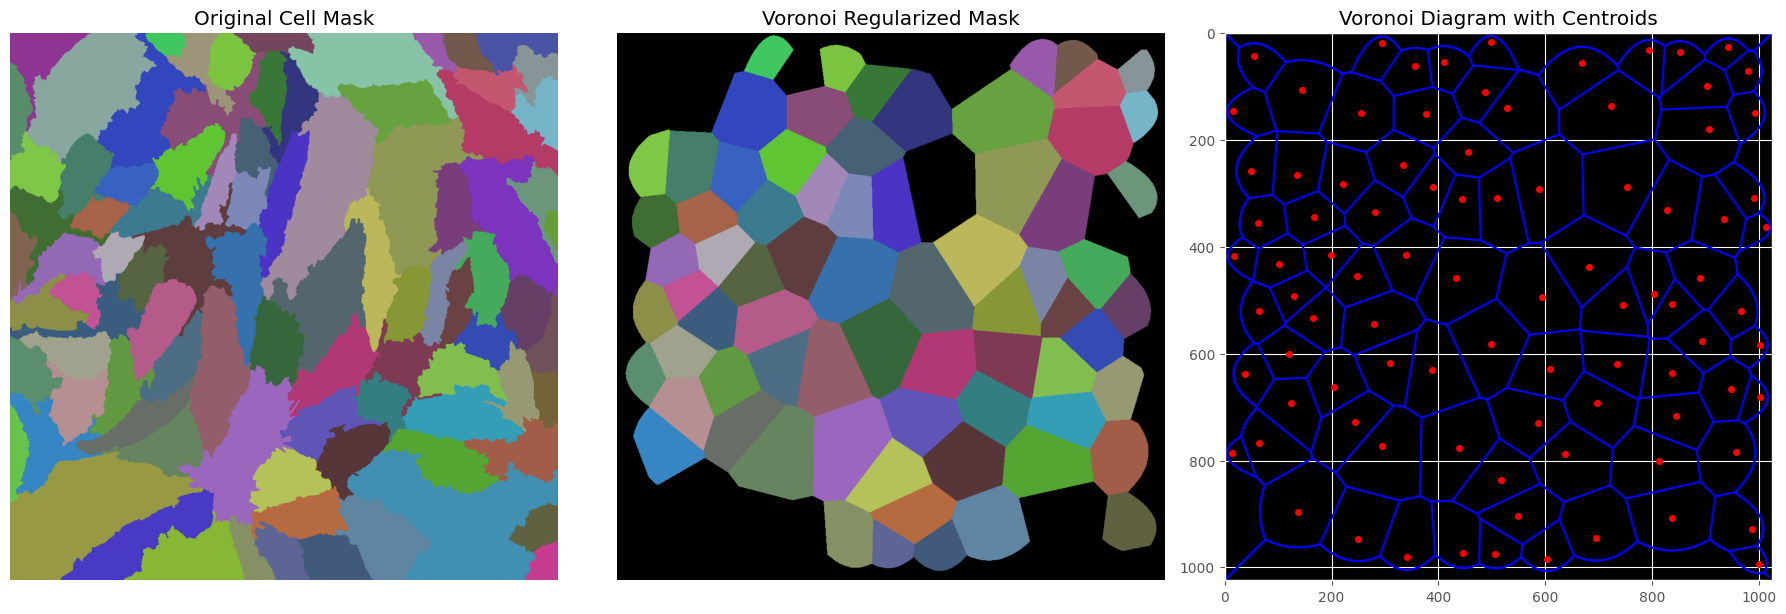

Cell image: dtype=uint32, min=0, max=91


TypeError: classify_shape() takes 3 positional arguments but 5 were given

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from skimage import measure, morphology, segmentation
import pandas as pd
from pathlib import Path

def voronoi_regularize_cells(cell_mask, min_area=100, boundary_buffer=5, visualize=True):
    """
    Regularize cell shapes using Voronoi diagrams.

    Parameters:
    -----------
    cell_mask : ndarray
        Labeled cell mask (integer type where each cell has a unique ID)
    min_area : int
        Minimum area for a cell to be considered
    boundary_buffer : int
        Buffer distance from image boundary for Voronoi computation
    visualize : bool
        Whether to generate visualization of the results

    Returns:
    --------
    voronoi_mask : ndarray
        New labeled mask with Voronoi-regularized cell shapes
    cell_mapping : dict
        Mapping between original cell IDs and new Voronoi cell IDs
    """
    # Ensure cell_mask is integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        print(f"Converting cell_mask to int32, original dtype: {cell_mask.dtype}")
        cell_mask = cell_mask.astype(np.int32)

    # Get image dimensions
    h, w = cell_mask.shape

    # Extract cell properties
    cell_props = measure.regionprops(cell_mask)

    # Collect centroids for Voronoi computation
    centroids = []
    cell_ids = []

    for prop in cell_props:
        # Skip small objects
        if prop.area < min_area:
            continue

        cell_ids.append(prop.label)
        y, x = prop.centroid
        centroids.append([x, y])

    if len(centroids) == 0:
        print("No valid cells found! Check your mask or reduce min_area.")
        return cell_mask, {}

    # Add boundary points to constrain Voronoi diagram
    # These will be removed later
    boundary_points = []
    boundary_ids = []

    # Top and bottom boundaries
    for x in range(0, w, boundary_buffer):
        boundary_points.append([x, -boundary_buffer])
        boundary_points.append([x, h+boundary_buffer])
        boundary_ids.extend([-1, -1])

    # Left and right boundaries
    for y in range(0, h, boundary_buffer):
        boundary_points.append([-boundary_buffer, y])
        boundary_points.append([w+boundary_buffer, y])
        boundary_ids.extend([-1, -1])

    # Combine cell centroids with boundary points
    all_points = np.array(centroids + boundary_points)
    all_ids = cell_ids + boundary_ids

    # Compute Voronoi diagram
    try:
        vor = Voronoi(all_points)
        print(f"Successfully computed Voronoi diagram with {len(all_points)} points")
        print(f"Number of cell centroids: {len(centroids)}")
        print(f"Number of boundary points: {len(boundary_points)}")
        print(f"Number of Voronoi vertices: {len(vor.vertices)}")
        print(f"Number of Voronoi regions: {len(vor.regions)}")
    except Exception as e:
        print(f"Voronoi computation failed: {e}")
        print(f"Number of points: {len(all_points)}")
        return cell_mask, {}

    # Create a new mask for Voronoi-regularized cells
    voronoi_mask = np.zeros((h, w), dtype=np.int32)

    # Create mapping between original cell IDs and Voronoi cell IDs
    cell_mapping = {}

    # Draw each Voronoi region for each cell
    for i in range(len(centroids)):  # Only iterate through actual cell points, not boundary points
        if i >= len(cell_ids):  # Skip boundary points
            continue

        original_cell_id = cell_ids[i]

        # Get region index for this point
        point_idx = i  # Points are indexed in the same order they were added
        region_idx = vor.point_region[point_idx]

        # Get the region vertices
        region = vor.regions[region_idx]
        if not region or -1 in region or len(region) < 3:  # Skip empty, open regions or degenerate cases
            continue

        # Get the vertex coordinates
        vertices = np.array([vor.vertices[v] for v in region])

        # Clip to image boundaries
        vertices[:, 0] = np.clip(vertices[:, 0], 0, w-1)
        vertices[:, 1] = np.clip(vertices[:, 1], 0, h-1)

        # Convert to integer coordinates for drawing
        vertices_int = vertices.astype(np.int32)

        # Create mask for this Voronoi cell
        cell_region = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(cell_region, [vertices_int], 1)

        # Find the intersection with the original cell
        original_cell = (cell_mask == original_cell_id).astype(np.uint8)
        intersection = cv2.bitwise_and(cell_region, original_cell)

        # Only keep the Voronoi cell if it significantly overlaps with the original cell
        if np.sum(intersection) > 0.5 * np.sum(original_cell):
            # New cell ID (i+1 to avoid 0, which is background)
            new_cell_id = i + 1

            # Add this cell to the Voronoi mask
            voronoi_mask[cell_region > 0] = new_cell_id

            # Record the mapping
            cell_mapping[original_cell_id] = new_cell_id

    # Visualization
    if visualize:
        # Create RGB visualization
        original_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        voronoi_rgb = np.zeros((h, w, 3), dtype=np.uint8)

        # Generate random colors for each cell
        np.random.seed(42)  # For reproducibility
        colors = np.random.randint(50, 200, (max(np.max(cell_mask), np.max(voronoi_mask))+1, 3), dtype=np.uint8)
        colors[0] = [0, 0, 0]  # Background is black

        # Color each cell in the original mask
        for i in range(1, np.max(cell_mask)+1):
            mask = (cell_mask == i)
            for c in range(3):
                original_rgb[mask, c] = colors[i, c]

        # Color each cell in the Voronoi mask
        for i in range(1, np.max(voronoi_mask)+1):
            mask = (voronoi_mask == i)
            for c in range(3):
                voronoi_rgb[mask, c] = colors[i, c]

        # Plot results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(original_rgb)
        axes[0].set_title('Original Cell Mask')
        axes[0].axis('off')

        axes[1].imshow(voronoi_rgb)
        axes[1].set_title('Voronoi Regularized Mask')
        axes[1].axis('off')

        # Draw Voronoi diagram with centroids
        axes[2].imshow(np.zeros((h, w, 3), dtype=np.uint8), extent=(0, w, 0, h))

        # Plot cell centroids
        centroids = np.array(centroids)
        axes[2].plot(centroids[:, 0], centroids[:, 1], 'r.', markersize=8)

        # Plot Voronoi edges within image boundaries
        for simplex in vor.ridge_vertices:
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):
                vertices = vor.vertices[simplex]
                # Check if edge is within image
                if (np.all(vertices[:, 0] >= 0) and np.all(vertices[:, 0] < w) and
                    np.all(vertices[:, 1] >= 0) and np.all(vertices[:, 1] < h)):
                    axes[2].plot(vertices[:, 0], vertices[:, 1], 'b-')

        axes[2].set_xlim(0, w)
        axes[2].set_ylim(0, h)
        axes[2].invert_yaxis()  # To match image coordinates
        axes[2].set_title('Voronoi Diagram with Centroids')

        plt.tight_layout()
        plt.show()

    return voronoi_mask, cell_mapping

def integrate_with_shape_analysis(cell_mask, voronoi_mask, cell_mapping, analyze_func=None):
    """
    Compare shape metrics between original and Voronoi-regularized cells.

    Parameters:
    -----------
    cell_mask : ndarray
        Original labeled cell mask
    voronoi_mask : ndarray
        Voronoi-regularized labeled cell mask
    cell_mapping : dict
        Mapping between original cell IDs and Voronoi cell IDs
    analyze_func : callable
        Function to calculate shape metrics (if None, basic metrics are calculated)

    Returns:
    --------
    comparison_df : DataFrame
        DataFrame with paired shape metrics for comparison
    """
    if analyze_func is None:
        # Define basic shape analysis if no function provided
        def basic_shape_analysis(mask):
            props = measure.regionprops(mask)
            metrics = []

            for prop in props:
                # Skip background
                if prop.label == 0:
                    continue

                # Create binary mask for current cell
                cell_binary = (mask == prop.label).astype(np.uint8)

                # Find contours
                contours, _ = cv2.findContours(cell_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if not contours:
                    continue

                contour = contours[0]

                # Calculate perimeter
                perimeter = cv2.arcLength(contour, True)

                # Calculate shape metrics
                area = prop.area
                circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

                # Calculate solidity
                hull = cv2.convexHull(contour)
                hull_area = cv2.contourArea(hull) if len(hull) > 2 else area
                solidity = area / hull_area if hull_area > 0 else 0

                # Approximation for vertex counting
                epsilon = 0.02 * perimeter
                approx = cv2.approxPolyDP(contour, epsilon, True)
                vertices = len(approx)

                # Store metrics
                metrics.append({
                    'cell_id': prop.label,
                    'area': area,
                    'perimeter': perimeter,
                    'circularity': circularity,
                    'solidity': solidity,
                    'vertices': vertices,
                    'major_axis_length': prop.major_axis_length,
                    'minor_axis_length': prop.minor_axis_length,
                    'orientation': np.degrees(prop.orientation) % 180
                })

            return metrics

        analyze_func = basic_shape_analysis

    # Analyze original and Voronoi cells
    original_metrics = analyze_func(cell_mask)
    voronoi_metrics = analyze_func(voronoi_mask)

    # Convert to DataFrames
    original_df = pd.DataFrame(original_metrics)
    voronoi_df = pd.DataFrame(voronoi_metrics)

    # Create paired comparison
    comparison_data = []

    for orig_id, vor_id in cell_mapping.items():
        # Find metrics for this pair
        orig_row = original_df[original_df['cell_id'] == orig_id]
        vor_row = voronoi_df[voronoi_df['cell_id'] == vor_id]

        if len(orig_row) == 0 or len(vor_row) == 0:
            continue

        # Extract values for comparison
        orig_metrics = orig_row.iloc[0].to_dict()
        vor_metrics = vor_row.iloc[0].to_dict()

        # Combine into a single row
        row = {
            'original_id': orig_id,
            'voronoi_id': vor_id
        }

        # Add all metrics with prefixes
        for k, v in orig_metrics.items():
            if k != 'cell_id':
                row[f'original_{k}'] = v

        for k, v in vor_metrics.items():
            if k != 'cell_id':
                row[f'voronoi_{k}'] = v

        # Calculate percentage changes
        for k in orig_metrics.keys():
            if k != 'cell_id' and k in vor_metrics and orig_metrics[k] != 0:
                row[f'{k}_change_%'] = ((vor_metrics[k] - orig_metrics[k]) / orig_metrics[k]) * 100

        comparison_data.append(row)

    # Create DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    # Visualize comparisons
    if not comparison_df.empty:
        # Plot key metric comparisons
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        metrics_to_compare = [
            ('circularity', 'Circularity'),
            ('solidity', 'Solidity'),
            ('vertices', 'Number of Vertices'),
            ('area', 'Area')
        ]

        for i, (metric, title) in enumerate(metrics_to_compare):
            ax = axes[i//2, i%2]

            x = comparison_df[f'original_{metric}']
            y = comparison_df[f'voronoi_{metric}']

            # Plot the comparison
            ax.scatter(x, y, alpha=0.6)

            # Add line y=x
            min_val = min(x.min(), y.min())
            max_val = max(x.max(), y.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)

            ax.set_xlabel(f'Original {title}')
            ax.set_ylabel(f'Voronoi {title}')
            ax.set_title(f'{title} Comparison')
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Summarize changes
        print("\nSummary of changes from original to Voronoi cells:")
        summary_metrics = ['circularity', 'solidity', 'vertices', 'area']

        for metric in summary_metrics:
            change_col = f'{metric}_change_%'
            if change_col in comparison_df.columns:
                mean_change = comparison_df[change_col].mean()
                median_change = comparison_df[change_col].median()
                print(f"{metric.capitalize()}: Mean change: {mean_change:.2f}%, Median change: {median_change:.2f}%")

    return comparison_df

# Example usage in a Google Colab notebook
def example_usage():
    """
    Example code to show how to use the Voronoi cell regularization
    """
    # Example: Load a cell mask image
    from google.colab import drive
    drive.mount('/content/drive')

    # Use your existing folder structure
    base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"

    # Find the first TIFF file in the Cell folder
    import os
    cell_dir = os.path.join(base_dir, "Cell")

    # List all tiff files in the directory
    tiff_files = [f for f in os.listdir(cell_dir) if f.endswith('.tif')]

    if not tiff_files:
        raise FileNotFoundError(f"No TIFF files found in {cell_dir}")

    # Use the first file found
    file_path = os.path.join(cell_dir, tiff_files[0])
    print(f"Using cell mask: {file_path}")

    import tifffile
    cell_mask = tifffile.imread(file_path)

    # Ensure cell_mask is a labeled image (not binary)
    if np.max(cell_mask) <= 1:
        print("Converting binary mask to labeled mask...")
        from scipy import ndimage
        cell_mask, _ = ndimage.label(cell_mask)
        print(f"Found {np.max(cell_mask)} cells after labeling")

    # Make sure it's integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        cell_mask = cell_mask.astype(np.int32)

    print(f"Cell mask shape: {cell_mask.shape}, dtype: {cell_mask.dtype}, min: {np.min(cell_mask)}, max: {np.max(cell_mask)}")

    # Apply Voronoi regularization
    voronoi_mask, cell_mapping = voronoi_regularize_cells(
        cell_mask,
        min_area=100,
        boundary_buffer=10,
        visualize=True
    )

    # Compare shape metrics
    comparison = integrate_with_shape_analysis(
        cell_mask,
        voronoi_mask,
        cell_mapping
    )

    # Save results using your existing folder structure
    output_dir = Path("/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2/Voronoi")
    output_dir.mkdir(exist_ok=True, parents=True)

    # Extract sample ID from filename for consistent naming
    import os
    sample_id = os.path.basename(file_path).split('_')[0:3]  # Adjust slicing as needed
    sample_id = '_'.join(sample_id)

    # Save the Voronoi mask
    voronoi_file = output_dir / f"{sample_id}_voronoi_mask.tif"
    tifffile.imwrite(voronoi_file, voronoi_mask)

    # Save the comparison metrics
    if not comparison.empty:
        comparison.to_csv(output_dir / f"{sample_id}_shape_comparison.csv", index=False)

    print(f"Results saved to {output_dir}")

    return voronoi_mask

# To integrate with your existing code, you could add this to your workflow:
"""
# After analyzing cell shapes:
voronoi_mask, cell_mapping = voronoi_regularize_cells(images['cell'])

# Compare original vs. Voronoi shapes
comparison = integrate_with_shape_analysis(
    images['cell'],
    voronoi_mask,
    cell_mapping,
    analyze_func=analyze_cell_shapes  # Your existing analysis function
)

# Save Voronoi mask
voronoi_file = os.path.join(sample_output_dir, f"{sample_id}_voronoi_mask.tif")
tifffile.imwrite(voronoi_file, voronoi_mask)

# Analyze the Voronoi regularized shapes using your existing function
voronoi_results = analyze_cell_shapes(voronoi_mask, nucleus_image)

# Visualize the Voronoi shapes
voronoi_output_path = os.path.join(sample_output_dir, f"{sample_id}_voronoi_shapes.png")
visualize_cell_shapes(voronoi_mask, voronoi_results, voronoi_output_path)
"""

# If running as standalone script
if __name__ == "__main__":
    # This would be the entry point when running the script directly
    example_usage()

In [28]:
def analyze_voronoi_shapes(original_mask, voronoi_mask, cell_mapping):
    """
    Analyze and compare shape distributions and orientations between
    original and Voronoi-regularized cell masks.

    Parameters:
    -----------
    original_mask : ndarray
        Original labeled cell mask
    voronoi_mask : ndarray
        Voronoi-regularized labeled cell mask
    cell_mapping : dict
        Mapping between original cell IDs and Voronoi cell IDs

    Returns:
    --------
    comparison_results : dict
        Dictionary with comparison metrics and visualization data
    """
    # Extract properties from both masks
    original_props = measure.regionprops(original_mask)
    voronoi_props = measure.regionprops(voronoi_mask)

    # Create lookup dictionaries for quick access
    original_prop_dict = {prop.label: prop for prop in original_props}
    voronoi_prop_dict = {prop.label: prop for prop in voronoi_props}

    # Store shape and orientation data
    comparison_data = []

    # Track shape distributions
    original_shapes = {}
    voronoi_shapes = {}

    for orig_id, vor_id in cell_mapping.items():
        if orig_id in original_prop_dict and vor_id in voronoi_prop_dict:
            orig_prop = original_prop_dict[orig_id]
            vor_prop = voronoi_prop_dict[vor_id]

            # Extract basic properties
            orig_area = orig_prop.area
            vor_area = vor_prop.area

            # Calculate perimeters
            orig_mask_binary = (original_mask == orig_id).astype(np.uint8)
            vor_mask_binary = (voronoi_mask == vor_id).astype(np.uint8)

            orig_contours, _ = cv2.findContours(orig_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            vor_contours, _ = cv2.findContours(vor_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not orig_contours or not vor_contours:
                continue

            orig_contour = max(orig_contours, key=cv2.contourArea)
            vor_contour = max(vor_contours, key=cv2.contourArea)

            orig_perimeter = cv2.arcLength(orig_contour, True)
            vor_perimeter = cv2.arcLength(vor_contour, True)

            # Calculate shape metrics
            # Circularity (1 for circle, less for irregular shapes)
            orig_circularity = (4 * np.pi * orig_area) / (orig_perimeter**2) if orig_perimeter > 0 else 0
            vor_circularity = (4 * np.pi * vor_area) / (vor_perimeter**2) if vor_perimeter > 0 else 0

            # Elongation (major axis / minor axis)
            orig_elongation = orig_prop.major_axis_length / orig_prop.minor_axis_length if orig_prop.minor_axis_length > 0 else 1
            vor_elongation = vor_prop.major_axis_length / vor_prop.minor_axis_length if vor_prop.minor_axis_length > 0 else 1

            # Orientation (in degrees, 0-90 where 0 is horizontal)
            orig_orientation = np.degrees(orig_prop.orientation) % 180
            if orig_orientation > 90:
                orig_orientation = 180 - orig_orientation

            vor_orientation = np.degrees(vor_prop.orientation) % 180
            if vor_orientation > 90:
                vor_orientation = 180 - vor_orientation

            # Approximate contour to count vertices
            orig_epsilon = 0.02 * orig_perimeter
            vor_epsilon = 0.02 * vor_perimeter

            orig_approx = cv2.approxPolyDP(orig_contour, orig_epsilon, True)
            vor_approx = cv2.approxPolyDP(vor_contour, vor_epsilon, True)

            orig_vertices = len(orig_approx)
            vor_vertices = len(vor_approx)

            # Classify shapes based on vertices and metrics
            orig_shape = classify_shape(orig_vertices, orig_circularity, orig_elongation)
            vor_shape = classify_shape(vor_vertices, vor_circularity, vor_elongation)

            # Update shape distributions
            original_shapes[orig_shape] = original_shapes.get(orig_shape, 0) + 1
            voronoi_shapes[vor_shape] = voronoi_shapes.get(vor_shape, 0) + 1

            # Store all comparison data
            comparison_data.append({
                'original_id': orig_id,
                'voronoi_id': vor_id,
                'original_area': orig_area,
                'voronoi_area': vor_area,
                'original_perimeter': orig_perimeter,
                'voronoi_perimeter': vor_perimeter,
                'original_circularity': orig_circularity,
                'voronoi_circularity': vor_circularity,
                'original_elongation': orig_elongation,
                'voronoi_elongation': vor_elongation,
                'original_orientation': orig_orientation,
                'voronoi_orientation': vor_orientation,
                'original_vertices': orig_vertices,
                'voronoi_vertices': vor_vertices,
                'original_shape': orig_shape,
                'voronoi_shape': vor_shape
            })

    # Create DataFrame for analysis
    if comparison_data:
        df = pd.DataFrame(comparison_data)

        # Visualize the shape comparisons and orientations
        visualize_shape_orientation_comparison(df, original_shapes, voronoi_shapes)

        # Calculate summary statistics
        orientation_stats = {
            'original_mean_orientation': df['original_orientation'].mean(),
            'voronoi_mean_orientation': df['voronoi_orientation'].mean(),
            'original_orientation_std': df['original_orientation'].std(),
            'voronoi_orientation_std': df['voronoi_orientation'].std()
        }

        # Calculate shape change statistics
        shape_changed = sum(1 for i, row in df.iterrows() if row['original_shape'] != row['voronoi_shape'])
        shape_change_pct = (shape_changed / len(df)) * 100 if len(df) > 0 else 0

        # Categorize orientation changes
        df['orientation_diff'] = np.abs(df['voronoi_orientation'] - df['original_orientation'])
        df['orientation_changed'] = df['orientation_diff'] > 15  # Consider change if > 15 degrees
        orientation_changed_pct = (df['orientation_changed'].sum() / len(df)) * 100 if len(df) > 0 else 0

        # Group by shape type to see which shapes are most affected
        shape_transition = pd.crosstab(df['original_shape'], df['voronoi_shape'])

        results = {
            'comparison_df': df,
            'orientation_stats': orientation_stats,
            'shape_change_pct': shape_change_pct,
            'orientation_changed_pct': orientation_changed_pct,
            'shape_transition': shape_transition,
            'original_shapes': original_shapes,
            'voronoi_shapes': voronoi_shapes
        }

        return results
    else:
        print("No valid cell comparisons found.")
        return None

def classify_shape(vertices, circularity, elongation):
    """Classify cell shape based on vertices and shape metrics"""

    # First check high elongation - strong indicator
    if elongation > 2.5:
        return "elongated"

    # Check circularity for round cells
    if circularity > 0.8:
        return "circular"

    # Use vertices for classification
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8 and vertices <= 12:
        return "multi-sided"
    else:
        return "irregular"

def visualize_shape_orientation_comparison(df, original_shapes, voronoi_shapes):
    """
    Create visualizations comparing shape distributions and orientations
    between original and Voronoi-regularized cells.
    """
    # Set up figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Compare shape distributions (top-left)
    # Combine shape dictionaries into DataFrame
    shape_types = sorted(set(list(original_shapes.keys()) + list(voronoi_shapes.keys())))
    shape_counts = {
        'Original': [original_shapes.get(shape, 0) for shape in shape_types],
        'Voronoi': [voronoi_shapes.get(shape, 0) for shape in shape_types]
    }
    shape_df = pd.DataFrame(shape_counts, index=shape_types)

    # Calculate percentages
    total_original = sum(shape_counts['Original'])
    total_voronoi = sum(shape_counts['Voronoi'])

    shape_df['Original %'] = shape_df['Original'] / total_original * 100 if total_original > 0 else 0
    shape_df['Voronoi %'] = shape_df['Voronoi'] / total_voronoi * 100 if total_voronoi > 0 else 0

    # Plot as grouped bar chart
    shape_df[['Original %', 'Voronoi %']].plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Shape Distribution Comparison')
    axes[0, 0].set_ylabel('Percentage of Cells')
    axes[0, 0].set_xlabel('Cell Shape')
    axes[0, 0].legend(['Original', 'Voronoi'])
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Add percentage labels
    for i, p in enumerate(axes[0, 0].patches):
        axes[0, 0].annotate(f"{p.get_height():.1f}%",
                            (p.get_x() + p.get_width()/2., p.get_height()),
                            ha='center', va='bottom', fontsize=8)

    # 2. Compare orientation distributions (top-right)
    # Create histograms of orientation angles
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    axes[0, 1].hist(df['original_orientation'], bins=bins, alpha=0.5,
                   label='Original', density=True, color='cornflowerblue')
    axes[0, 1].hist(df['voronoi_orientation'], bins=bins, alpha=0.5,
                   label='Voronoi', density=True, color='indianred')

    axes[0, 1].set_title('Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)')
    axes[0, 1].set_xlabel('Orientation (degrees)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].axvline(x=45, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # 3. Scatter plot of original vs. Voronoi orientations (bottom-left)
    axes[1, 0].scatter(df['original_orientation'], df['voronoi_orientation'],
                      alpha=0.6, c=df['original_circularity'], cmap='viridis')
    axes[1, 0].plot([0, 90], [0, 90], 'r--', alpha=0.5)  # Line y=x

    axes[1, 0].set_title('Original vs. Voronoi Cell Orientation')
    axes[1, 0].set_xlabel('Original Orientation (degrees)')
    axes[1, 0].set_ylabel('Voronoi Orientation (degrees)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, 90)
    axes[1, 0].set_ylim(0, 90)

    # Add colorbar for circularity
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1, 0])
    cbar.set_label('Original Circularity')

    # 4. Elongation comparison (bottom-right)
    axes[1, 1].scatter(df['original_elongation'], df['voronoi_elongation'],
                      alpha=0.6, c=df['original_vertices'], cmap='plasma')

    # Add diagonal reference line
    max_elong = max(df['original_elongation'].max(), df['voronoi_elongation'].max())
    axes[1, 1].plot([1, max_elong], [1, max_elong], 'r--', alpha=0.5)

    axes[1, 1].set_title('Original vs. Voronoi Elongation')
    axes[1, 1].set_xlabel('Original Elongation')
    axes[1, 1].set_ylabel('Voronoi Elongation')
    axes[1, 1].grid(True, alpha=0.3)

    # Add colorbar for vertices
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=axes[1, 1])
    cbar.set_label('Original Vertices Count')

    plt.tight_layout()
    plt.show()

    # Create additional figure for orientation categories
    plt.figure(figsize=(12, 6))

    # Divide orientations into categories
    cats = ['Horizontal\n(0-30°)', 'Intermediate\n(30-60°)', 'Vertical\n(60-90°)']

    # Calculate percentages for original
    orig_h = np.sum(df['original_orientation'] < 30) / len(df) * 100
    orig_i = np.sum((df['original_orientation'] >= 30) & (df['original_orientation'] < 60)) / len(df) * 100
    orig_v = np.sum(df['original_orientation'] >= 60) / len(df) * 100

    # Calculate percentages for Voronoi
    vor_h = np.sum(df['voronoi_orientation'] < 30) / len(df) * 100
    vor_i = np.sum((df['voronoi_orientation'] >= 30) & (df['voronoi_orientation'] < 60)) / len(df) * 100
    vor_v = np.sum(df['voronoi_orientation'] >= 60) / len(df) * 100

    # Create grouped bar chart
    x = np.arange(len(cats))
    width = 0.35

    plt.bar(x - width/2, [orig_h, orig_i, orig_v], width, label='Original', color='cornflowerblue')
    plt.bar(x + width/2, [vor_h, vor_i, vor_v], width, label='Voronoi', color='indianred')

    # Add percentage labels
    for i, v in enumerate([orig_h, orig_i, orig_v]):
        plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

    for i, v in enumerate([vor_h, vor_i, vor_v]):
        plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.xlabel('Orientation Category')
    plt.ylabel('Percentage of Cells')
    plt.title('Cell Orientation Distribution by Category')
    plt.xticks(x, cats)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

# To integrate this with your voronoi regularization:
def enhanced_voronoi_analysis(sample_id, cell_mask, voronoi_mask, cell_mapping, output_dir):
    """
    Run enhanced shape and orientation analysis on Voronoi regularized cells
    and save results using the same format as the original analysis.

    Parameters:
    -----------
    sample_id : str
        ID of the sample being processed
    cell_mask : ndarray
        Original cell mask
    voronoi_mask : ndarray
        Voronoi regularized mask
    cell_mapping : dict
        Mapping from original to Voronoi cell IDs
    output_dir : str or Path
        Directory to save results
    """
    output_dir = Path(output_dir)

    # Run shape and orientation analysis
    comparison_results = analyze_voronoi_shapes(cell_mask, voronoi_mask, cell_mapping)

    if comparison_results:
        # Save comparison DataFrame
        comparison_df = comparison_results['comparison_df']
        comparison_file = output_dir / f"{sample_id}_voronoi_comparison.csv"
        comparison_df.to_csv(comparison_file, index=False)
        print(f"Saved comparison metrics to {comparison_file}")

        # Save shape transition matrix
        transition_file = output_dir / f"{sample_id}_shape_transitions.csv"
        comparison_results['shape_transition'].to_csv(transition_file)
        print(f"Saved shape transition data to {transition_file}")

        # Save summary statistics
        summary = {
            'sample_id': sample_id,
            'original_mean_orientation': comparison_results['orientation_stats']['original_mean_orientation'],
            'voronoi_mean_orientation': comparison_results['orientation_stats']['voronoi_mean_orientation'],
            'original_orientation_std': comparison_results['orientation_stats']['original_orientation_std'],
            'voronoi_orientation_std': comparison_results['orientation_stats']['voronoi_orientation_std'],
            'shape_change_pct': comparison_results['shape_change_pct'],
            'orientation_changed_pct': comparison_results['orientation_changed_pct']
        }

        # Add shape distributions
        for shape, count in comparison_results['original_shapes'].items():
            summary[f'original_{shape}_count'] = count

        for shape, count in comparison_results['voronoi_shapes'].items():
            summary[f'voronoi_{shape}_count'] = count

        summary_df = pd.DataFrame([summary])
        summary_file = output_dir / f"{sample_id}_voronoi_summary.csv"
        summary_df.to_csv(summary_file, index=False)
        print(f"Saved summary to {summary_file}")

        # Print key findings
        print("\nKey findings from Voronoi regularization:")
        print(f"Shape changes: {comparison_results['shape_change_pct']:.1f}% of cells changed shape classification")
        print(f"Orientation changes: {comparison_results['orientation_changed_pct']:.1f}% of cells had orientation changes >15°")
        print(f"Original mean orientation: {comparison_results['orientation_stats']['original_mean_orientation']:.2f}°")
        print(f"Voronoi mean orientation: {comparison_results['orientation_stats']['voronoi_mean_orientation']:.2f}°")

        # Return the results
        return comparison_results
    else:
        print("No valid comparison data generated.")
        return None

Voronoi right

In [30]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, measure, segmentation, feature, morphology
from scipy import ndimage
from collections import Counter
import tifffile
from pathlib import Path
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial import Voronoi

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

# Define paths based on your Google Drive structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-2"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Analysis/Static-A-2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    # Example: denoised_0Pa_A1_20dec21_40x_L2RA_FlatA_seq007_contrast_Nuclei_mask.tif
    # We want to extract everything before the component name (Nuclei, Golgi, etc.)
    parts = str(filename).split('_')
    # Find the index of component parts (Nuclei, Golgi, membrane, cell)
    components = ['Nuclei', 'Golgi', 'membrane', 'cell']
    for i, part in enumerate(parts):
        if part in components:
            return '_'.join(parts[:i])
    return None  # If no match found

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in (based on your Google Drive structure)
    component_folders = ['Nuclei', 'Membrane_Adjusted', 'Golgi', 'Cell']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all TIFF files in the component folder
        files = [f for f in os.listdir(component_dir) if f.endswith('.tif')]
        print(f"Found {len(files)} TIFF files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                # Use 'membrane' as the key for consistency even though folder is Membrane_Adjusted
                if component == 'Membrane_Adjusted':
                    file_dict[sample_id]['membrane'] = os.path.join(component_dir, file)
                else:
                    file_dict[sample_id][component.lower()] = os.path.join(component_dir, file)

    # Find samples that have files in all components
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have at least nuclei and cell data
        if 'nuclei' in components and 'cell' in components:
            complete_samples.append(sample_id)

    print(f"Found {len(complete_samples)} complete samples with at least nuclei and cell data.")

    return file_dict, complete_samples

# Function to load images for a specific sample
def load_sample_images(sample_id, file_dict):
    images = {}
    for component, filepath in file_dict[sample_id].items():
        if os.path.exists(filepath):
            # Read image and ensure it's an integer type
            img = io.imread(filepath)

            # Convert boolean images to uint8
            if img.dtype == bool:
                img = img.astype(np.uint8)

            images[component] = img
            print(f"Loaded {component} image: shape {images[component].shape}, dtype: {images[component].dtype}")
        else:
            print(f"Warning: File not found - {filepath}")

    return images

# Function to preprocess cell masks to simplify shapes
def preprocess_cell_mask(mask, smooth_iterations=2, remove_small_objects=True):
    """
    Preprocess cell masks to simplify shapes by removing small protrusions and holes
    """
    # Apply morphological closing to fill small holes
    closed_mask = morphology.binary_closing(mask > 0)

    # Apply morphological opening to remove small protrusions
    opened_mask = morphology.binary_opening(closed_mask)

    # Optionally apply smoothing iterations
    smoothed_mask = opened_mask.copy()
    if smooth_iterations > 0:
        # Apply binary dilation and erosion to smooth boundaries
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_dilation(smoothed_mask)
        for _ in range(smooth_iterations):
            smoothed_mask = morphology.binary_erosion(smoothed_mask)

    # Remove small objects if requested
    if remove_small_objects:
        smoothed_mask = morphology.remove_small_objects(smoothed_mask, min_size=100)

    return smoothed_mask.astype(np.uint8)

# Function to cleanly extract a single cell contour
def extract_clean_contour(cell_mask, cell_id, smoothing=True):
    """
    Extract a clean, simplified contour for a single cell,
    removing small protrusions and simplifying the shape
    """
    # Extract the single cell mask
    mask = (cell_mask == cell_id).astype(np.uint8)

    # Preprocess the mask to simplify shape
    clean_mask = preprocess_cell_mask(mask, smooth_iterations=1)

    # Find contours of the cleaned mask
    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Get the largest contour (in case there are multiple after cleaning)
    contour = max(contours, key=cv2.contourArea)

    # Optionally smooth the contour
    if smoothing:
        epsilon = 0.005 * cv2.arcLength(contour, True)
        contour = cv2.approxPolyDP(contour, epsilon, True)

    return contour

# Enhanced function to analyze cell shapes with additional metrics
def analyze_cell_shapes(cell_image, nucleus_image=None):
    """
    Analyze cell shapes with enhanced metrics and morphological features.

    Parameters:
    cell_image: Label image of cells
    nucleus_image: Optional label image of nuclei for nuclear positioning analysis

    Returns:
    Dictionary with shape analysis results
    """
    # Ensure we have integer type image for regionprops
    if not np.issubdtype(cell_image.dtype, np.integer):
        print(f"Warning: cell_image is not integer type (dtype: {cell_image.dtype}). Converting...")
        cell_image = cell_image.astype(np.int32)

    # Debug info
    print(f"Cell image: dtype={cell_image.dtype}, min={np.min(cell_image)}, max={np.max(cell_image)}")

    # Check if we need to relabel the cells
    if np.max(cell_image) < 2:
        print("Cell image appears to be binary. Labeling regions...")
        from scipy.ndimage import label
        cell_image, num_regions = label(cell_image > 0)
        print(f"Found {num_regions} regions after labeling")

    cell_props = measure.regionprops(cell_image)

    # Prepare arrays for storing metrics
    cell_metrics = []
    cell_shapes = []
    cell_contours = []
    clean_contours = []

    for cell_prop in cell_props:
        cell_id = cell_prop.label

        # Skip very small objects (likely artifacts)
        if cell_prop.area < 100:
            continue

        # Create binary mask for current cell
        mask = (cell_image == cell_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if not contours:
            continue

        contour = contours[0]
        cell_contours.append(contour)

        # Generate a cleaned, simplified contour for shape analysis
        clean_contour = extract_clean_contour(cell_image, cell_id)
        if clean_contour is None:
            clean_contour = contour  # Fall back to original if cleaning fails
        clean_contours.append(clean_contour)

        # Basic metrics from regionprops
        area = cell_prop.area
        perimeter = cell_prop.perimeter if cell_prop.perimeter else 0
        centroid_y, centroid_x = cell_prop.centroid
        orientation_rad = cell_prop.orientation  # in radians

        # Convert to 0-90 degrees (for horizontal vs vertical alignment)
        # 0 degrees means perfectly horizontal, 90 degrees means perfectly vertical
        orientation_deg = np.degrees(orientation_rad) % 180
        if orientation_deg > 90:
            orientation_deg = 180 - orientation_deg

        major_axis_length = cell_prop.major_axis_length
        minor_axis_length = cell_prop.minor_axis_length
        eccentricity = cell_prop.eccentricity

        # Additional shape metrics
        # Circularity (1 for perfect circle, less as shape becomes less circular)
        circularity = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0

        # Solidity (ratio of area to convex hull area)
        solidity = cell_prop.solidity

        # Convexity (ratio of convex hull perimeter to perimeter)
        convex_image = cell_prop.convex_image
        convex_perimeter = measure.perimeter(convex_image)
        convexity = convex_perimeter / perimeter if perimeter > 0 else 0

        # Rectangularity (ratio of area to bounding box area)
        min_row, min_col, max_row, max_col = cell_prop.bbox
        bbox_area = (max_row - min_row) * (max_col - min_col)
        rectangularity = area / bbox_area if bbox_area > 0 else 0

        # Elongation (major axis / minor axis)
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        # Compactness (another measure of circularity)
        compactness = np.sqrt(4 * area / np.pi) / major_axis_length if major_axis_length > 0 else 0

        # Approximation of the contour for shape classification - use the clean contour
        peri = cv2.arcLength(clean_contour, True)
        approx = cv2.approxPolyDP(clean_contour, 0.02 * peri, True)
        vertices = len(approx)

        # Shape classification based on vertices and metrics
        shape = classify_shape(vertices, circularity, elongation, rectangularity, solidity)
        cell_shapes.append(shape)

        # Check for nuclear position if nucleus image is provided
        nuclear_position = None
        nucleus_distance = None
        if nucleus_image is not None:
            nuclear_position, nucleus_distance = measure_nuclear_position(
                cell_image, nucleus_image, cell_id, centroid_x, centroid_y, major_axis_length
            )

        # Calculate the horizontal/vertical alignment
        # 0 means perfectly horizontal, 1 means perfectly vertical
        horizontal_vertical_ratio = orientation_deg / 90.0

        # Store all metrics
        metrics = {
            'cell_id': cell_id,
            'area': area,
            'perimeter': perimeter,
            'centroid_x': centroid_x,
            'centroid_y': centroid_y,
            'orientation_rad': orientation_rad,
            'orientation_deg': orientation_deg,
            'horizontal_vertical_ratio': horizontal_vertical_ratio,  # 0=horizontal, 1=vertical
            'major_axis_length': major_axis_length,
            'minor_axis_length': minor_axis_length,
            'eccentricity': eccentricity,
            'circularity': circularity,
            'solidity': solidity,
            'convexity': convexity,
            'rectangularity': rectangularity,
            'elongation': elongation,
            'compactness': compactness,
            'vertices': vertices,
            'shape': shape
        }

        # Add nuclear metrics if available
        if nuclear_position is not None:
            metrics['nuclear_position'] = nuclear_position
            metrics['nucleus_distance'] = nucleus_distance

        cell_metrics.append(metrics)

    # Create summary statistics
    shape_distribution = Counter(cell_shapes)
    total_cells = len(cell_shapes)

    # Calculate averages and distributions of metrics
    avg_metrics = {}
    std_metrics = {}

    if cell_metrics:
        metrics_df = pd.DataFrame(cell_metrics)
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            avg_metrics[col] = metrics_df[col].mean()
            std_metrics[col] = metrics_df[col].std()

    results = {
        'all_metrics': cell_metrics,
        'shape_distribution': shape_distribution,
        'total_cells': total_cells,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics,
        'cell_contours': cell_contours,
        'clean_contours': clean_contours
    }

    return results

# Improved function to classify cell shape using simplified contours
def classify_shape(vertices, circularity, elongation, rectangularity, solidity):
    """Classify cell shape based on geometric properties using a more robust approach"""

    # First check high elongation - this is a strong indicator
    if elongation > 2.5:
        return "elongated"

    # Check circularity for round cells
    if circularity > 0.8:
        return "circular"

    # Check solidity - helps identify irregular shapes with concavities
    if solidity < 0.85:
        return "irregular"

    # For high-solidity shapes, use vertices for classification
    if vertices == 3:
        return "triangular"
    elif vertices == 4:
        # Distinguish between rectangle and square
        if 0.85 < rectangularity and elongation < 1.2:
            return "square"
        else:
            return "rectangular"
    elif vertices == 5:
        return "pentagonal"
    elif vertices == 6:
        return "hexagonal"
    elif vertices == 7:
        return "heptagonal"
    elif vertices == 8:
        return "octagonal"
    elif vertices > 8 and vertices <= 12:
        return "multi-sided"

    # Default for shapes with many vertices or that don't fit other categories
    if elongation > 1.5:
        return "elongated"
    elif circularity > 0.6:
        return "rounded"
    else:
        return "irregular"

# Function to measure nuclear positioning within the cell
def measure_nuclear_position(cell_image, nucleus_image, cell_id, cell_x, cell_y, major_axis):
    """
    Determine the position of the nucleus within the cell.
    Returns a position category and distance metric.
    """
    # Create mask for the current cell
    cell_mask = cell_image == cell_id

    # Find nuclei that overlap with this cell
    nucleus_in_cell = np.unique(nucleus_image[cell_mask])
    # Remove background (0)
    nucleus_in_cell = nucleus_in_cell[nucleus_in_cell > 0]

    if len(nucleus_in_cell) == 0:
        return None, None

    # Use the largest nucleus if multiple are present
    if len(nucleus_in_cell) > 1:
        nucleus_sizes = [(n, np.sum(nucleus_image == n)) for n in nucleus_in_cell]
        nucleus_id = max(nucleus_sizes, key=lambda x: x[1])[0]
    else:
        nucleus_id = nucleus_in_cell[0]

    # Create a mask for just this nucleus and use it with regionprops
    nucleus_mask = (nucleus_image == nucleus_id).astype(np.uint8)
    nucleus_props = measure.regionprops(nucleus_mask)

    if not nucleus_props:
        return None, None

    nucleus_y, nucleus_x = nucleus_props[0].centroid

    # Calculate distance from nucleus to cell centroid
    distance = np.sqrt((nucleus_x - cell_x)**2 + (nucleus_y - cell_y)**2)

    # Normalize by cell size (major axis)
    normalized_distance = distance / (major_axis / 2) if major_axis > 0 else 0

    # Categorize position
    if normalized_distance < 0.2:
        position = "central"
    elif normalized_distance < 0.6:
        position = "intermediate"
    else:
        position = "peripheral"

    return position, normalized_distance

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Function to create shape visualizations with improved contours
def visualize_cell_shapes(cell_image, shape_results, output_path=None):
    """Create visualizations for cell shape analysis using cleaned contours"""

    # Create a colormap for different shapes
    shape_colors = {
        "circular": "blue",
        "elongated": "red",
        "triangular": "green",
        "square": "purple",
        "rectangular": "orange",
        "pentagonal": "cyan",
        "hexagonal": "magenta",
        "heptagonal": "lime",
        "octagonal": "brown",
        "multi-sided": "pink",
        "irregular": "gray",
        "rounded": "skyblue"
    }

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Original cell image with colored shapes
    colored_cells = np.zeros((*cell_image.shape, 3), dtype=np.uint8)

    for metrics in shape_results['all_metrics']:
        shape = metrics['shape']
        mask = cell_image == metrics['cell_id']

        # Get RGB color for this shape
        color_name = shape_colors.get(shape, "gray")
        color = np.array(plt.cm.colors.to_rgb(color_name)) * 255

        # Apply color to the mask
        for i in range(3):
            colored_cells[mask, i] = color[i]

    axes[0, 0].imshow(colored_cells)
    axes[0, 0].set_title("Cell Shapes")
    axes[0, 0].axis('off')

    # 2. Shape distribution
    shapes = list(shape_results['shape_distribution'].keys())
    counts = list(shape_results['shape_distribution'].values())
    colors = [shape_colors.get(shape, "gray") for shape in shapes]

    # Sort shapes by count
    shape_count_pairs = sorted(zip(shapes, counts, colors), key=lambda x: x[1], reverse=True)
    if shape_count_pairs:
        shapes, counts, colors = zip(*shape_count_pairs)
    else:
        shapes, counts, colors = [], [], []

    axes[0, 1].bar(shapes, counts, color=colors)
    axes[0, 1].set_title("Shape Distribution")
    axes[0, 1].set_xlabel("Cell Shape")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis='x', rotation=45)

    # 3. Horizontal vs Vertical orientation histogram
    if shape_results['all_metrics']:
        df = pd.DataFrame(shape_results['all_metrics'])

        # Use orientation_deg directly (0=horizontal, 90=vertical)
        sns.histplot(df['orientation_deg'], bins=18, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title("Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)")
        axes[1, 0].set_xlabel("Orientation (degrees)")
        axes[1, 0].set_ylabel("Frequency")
        axes[1, 0].axvline(x=45, color='r', linestyle='--', alpha=0.5, label="45° threshold")
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

    # 4. Horizontal-Vertical Ratio vs Elongation
    if shape_results['all_metrics']:
        scatter = axes[1, 1].scatter(
            df['elongation'],
            df['horizontal_vertical_ratio'],
            c=[plt.cm.colors.to_rgba(shape_colors.get(shape, "gray")) for shape in df['shape']],
            alpha=0.7
        )

        axes[1, 1].set_title("Elongation vs Orientation")
        axes[1, 1].set_xlabel("Elongation (major/minor axis)")
        axes[1, 1].set_ylabel("Orientation (0=Horizontal, 1=Vertical)")
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="45° threshold")

        # Add legend for shapes
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=shape_colors[shape], markersize=8, label=shape)
                  for shape in shape_colors if shape in df['shape'].values]
        axes[1, 1].legend(handles=handles, title="Shapes", loc='upper right')

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved visualization to {output_path}")

    plt.show()

    # Additional visualization: Horizontal vs Vertical orientations
    if shape_results['all_metrics']:
        plt.figure(figsize=(12, 6))

        # Create bins representing 0-90 degrees (0=horizontal, 90=vertical)
        orientations = np.array([metrics['orientation_deg'] for metrics in shape_results['all_metrics']])

        # Calculate horizontal vs vertical percentages
        horizontal_cells = np.sum(orientations < 45) / len(orientations) * 100
        vertical_cells = 100 - horizontal_cells

        # Create bar chart
        plt.bar(['Horizontal\n(0-45°)', 'Vertical\n(45-90°)'],
                [horizontal_cells, vertical_cells],
                color=['cornflowerblue', 'indianred'])

        plt.title("Horizontal vs. Vertical Cell Orientation")
        plt.ylabel("Percentage of Cells")
        plt.ylim(0, 100)

        # Add percentage labels
        plt.text(0, horizontal_cells + 2, f"{horizontal_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')
        plt.text(1, vertical_cells + 2, f"{vertical_cells:.1f}%",
                ha='center', va='bottom', fontweight='bold')

        plt.grid(axis='y', alpha=0.3)

        if output_path:
            horiz_vert_output = output_path.replace('.png', '_horiz_vert.png')
            plt.savefig(horiz_vert_output, dpi=300)
            print(f"Saved horizontal-vertical analysis to {horiz_vert_output}")

        plt.show()

    # Draw example cells with their contours (using cleaned contours)
    if shape_results['clean_contours'] and shape_results['all_metrics']:
        plt.figure(figsize=(15, 10))

        # Select up to 9 cells of different shapes to display
        unique_shapes = set(metrics['shape'] for metrics in shape_results['all_metrics'])
        examples = []

        for shape in unique_shapes:
            # Find cells with this shape
            matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                             if metrics['shape'] == shape]

            if matching_cells:
                # Pick the largest cell with this shape
                largest_idx = max(matching_cells,
                                 key=lambda i: shape_results['all_metrics'][i]['area'])
                examples.append((largest_idx, shape))

            # Limit to 9 examples
            if len(examples) >= 9:
                break

        # If we have less than 9 shapes, add more examples of common shapes
        if len(examples) < 9:
            common_shapes = sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True)

            for shape, _ in common_shapes:
                if len(examples) >= 9:
                    break

                # Check if we already have this shape
                if shape in [s for _, s in examples]:
                    # Find all cells with this shape
                    matching_cells = [i for i, metrics in enumerate(shape_results['all_metrics'])
                                     if metrics['shape'] == shape]

                    # Filter out cells we've already selected
                    matching_cells = [i for i in matching_cells
                                     if i not in [idx for idx, _ in examples]]

                    if matching_cells:
                        # Sort by area and take the largest remaining
                        sorted_cells = sorted(matching_cells,
                                             key=lambda i: shape_results['all_metrics'][i]['area'],
                                             reverse=True)
                        examples.append((sorted_cells[0], shape))

        # Create subplots for each example
        n_examples = len(examples)
        rows = (n_examples + 2) // 3  # Ceiling division

        for i, (idx, shape) in enumerate(examples):
            ax = plt.subplot(rows, 3, i+1)

            # Get cell information
            cell_id = shape_results['all_metrics'][idx]['cell_id']
            clean_contour = shape_results['clean_contours'][idx]

            # Create a mask for this cell
            mask = (cell_image == cell_id).astype(np.uint8) * 255

            # Display the mask
            ax.imshow(mask, cmap='gray')

            # Draw contour
            contour_reshaped = clean_contour.reshape(-1, 2)
            ax.plot(contour_reshaped[:, 0], contour_reshaped[:, 1], 'r-', linewidth=2)

            # Add cell metrics
            metrics = shape_results['all_metrics'][idx]
            orientation_text = "H" if metrics['orientation_deg'] < 45 else "V"
            ax.set_title(f"{shape.capitalize()} ({orientation_text})")

            # Format metrics text
            metrics_text = f"Area: {metrics['area']:.0f}\n"
            metrics_text += f"Circ: {metrics['circularity']:.2f}\n"
            metrics_text += f"Elong: {metrics['elongation']:.2f}\n"
            metrics_text += f"Orient: {metrics['orientation_deg']:.1f}°"

            ax.text(0.05, 0.95, metrics_text,
                   transform=ax.transAxes, fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

            ax.axis('off')

        plt.tight_layout()

        if output_path:
            examples_output = output_path.replace('.png', '_examples.png')
            plt.savefig(examples_output, dpi=300)
            print(f"Saved cell examples to {examples_output}")

        plt.show()

# Function to analyze cell orientation with focus on horizontal vs vertical alignment
def analyze_cell_orientation(shape_results, output_path=None):
    """
    Analyze how cell orientation relates to horizontal/vertical alignment
    (0° = horizontal/flow direction, 90° = vertical/perpendicular to flow)
    """

    if not shape_results['all_metrics']:
        print("No cell metrics available for orientation analysis")
        return

    # Create DataFrame from metrics
    df = pd.DataFrame(shape_results['all_metrics'])

    # Create visualization
    plt.figure(figsize=(12, 10))

    # 1. Horizontal-Vertical orientation distribution
    plt.subplot(2, 2, 1)
    # Create a normalized histogram
    orientation_degrees = df['orientation_deg'].values
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    plt.hist(orientation_degrees, bins=bins, alpha=0.7, density=True,
             color='cornflowerblue', edgecolor='black')
    plt.title("Cell Orientation Distribution")
    plt.xlabel("Orientation (0° = Horizontal, 90° = Vertical)")
    plt.ylabel("Density")
    plt.axvline(x=45, color='r', linestyle='--', alpha=0.3,
               label="45° threshold")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Orientation by shape
    plt.subplot(2, 2, 2)
    sns.boxplot(x='shape', y='orientation_deg', data=df)
    plt.title("Orientation by Cell Shape")
    plt.xlabel("Cell Shape")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. Orientation by cell size
    plt.subplot(2, 2, 3)
    plt.scatter(df['area'], df['orientation_deg'], alpha=0.6)
    plt.title("Cell Size vs Orientation")
    plt.xlabel("Cell Area")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    # 4. Elongation vs orientation
    plt.subplot(2, 2, 4)
    plt.scatter(df['elongation'], df['orientation_deg'], alpha=0.6, c=df['circularity'], cmap='viridis')
    plt.colorbar(label='Circularity')
    plt.title("Elongation vs Orientation")
    plt.xlabel("Elongation (major/minor axis)")
    plt.ylabel("Orientation (°)")
    plt.axhline(y=45, color='r', linestyle='--', alpha=0.3)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save figure if output path is provided
    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Saved orientation analysis to {output_path}")

    plt.show()

In [33]:
# Voronoi regularization function - FIXED VERSION
def voronoi_regularize_cells(cell_mask, min_area=100, boundary_buffer=5, visualize=True):
    """
    Regularize cell shapes using Voronoi diagrams.

    Parameters:
    -----------
    cell_mask : ndarray
        Labeled cell mask (integer type where each cell has a unique ID)
    min_area : int
        Minimum area for a cell to be considered
    boundary_buffer : int
        Buffer distance from image boundary for Voronoi computation
    visualize : bool
        Whether to generate visualization of the results

    Returns:
    --------
    voronoi_mask : ndarray
        New labeled mask with Voronoi-regularized cell shapes
    cell_mapping : dict
        Mapping between original cell IDs and new Voronoi cell IDs
    """
    # Ensure cell_mask is integer type
    if not np.issubdtype(cell_mask.dtype, np.integer):
        print(f"Converting cell_mask to int32, original dtype: {cell_mask.dtype}")
        cell_mask = cell_mask.astype(np.int32)

    # Get image dimensions
    h, w = cell_mask.shape

    # Extract cell properties
    cell_props = measure.regionprops(cell_mask)

    # Collect centroids for Voronoi computation
    centroids = []
    cell_ids = []

    for prop in cell_props:
        # Skip small objects
        if prop.area < min_area:
            continue

        cell_ids.append(prop.label)
        y, x = prop.centroid
        centroids.append([x, y])

    if len(centroids) == 0:
        print("No valid cells found! Check your mask or reduce min_area.")
        return cell_mask, {}

    # Add boundary points to constrain Voronoi diagram
    # These will be removed later
    boundary_points = []
    boundary_ids = []

    # Top and bottom boundaries
    for x in range(0, w, boundary_buffer):
        boundary_points.append([x, -boundary_buffer])
        boundary_points.append([x, h+boundary_buffer])
        boundary_ids.extend([-1, -1])

    # Left and right boundaries
    for y in range(0, h, boundary_buffer):
        boundary_points.append([-boundary_buffer, y])
        boundary_points.append([w+boundary_buffer, y])
        boundary_ids.extend([-1, -1])

    # Combine cell centroids with boundary points
    all_points = np.array(centroids + boundary_points)
    all_ids = cell_ids + boundary_ids

    # Compute Voronoi diagram
    try:
        vor = Voronoi(all_points)
    except Exception as e:
        print(f"Voronoi computation failed: {e}")
        print(f"Number of points: {len(all_points)}")
        return cell_mask, {}

    # Create a new mask for Voronoi-regularized cells
    voronoi_mask = np.zeros((h, w), dtype=np.int32)

    # Create mapping between original cell IDs and Voronoi cell IDs
    cell_mapping = {}

    # Print some debug info about the Voronoi structure
    print(f"Voronoi diagram has {len(vor.regions)} regions")
    print(f"Voronoi point_region shape: {vor.point_region.shape}")

    # Draw each Voronoi region for each cell
    for i in range(len(cell_ids)):  # Only iterate through valid cell points (not boundary)
        # Get the region index for this point
        point_region_idx = vor.point_region[i]

        # Skip boundary points
        if i >= len(cell_ids):
            continue

        original_cell_id = all_ids[i]

        # Skip boundary cells
        if original_cell_id < 0:
            continue

        # Get the region vertices
        region = vor.regions[point_region_idx]

        # Skip open regions or degenerate cases
        if -1 in region or len(region) < 3:
            continue

        # Get the vertex coordinates
        vertices = np.array([vor.vertices[v] for v in region])

        # Clip to image boundaries
        vertices[:, 0] = np.clip(vertices[:, 0], 0, w-1)
        vertices[:, 1] = np.clip(vertices[:, 1], 0, h-1)

        # Convert to integer coordinates for drawing
        vertices_int = vertices.astype(np.int32)

        # Create mask for this Voronoi cell
        cell_region = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(cell_region, [vertices_int], 1)

        # Find the intersection with the original cell
        original_cell = (cell_mask == original_cell_id).astype(np.uint8)
        intersection = cv2.bitwise_and(cell_region, original_cell)

        # Only keep the Voronoi cell if it significantly overlaps with the original cell
        if np.sum(intersection) > 0.5 * np.sum(original_cell):
            # New cell ID (i+1 to avoid 0, which is background)
            new_cell_id = i + 1

            # Add this cell to the Voronoi mask
            voronoi_mask[cell_region > 0] = new_cell_id

            # Record the mapping
            cell_mapping[original_cell_id] = new_cell_id

    # Visualization
    if visualize:
        # Create RGB visualization
        original_rgb = np.zeros((h, w, 3), dtype=np.uint8)
        voronoi_rgb = np.zeros((h, w, 3), dtype=np.uint8)

        # Generate random colors for each cell
        np.random.seed(42)  # For reproducibility
        max_id = max(np.max(cell_mask), np.max(voronoi_mask)) + 1
        colors = np.random.randint(50, 200, (max_id, 3), dtype=np.uint8)
        colors[0] = [0, 0, 0]  # Background is black

        # Color each cell in the original mask
        for i in range(1, np.max(cell_mask)+1):
            mask = (cell_mask == i)
            for c in range(3):
                original_rgb[mask, c] = colors[i % len(colors), c]

        # Color each cell in the Voronoi mask
        for i in range(1, np.max(voronoi_mask)+1):
            mask = (voronoi_mask == i)
            for c in range(3):
                voronoi_rgb[mask, c] = colors[i % len(colors), c]

        # Plot results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(original_rgb)
        axes[0].set_title('Original Cell Mask')
        axes[0].axis('off')

        axes[1].imshow(voronoi_rgb)
        axes[1].set_title('Voronoi Regularized Mask')
        axes[1].axis('off')

        # Draw Voronoi diagram with centroids
        axes[2].imshow(np.zeros((h, w, 3), dtype=np.uint8), extent=(0, w, 0, h))

        # Plot cell centroids (just use the original centroids)
        centroids_array = np.array(centroids)
        if len(centroids_array) > 0:  # Make sure we have centroids to plot
            axes[2].plot(centroids_array[:, 0], centroids_array[:, 1], 'r.', markersize=8)

        # Plot Voronoi edges (only those within the image)
        for simplex in vor.ridge_vertices:
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):  # Only plot finite ridges
                vertices = vor.vertices[simplex]
                # Check if edge is within image
                if (np.all(vertices[:, 0] >= 0) and np.all(vertices[:, 0] < w) and
                    np.all(vertices[:, 1] >= 0) and np.all(vertices[:, 1] < h)):
                    axes[2].plot(vertices[:, 0], vertices[:, 1], 'b-')

        axes[2].set_xlim(0, w)
        axes[2].set_ylim(0, h)
        axes[2].invert_yaxis()  # To match image coordinates
        axes[2].set_title('Voronoi Diagram with Centroids')

        plt.tight_layout()
        plt.show()

    print(f"Created Voronoi mask with {len(cell_mapping)} cells (original had {len(cell_ids)} cells)")
    return voronoi_mask, cell_mapping


# Analyze and compare shape metrics between original and Voronoi-regularized cells
def analyze_voronoi_shapes(original_mask, voronoi_mask, cell_mapping):
    """
    Analyze and compare shape distributions and orientations between
    original and Voronoi-regularized cell masks.

    Parameters:
    -----------
    original_mask : ndarray
        Original labeled cell mask
    voronoi_mask : ndarray
        Voronoi-regularized labeled cell mask
    cell_mapping : dict
        Mapping between original cell IDs and Voronoi cell IDs

    Returns:
    --------
    comparison_results : dict
        Dictionary with comparison metrics and visualization data
    """
    # Extract properties from both masks
    original_props = measure.regionprops(original_mask)
    voronoi_props = measure.regionprops(voronoi_mask)

    # Create lookup dictionaries for quick access
    original_prop_dict = {prop.label: prop for prop in original_props}
    voronoi_prop_dict = {prop.label: prop for prop in voronoi_props}

    # Store shape and orientation data
    comparison_data = []

    # Track shape distributions
    original_shapes = {}
    voronoi_shapes = {}

    for orig_id, vor_id in cell_mapping.items():
        if orig_id in original_prop_dict and vor_id in voronoi_prop_dict:
            orig_prop = original_prop_dict[orig_id]
            vor_prop = voronoi_prop_dict[vor_id]

            # Extract basic properties
            orig_area = orig_prop.area
            vor_area = vor_prop.area

            # Calculate perimeters
            orig_mask_binary = (original_mask == orig_id).astype(np.uint8)
            vor_mask_binary = (voronoi_mask == vor_id).astype(np.uint8)

            orig_contours, _ = cv2.findContours(orig_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            vor_contours, _ = cv2.findContours(vor_mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if not orig_contours or not vor_contours:
                continue

            orig_contour = max(orig_contours, key=cv2.contourArea)
            vor_contour = max(vor_contours, key=cv2.contourArea)

            orig_perimeter = cv2.arcLength(orig_contour, True)
            vor_perimeter = cv2.arcLength(vor_contour, True)

            # Calculate shape metrics
            # Circularity (1 for circle, less for irregular shapes)
            orig_circularity = (4 * np.pi * orig_area) / (orig_perimeter**2) if orig_perimeter > 0 else 0
            vor_circularity = (4 * np.pi * vor_area) / (vor_perimeter**2) if vor_perimeter > 0 else 0

            # Elongation (major axis / minor axis)
            orig_elongation = orig_prop.major_axis_length / orig_prop.minor_axis_length if orig_prop.minor_axis_length > 0 else 1
            vor_elongation = vor_prop.major_axis_length / vor_prop.minor_axis_length if vor_prop.minor_axis_length > 0 else 1

            # Orientation (in degrees, 0-90 where 0 is horizontal)
            orig_orientation = np.degrees(orig_prop.orientation) % 180
            if orig_orientation > 90:
                orig_orientation = 180 - orig_orientation

            vor_orientation = np.degrees(vor_prop.orientation) % 180
            if vor_orientation > 90:
                vor_orientation = 180 - vor_orientation

            # Approximate contour to count vertices
            orig_epsilon = 0.02 * orig_perimeter
            vor_epsilon = 0.02 * vor_perimeter

            orig_approx = cv2.approxPolyDP(orig_contour, orig_epsilon, True)
            vor_approx = cv2.approxPolyDP(vor_contour, vor_epsilon, True)

            orig_vertices = len(orig_approx)
            vor_vertices = len(vor_approx)

            # Classify shapes based on vertices and metrics
            orig_shape = classify_shape(orig_vertices, orig_circularity, orig_elongation, orig_prop.solidity, orig_prop.solidity)
            vor_shape = classify_shape(vor_vertices, vor_circularity, vor_elongation, vor_prop.solidity, vor_prop.solidity)

            # Update shape distributions
            original_shapes[orig_shape] = original_shapes.get(orig_shape, 0) + 1
            voronoi_shapes[vor_shape] = voronoi_shapes.get(vor_shape, 0) + 1

            # Store all comparison data
            comparison_data.append({
                'original_id': orig_id,
                'voronoi_id': vor_id,
                'original_area': orig_area,
                'voronoi_area': vor_area,
                'original_perimeter': orig_perimeter,
                'voronoi_perimeter': vor_perimeter,
                'original_circularity': orig_circularity,
                'voronoi_circularity': vor_circularity,
                'original_elongation': orig_elongation,
                'voronoi_elongation': vor_elongation,
                'original_orientation': orig_orientation,
                'voronoi_orientation': vor_orientation,
                'original_vertices': orig_vertices,
                'voronoi_vertices': vor_vertices,
                'original_shape': orig_shape,
                'voronoi_shape': vor_shape
            })

    # Create DataFrame for analysis
    if comparison_data:
        df = pd.DataFrame(comparison_data)

        # Visualize the shape comparisons and orientations
        visualize_shape_orientation_comparison(df, original_shapes, voronoi_shapes)

        # Calculate summary statistics
        orientation_stats = {
            'original_mean_orientation': df['original_orientation'].mean(),
            'voronoi_mean_orientation': df['voronoi_orientation'].mean(),
            'original_orientation_std': df['original_orientation'].std(),
            'voronoi_orientation_std': df['voronoi_orientation'].std()
        }

        # Calculate shape change statistics
        shape_changed = sum(1 for i, row in df.iterrows() if row['original_shape'] != row['voronoi_shape'])
        shape_change_pct = (shape_changed / len(df)) * 100 if len(df) > 0 else 0

        # Categorize orientation changes
        df['orientation_diff'] = np.abs(df['voronoi_orientation'] - df['original_orientation'])
        df['orientation_changed'] = df['orientation_diff'] > 15  # Consider change if > 15 degrees
        orientation_changed_pct = (df['orientation_changed'].sum() / len(df)) * 100 if len(df) > 0 else 0

        # Group by shape type to see which shapes are most affected
        shape_transition = pd.crosstab(df['original_shape'], df['voronoi_shape'])

        results = {
            'comparison_df': df,
            'orientation_stats': orientation_stats,
            'shape_change_pct': shape_change_pct,
            'orientation_changed_pct': orientation_changed_pct,
            'shape_transition': shape_transition,
            'original_shapes': original_shapes,
            'voronoi_shapes': voronoi_shapes
        }

        return results
    else:
        print("No valid cell comparisons found.")
        return None

def visualize_shape_orientation_comparison(df, original_shapes, voronoi_shapes):
    """
    Create visualizations comparing shape distributions and orientations
    between original and Voronoi-regularized cells.
    """
    # Set up figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Compare shape distributions (top-left)
    # Combine shape dictionaries into DataFrame
    shape_types = sorted(set(list(original_shapes.keys()) + list(voronoi_shapes.keys())))
    shape_counts = {
        'Original': [original_shapes.get(shape, 0) for shape in shape_types],
        'Voronoi': [voronoi_shapes.get(shape, 0) for shape in shape_types]
    }
    shape_df = pd.DataFrame(shape_counts, index=shape_types)

    # Calculate percentages
    total_original = sum(shape_counts['Original'])
    total_voronoi = sum(shape_counts['Voronoi'])

    shape_df['Original %'] = shape_df['Original'] / total_original * 100 if total_original > 0 else 0
    shape_df['Voronoi %'] = shape_df['Voronoi'] / total_voronoi * 100 if total_voronoi > 0 else 0

    # Plot as grouped bar chart
    shape_df[['Original %', 'Voronoi %']].plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Shape Distribution Comparison')
    axes[0, 0].set_ylabel('Percentage of Cells')
    axes[0, 0].set_xlabel('Cell Shape')
    axes[0, 0].legend(['Original', 'Voronoi'])
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Add percentage labels
    for i, p in enumerate(axes[0, 0].patches):
        axes[0, 0].annotate(f"{p.get_height():.1f}%",
                            (p.get_x() + p.get_width()/2., p.get_height()),
                            ha='center', va='bottom', fontsize=8)

    # 2. Compare orientation distributions (top-right)
    # Create histograms of orientation angles
    bins = np.linspace(0, 90, 19)  # 18 bins for 0-90 degrees

    axes[0, 1].hist(df['original_orientation'], bins=bins, alpha=0.5,
                   label='Original', density=True, color='cornflowerblue')
    axes[0, 1].hist(df['voronoi_orientation'], bins=bins, alpha=0.5,
                   label='Voronoi', density=True, color='indianred')

    axes[0, 1].set_title('Cell Orientation Distribution (0°=Horizontal, 90°=Vertical)')
    axes[0, 1].set_xlabel('Orientation (degrees)')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].axvline(x=45, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()

    # 3. Scatter plot of original vs. Voronoi orientations (bottom-left)
    axes[1, 0].scatter(df['original_orientation'], df['voronoi_orientation'],
                      alpha=0.6, c=df['original_circularity'], cmap='viridis')
    axes[1, 0].plot([0, 90], [0, 90], 'r--', alpha=0.5)  # Line y=x

    axes[1, 0].set_title('Original vs. Voronoi Cell Orientation')
    axes[1, 0].set_xlabel('Original Orientation (degrees)')
    axes[1, 0].set_ylabel('Voronoi Orientation (degrees)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim(0, 90)
    axes[1, 0].set_ylim(0, 90)

    # Add colorbar for circularity
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[1, 0])
    cbar.set_label('Original Circularity')

    # 4. Elongation comparison (bottom-right)
    axes[1, 1].scatter(df['original_elongation'], df['voronoi_elongation'],
                      alpha=0.6, c=df['original_vertices'], cmap='plasma')

    # Add diagonal reference line
    max_elong = max(df['original_elongation'].max(), df['voronoi_elongation'].max())
    axes[1, 1].plot([1, max_elong], [1, max_elong], 'r--', alpha=0.5)

    axes[1, 1].set_title('Original vs. Voronoi Elongation')
    axes[1, 1].set_xlabel('Original Elongation')
    axes[1, 1].set_ylabel('Voronoi Elongation')
    axes[1, 1].grid(True, alpha=0.3)

    # Add colorbar for vertices
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=axes[1, 1])
    cbar.set_label('Original Vertices Count')

    plt.tight_layout()
    plt.show()

    # Create additional figure for orientation categories
    plt.figure(figsize=(12, 6))

    # Divide orientations into categories
    cats = ['Horizontal\n(0-30°)', 'Intermediate\n(30-60°)', 'Vertical\n(60-90°)']

    # Calculate percentages for original
    orig_h = np.sum(df['original_orientation'] < 30) / len(df) * 100
    orig_i = np.sum((df['original_orientation'] >= 30) & (df['original_orientation'] < 60)) / len(df) * 100
    orig_v = np.sum(df['original_orientation'] >= 60) / len(df) * 100

    # Calculate percentages for Voronoi
    vor_h = np.sum(df['voronoi_orientation'] < 30) / len(df) * 100
    vor_i = np.sum((df['voronoi_orientation'] >= 30) & (df['voronoi_orientation'] < 60)) / len(df) * 100
    vor_v = np.sum(df['voronoi_orientation'] >= 60) / len(df) * 100

    # Create grouped bar chart
    x = np.arange(len(cats))
    width = 0.35

    plt.bar(x - width/2, [orig_h, orig_i, orig_v], width, label='Original', color='cornflowerblue')
    plt.bar(x + width/2, [vor_h, vor_i, vor_v], width, label='Voronoi', color='indianred')

    # Add percentage labels
    for i, v in enumerate([orig_h, orig_i, orig_v]):
        plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

    for i, v in enumerate([vor_h, vor_i, vor_v]):
        plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

    plt.xlabel('Orientation Category')
    plt.ylabel('Percentage of Cells')
    plt.title('Cell Orientation Distribution by Category')
    plt.xticks(x, cats)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

# Function to run enhanced shape and orientation analysis on Voronoi regularized cells
def enhanced_voronoi_analysis(sample_id, cell_mask, voronoi_mask, cell_mapping, output_dir):
    """
    Run enhanced shape and orientation analysis on Voronoi regularized cells
    and save results using the same format as the original analysis.

    Parameters:
    -----------
    sample_id : str
        ID of the sample being processed
    cell_mask : ndarray
        Original cell mask
    voronoi_mask : ndarray
        Voronoi regularized mask
    cell_mapping : dict
        Mapping from original to Voronoi cell IDs
    output_dir : str or Path
        Directory to save results
    """
    output_dir = Path(output_dir)

    # Run shape and orientation analysis
    comparison_results = analyze_voronoi_shapes(cell_mask, voronoi_mask, cell_mapping)

    if comparison_results:
        # Save comparison DataFrame
        comparison_df = comparison_results['comparison_df']
        comparison_file = output_dir / f"{sample_id}_voronoi_comparison.csv"
        comparison_df.to_csv(comparison_file, index=False)
        print(f"Saved comparison metrics to {comparison_file}")

        # Save shape transition matrix
        transition_file = output_dir / f"{sample_id}_shape_transitions.csv"
        comparison_results['shape_transition'].to_csv(transition_file)
        print(f"Saved shape transition data to {transition_file}")

        # Save summary statistics
        summary = {
            'sample_id': sample_id,
            'original_mean_orientation': comparison_results['orientation_stats']['original_mean_orientation'],
            'voronoi_mean_orientation': comparison_results['orientation_stats']['voronoi_mean_orientation'],
            'original_orientation_std': comparison_results['orientation_stats']['original_orientation_std'],
            'voronoi_orientation_std': comparison_results['orientation_stats']['voronoi_orientation_std'],
            'shape_change_pct': comparison_results['shape_change_pct'],
            'orientation_changed_pct': comparison_results['orientation_changed_pct']
        }

        # Add shape distributions
        for shape, count in comparison_results['original_shapes'].items():
            summary[f'original_{shape}_count'] = count

        for shape, count in comparison_results['voronoi_shapes'].items():
            summary[f'voronoi_{shape}_count'] = count

        summary_df = pd.DataFrame([summary])
        summary_file = output_dir / f"{sample_id}_voronoi_summary.csv"
        summary_df.to_csv(summary_file, index=False)
        print(f"Saved summary to {summary_file}")

        # Print key findings
        print("\nKey findings from Voronoi regularization:")
        print(f"Shape changes: {comparison_results['shape_change_pct']:.1f}% of cells changed shape classification")
        print(f"Orientation changes: {comparison_results['orientation_changed_pct']:.1f}% of cells had orientation changes >15°")
        print(f"Original mean orientation: {comparison_results['orientation_stats']['original_mean_orientation']:.2f}°")
        print(f"Voronoi mean orientation: {comparison_results['orientation_stats']['voronoi_mean_orientation']:.2f}°")

        # Return the results
        return comparison_results
    else:
        print("No valid comparison data generated.")
        return None

In [36]:
# Main execution code
if __name__ == "__main__":
    print("Starting cell shape analysis...")

    # Step 1: Find all matching files across different folders
    file_dict, complete_samples = find_matching_files(base_dir)

    # Print samples found for user to check
    print("\nComplete samples found:")
    for i, sample_id in enumerate(complete_samples):
        print(f"{i+1}. {sample_id}")

    # Step 2: Process each sample
    for sample_id in complete_samples:
        print(f"\n\nProcessing sample: {sample_id}")

        # Create sample-specific output directory
        sample_output_dir = os.path.join(output_dir, sample_id)
        os.makedirs(sample_output_dir, exist_ok=True)

        # Load all images for this sample
        images = load_sample_images(sample_id, file_dict)

        # Check if we have the required images
        if 'cell' not in images:
            print(f"Warning: Cell mask not found for {sample_id}, skipping analysis.")
            continue

        # Create filenames for outputs
        shape_output_path = os.path.join(sample_output_dir, f"{sample_id}_shapes.png")
        orientation_output_path = os.path.join(sample_output_dir, f"{sample_id}_orientation.png")

        # Analyze cell shapes
        print(f"Analyzing cell shapes for {sample_id}...")
        nucleus_image = images.get('nuclei', None)
        shape_results = analyze_cell_shapes(images['cell'], nucleus_image)

        print(f"Found {shape_results['total_cells']} cells")

        # Apply Voronoi regularization
        print(f"Applying Voronoi regularization for {sample_id}...")
        voronoi_mask, cell_mapping = voronoi_regularize_cells(
            images['cell'],
            min_area=100,
            boundary_buffer=10,
            visualize=True
        )

        # Save the Voronoi mask
        voronoi_file = os.path.join(sample_output_dir, f"{sample_id}_voronoi_mask.tif")
        tifffile.imwrite(voronoi_file, voronoi_mask)
        print(f"Saved Voronoi mask to {voronoi_file}")

        # Run enhanced shape and orientation analysis
        comparison_results = enhanced_voronoi_analysis(
            sample_id,
            images['cell'],
            voronoi_mask,
            cell_mapping,
            sample_output_dir
        )

        # Analyze the Voronoi regularized shapes using standard function
        voronoi_results = analyze_cell_shapes(voronoi_mask, nucleus_image)

        # Visualize the Voronoi shapes
        voronoi_output_path = os.path.join(sample_output_dir, f"{sample_id}_voronoi_shapes.png")
        visualize_cell_shapes(voronoi_mask, voronoi_results, voronoi_output_path)

        # Log shape distribution
        print("\nShape distribution:")
        for shape, count in sorted(shape_results['shape_distribution'].items(),
                                  key=lambda x: x[1], reverse=True):
            percentage = (count / shape_results['total_cells']) * 100
            print(f"{shape}: {count} cells ({percentage:.1f}%)")

        # Save shape metrics to CSV
        if shape_results['all_metrics']:
            metrics_df = pd.DataFrame(shape_results['all_metrics'])
            metrics_file = os.path.join(sample_output_dir, f"{sample_id}_metrics.csv")
            metrics_df.to_csv(metrics_file, index=False)
            print(f"Saved metrics to {metrics_file}")

        # Visualize cell shapes
        print("Generating shape visualization...")
        visualize_cell_shapes(images['cell'], shape_results, shape_output_path)

        # Analyze cell orientation
        print("Analyzing cell orientation...")
        orientation_stats = analyze_cell_orientation(shape_results, orientation_output_path)

        # Save orientation stats to CSV
        if orientation_stats:
            orientation_df = pd.DataFrame([orientation_stats])
            orientation_file = os.path.join(sample_output_dir, f"{sample_id}_orientation_stats.csv")
            orientation_df.to_csv(orientation_file, index=False)
            print(f"Saved orientation stats to {orientation_file}")

        print(f"Completed analysis for {sample_id}")

    print("\nCell shape analysis completed for all samples.")

Output hidden; open in https://colab.research.google.com to view.

adjust senescence cells